### Project Implementation Introduction

<p>
    Introductory Paragraph
</p>

In [1]:
# Python libraries used retrieve dataset path information and time module to estimate model running time
import os
import time
import warnings

# Turn off warnings completely for the Notebook
warnings.filterwarnings('ignore')

# Python libraries used import dataset as a dataframe into the IDE, perform array manipulations
# and data visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Python libraries used to preprocess dataset i.e. split the dataset into training set and testing set and also
# to standardize the dataset (optimize the dataset)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler

# Supervised Learning models (Classifiers) used to implement the models
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics used to analyze the performance of the implemented models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score

# SMOTE technique used to eliminate the imbalance in the dataset
from imblearn.over_sampling import SMOTE

# tensorflow keras Library used to implement the Artificial Neural Network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier
# import kerastunner as kt

# Evaluation Metrics used to analyze the performance of the ANN
from tensorflow.keras.metrics import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML as Center

Center(""" 
    <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
    </style> 
""")

#### Variable Delaration

In [2]:
# setting to enable IDE and pandas to display up 200 records at a time for data records less than 200 records
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 200
pd.options.display.max_rows = 200

# the processed dataset for analysis will be store in this dictionary
analysis_df_dict = dict()

# All result from the analysis will be store in this dictionary 
analysis_results = dict()

# The dependent variable attribute is store in this variable
target_variable = 'traffic_type'

# Implemented model name keys
NBC = "NBC"
SVM = "SVM"
DTC = "DTC"
RFC = "RFC"
ANN = "ANN"

# dataset label keys
kddcup99 = "kddcup99"
unswnb15 = "unswnb15"

# Analysis dataset name dictionary
dataset_label_dict = {
    kddcup99: "KDD CUPP 99",
    unswnb15: "UNSW NB15"
}

# Implemented model name dictionary
model_label_dict = {
    NBC: "NAIVE BAYES CLASSIFIER",
    SVM: "SUPPORT VECTOR MACHINE",
    DTC: "DECISION TREE CLASSIFIER",
    RFC: "RANDOM FOREST CLASSIFIER",
    ANN: "ARTIFICIAL NEURAL NETWORK",
}

# Evaluation Metrics labels
AUC = "AUC"
GMEAN = "G-MEAN"

# these are the key for starting the training and test dataset in the analysis_df_dict dictionary variable
x_train_key = "x_train"
x_test_key = "x_test"
y_train_key = "y_train"
y_test_key = "y_test"


### Implemented Objects Declaration

In [3]:
# This class is used to create an instance of artificial neural network (ANN). it uses tensorflow keras Sequential modules to build
# the model and uses tensorflow keras layer Dense Module to create the input layer, the hidden layer and the output layer.
# The KerasClassifier module is the wrapper that allow the use of sklearn GridSearchCV module to perform hyper-parameter 
# tuning

class ArtificailNeuralNetworkClassifier:
    __loss = None
    __optimizer = None
    __metrics = list()
    __epochs = None
    __batch_size  = None
    __input_dim = None
    __relu = "relu"
    __sigmoid="sigmoid"
    __softmax="softmax"
    __kernel_initializer="random_uniform"
    
    # Constructor function
    def __init__(self, input_dim, loss, optimizer, metrics, epochs = 10, batch_size=100):
        self.__loss = loss
        self.__optimizer = optimizer
        self.__metrics = metrics
        self.__epochs = epochs
        self.__batch_size = batch_size
        self.__input_dim = input_dim
    
    # neural network model build function
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.__input_dim, input_dim=self.__input_dim, activation=self.__relu, kernel_initializer=self.__kernel_initializer))
        model.add(Dense(1,activation=self.__sigmoid,kernel_initializer=self.__kernel_initializer))
        model.add(Dense(2,activation=self.__softmax))    
        model.compile(
            loss = self.__loss,
            optimizer = self.__optimizer,
            metrics = self.__metrics
        )
        model.summary()
        return model
    
    # build and compile the ANN model and wrapped using KerasClassifier module
    def get_model(self):
        return KerasClassifier(lambda: self.build_model(), epochs=self.__epochs, batch_size=self.__batch_size)

#### Reusable Function Declaration

In [4]:
# This function is used to plot pie charting showing the class distribution by class in percentage(%) 
# in the dependent variable

def show_pie_chart_target_variable(df, labels, colors, title):
    class_counts = [df[target_variable].value_counts()[0], df[target_variable].value_counts()[1]]
    count = df[target_variable].value_counts().to_frame().sort_index()
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=[colors[c] for c in count.index])
    plt.suptitle(title)
    plt.show()
    
    

In [5]:
# This function is used to plot bar charting showing the class distribution by class  using frequency count 
# in the dependent variable

def show_bar_chart_target_variable(df, target, labels, colors, title):
    ax = sns.countplot(x=target, data=df, palette=colors)
    ax.bar_label(container=ax.containers[0], labels=labels)
    ax.set(title=title)
    
    

In [6]:
# This is used to remove punctuation mark in the found to have been appended to the dataset dependent variable
# values

def remove_punctuation_from_value(x):
    return x.split('.')[0]



In [7]:
# This function is used to split the features as categorical variable and continuous variables. The concept here is that
# features with pandas' object datatype and integer with less than 10 unique different value were label categorical 
# variables. The rest features that was not in previous category was label are market as continuous variable and this 
# return a tuple

def split_dataframe_into_continuious_categorical_column_names(df):
    
    categorical_column_names = list(set(df.select_dtypes("object").columns))
    numeric_column_names = list(set(df.select_dtypes("number").columns))
    
    categorical_column_names = categorical_column_names if isinstance(categorical_column_names, list) else []
    continuous_column_names = list()
    
    for column_name in numeric_column_names:
        value_count = df[column_name].nunique()
        if value_count < 10:
            categorical_column_names.append(column_name)
        else:
            continuous_column_names.append(column_name)
        
    return categorical_column_names, continuous_column_names


In [8]:
# This function is used to retrieve the features names of column whose datatype is of the object(string) datatype

def get_object_data_type_column_names(df):
    categorical_cols = df.select_dtypes("object").columns
    return categorical_cols



In [9]:
# This function is used to retrieve the features names of column whose datatype is of the float64 datatype

def get_continuous_feature(df, feature_column_list):
    features = list()
    for feature in feature_column_list:
        if df[feature].dtype == 'float64':
            features.append(feature)
            
    return features


In [10]:
# This function is used to show bar charts for all categorical variables. The function also show the summary for the count of 
# the different unique values in the varaible

def show_bar_plots_for_all_categorical_plots(df, feature_column_list):
    
    fig, axes = plt.subplots(len(feature_column_list), 1,tight_layout=False)
    
    print()
    print()
    print()
    for ax, feature in zip(axes, feature_column_list):
        print("Summary for {} feature value counts".format(feature.upper()))
        print()
        print(df[feature].value_counts())
        print()
        print()
        print()
        title = "This is title for {} bar chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="bar")
        ax.set(title=title)
        
    plt.show()    
    

In [11]:
# This function is used to show histogram chart for all continuous variables.

def show_histogram_plots_for_all_continuous_plots(df, feature_column_list):
    
    feature_columns = get_continuous_feature(df, feature_column_list)
    fig, axes = plt.subplots(len(feature_columns), 1,tight_layout=False)
    
    for ax, feature in zip(axes, feature_columns):
        title = "This is title for {} histogram chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="hist")
        ax.set(title=title)
        
    plt.show()
    

In [12]:
# This function is used to perform feature mapping which help convert string datatype or pandas object datatype to integer
# datastype for columns having the object datatype. This function also invokes the generate_pmap_values() function to
# map the string values to integer values

def process_feature_mapping(df):
    object_column_names = get_object_data_type_column_names(df)
    
    print()
    print()
    print()
    print("FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME")
    print()
    for column_name in object_column_names:
        print("Processing feature mapping for {} feature".format(column_name))
        unique_values = df[column_name].unique()
        pmap_values = generate_pmap_values(unique_values)
        df[column_name] = df[column_name].map(pmap_values)
        print()
        print()
        
    return df


In [13]:
# This function is used generate key value pair dictionary data structure, assigning a value incremented by 1 to the list 
# of string values using a for loop. The initial value for the first item of the list is 0

def generate_pmap_values(unique_values):
    pmap = {}
    initial_value = 0
    
    for val in unique_values:
        pmap[val] = initial_value
        initial_value += 1
    
    return pmap


In [14]:
# This function is used to perform model analysis for the Naive Bayes supervised learning algorithm for experiment one.
# The function create an instance of the GaussianNB module and proceed to call the perform_model_analysis function to 
# train and make prediction using Naive Bayes model.

def perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = NBC
        model = GaussianNB()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [15]:
# This function is used to perform model analysis for the Support Vector Machine (SVM) supervised learning algorithm 
# for experiment one. The function create an instance of the SVC module and proceed to call the perform_model_analysis  
# function to train and make prediction using SVM model.

def perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = SVM
        model = svm.SVC(gamma = 'scale')
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [16]:
# This function is used to perform model analysis for the Decision Tree supervised learning algorithm 
# for experiment one. The function create an instance of the DecisionTreeClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Decision Tree model.

def perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = DTC
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [17]:
# This function is used to perform model analysis for the Random Forest supervised learning algorithm 
# for experiment one. The function create an instance of the RandomForestClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Random Forest model.

def perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = RFC
        model = RandomForestClassifier(n_estimators=30)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [18]:
# This function is used to perform model analysis for the Artificial Neural Network (ANN) which is a deep learning 
# algorithm for experiment one. The function create an instance of the ArtificailNeuralNetworkClassifier that we created and proceed  
# to call the perform_model_analysis function to train and make prediction using ANN model.


def perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = ANN
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', ['accuracy'])
        model = ann.get_model()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [19]:
# This function is use to perform model analysis and show summary for the model analysis and the function is invoked by all
# model analysing function created above. This function help to train the model by calling the fit method on the model 
# instance, then use the trained model to make predictions which is then used to analyse and display the summary of the
# model performance

def perform_model_analysis(model, analysis_df_dict, dataset_key, model_name):
    training_start_time = time.time()
    model.fit(analysis_df_dict[dataset_key][x_train_key], analysis_df_dict[dataset_key][y_train_key].values.ravel())
    training_end_time = time.time() 
        
    testing_start_time = time.time()
    model_preditions = model.predict(analysis_df_dict[dataset_key][x_test_key])
    testing_end_time = time.time()
    
    print()
    print()
    print("ANALYSIS SUMMARY FOR {} MODEL FOR {} DATASET".format(model_label_dict[model_name], dataset_label_dict[dataset_key]))
    print()
    print()
    
    print()
    print()
    print()
    print("TRAINING TIME")
    print("=========================================================")
    print()
    print("{:.2f}".format(training_end_time - training_start_time))
    print()
    print()
    print()
    
    
    print()
    print()
    print()
    print("TESTING TIME")
    print("=========================================================")
    print()
    print("{:.2f}".format(testing_end_time - testing_start_time))
    print()
    print()
    print()
    
    print("CLASSIFICTION REPORT")
    print("=========================================================")
    print()
    print(classification_report(model_preditions, analysis_df_dict[dataset_key][y_test_key], target_names=["Normal", "Attack"]))
    
    
    print()
    print()
    print()
    print("CONFUSION MATRIX")
    print("=========================================================")
    print()
    conf_mat = confusion_matrix(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    plt.figure(figsize=(5,5))
    ax_plot = sns.heatmap(conf_mat, annot=True)
    ax_plot.set_title("Seaborn Confusion Matrix Plot")
    ax_plot.set_xlabel('Predicted Values')
    ax_plot.set_ylabel('Actual Values')
    ax_plot.xaxis.set_ticklabels(["FALSE", "TRUE"])
    ax_plot.yaxis.set_ticklabels(["NEGATIVE", "POSITVE"])
    plt.show()
    
    
    print()
    print()
    print()
    print("MODEL PERFORMANCE EVALUATION")
    print("=========================================================")
    print()
    auc_score = roc_auc_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    gmean_score = geometric_mean_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    print("AUC SCORE:  {:.4f}".format(auc_score))
    print("GEOMETRIC MEAN SCORE:  {:.4f}".format(gmean_score))
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    
    result = {
        AUC: auc_score,
        GMEAN: gmean_score
    }
    
    return result
    

In [20]:
# This function is used to plot the correlation  heatmap for a selected group of features from the dataset

def show_correlation_heatmap_chart(df, title):
    df = df[[col for col in df if df[col].nunique() > 1]]
    corr = df.corr()
    plt.figure(figsize=(18,20))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, cmap=plt.cm.Reds, annot=True, mask=mask, linewidths=0.5, annot_kws={ "size": 10 })
    sns.set_style("white")
    plt.suptitle(title)
    plt.show()

In [21]:
# This function estimate the correlation between features the in a given dataset and select feature with high correlation.
# The correlation is said to be high if it is greater than the threshold argument given function. The function print out
# features with high correlation and the estimated value while returning a list of features name that has been marked 
# high

def estimate_correlation_to_select_highly_correlated_features(df, threshold):
    column_names = set()
    highly_corr_feature = dict()
    correlation_matrix = df.corr()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            computed_corr = correlation_matrix.iloc[i,j]
            if computed_corr > threshold:
                column_name = correlation_matrix.columns[i]
                column_names.add(column_name)
                highly_corr_feature[column_name] = computed_corr


    print()
    print()
    print()
    print("FEATURES WITH HIGH CORRELATION VALUES")
    print("===================================================")
    for key in highly_corr_feature.keys():
        print()
        print("{}: {}".format(key, highly_corr_feature[key]))
        print()

    print()
    print()
    print()
    print()
    print()
    print()
    return list(column_names)

In [22]:
def use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    start_time = time.time()
    
    if cv == None:
        model = RandomizedSearchCV(model, param_grid)
    else:
        model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 5, n_jobs = -1)
    
    end_time = time.time()
    print()
    print()
    print("HYPER PARAMETER TUNING FOR {} TO ANALYZE {} DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS {:.3f} SECONDS".format(model_label_dict[model_name], dataset_label_dict[dataset_name], end_time-start_time))
    print()
    print()
    print()
    return model


In [23]:
def use_GridSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    start_time = time.time()
    
    if cv == None:
        model = GridSearchCV(model, param_grid)
    else:
        model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
        
    end_time = time.time()
    print()
    print()
    print("HYPER PARAMETER TUNING FOR {} TO ANALYZE {} DATASET USING GridSearchCV. TIME TAKEN TO SELECT PARAMETERS IS {:.3f} SECONDS".format(model_label_dict[model_name], dataset_label_dict[dataset_name], end_time-start_time))
    print()
    print()
    print()
    return model
    

In [24]:
def hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = NBC
        param_grid = {
            "var_smoothing": np.logspace(0,-9, num=100)
        }
        model = GaussianNB()
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)

        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [25]:
def hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = SVM
        tuned_parameters = {'kernel': ['linear', 'rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 50]}
        model = svm.SVC()
        # model = use_GridSearchCV_for_parameter_turning(model, tuned_parameters, cv=None, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, tuned_parameters, cv=None, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [26]:
def hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = DTC
        param_grid = {
            "criterion": ["gini", "entropy"],
            "max_depth": range(1, 10),
            "min_samples_split": range(1, 10),
            "min_samples_leaf": range(1, 5)
        }
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [27]:
def hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = RFC
        param_grid = { 
            'n_estimators': [20, 50, 100],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [80, 90, 100],
            'criterion' :['gini', 'entropy'],
            'bootstrap': [True],
        }
        model = RandomForestClassifier(n_estimators=30)
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [28]:
def hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = ANN
        batch_size = [20, 50, 100]
        epochs = [10, 50, 100]
        param_grid = dict(batch_size=batch_size, epochs=epochs)
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', [ "accuracy" ])
        model = ann.get_model()
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

#### Import Dataset into IDE

In [29]:
dataset_directory_path = "/data/project/"
kdd_cup_filename = "kddcup.data.corrected"

unsw_nb15_filename1 = "UNSW_NB15_training-set.csv"
unsw_nb15_filename2 = "UNSW_NB15_testing-set.csv"


kdd_cup_df = None
unsw_nb15_df = None

kdd_cup_column_header =(['duration','protocol_type','service','flag','src_bytes','dst_bytes',
                         'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
                         'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
                         'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
                         'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                         'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
                         'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
                         'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                         'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',target_variable])

try:
    # Load dataset into IDE from file
    kdd_cup_df = pd.read_csv(os.getcwd() + dataset_directory_path + kdd_cup_filename)
    
    # Attach column header to dataframe
    kdd_cup_df.columns = kdd_cup_column_header
    
    unsw_nb15_df1 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename1)
    unsw_nb15_df2 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename2)
    
    unsw_nb15_df = pd.concat([unsw_nb15_df1, unsw_nb15_df2], ignore_index=True)
    unsw_nb15_df.rename(columns={"label": target_variable}, inplace = True)
    
    kdd_cup_df = kdd_cup_df.sample(n=50000)
    unsw_nb15_df = unsw_nb15_df.sample(n=50000)
except NameError:
    kdd_cup_df = None
    unsw_nb15_df = None
    print("FATAL ERROR:  Dataset records could not be read into the IDE.")
    print("Error Response")
    print(NameError)
    exit()

#### Preprocesing and Dataset Cleaning

In [30]:
kdd_cup_df.head(100)

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
4515306         1           tcp      smtp   SF        754        328     0   
2245438         0          icmp     ecr_i   SF       1032          0     0   
246897          0           tcp      http   SF        241        284     0   
4737497         0           tcp   private  REJ          0          0     0   
3949589         0          icmp     ecr_i   SF        520          0     0   
3162180         0          icmp     ecr_i   SF       1032          0     0   
3033712         0          icmp     ecr_i   SF       1032          0     0   
1515565         0          icmp     ecr_i   SF       1032          0     0   
400628          0           tcp      auth   SF         10         37     0   
3324041         0          icmp     ecr_i   SF       1032          0     0   
3052921         0          icmp     ecr_i   SF       1032          0     0   
1032431         0           tcp      http   SF        223       1432     0   
3723441         0           tcp   private   S0          0          0     0   
4738022         0           tcp   private  REJ          0          0     0   
3394040         0          icmp     ecr_i   SF       1032          0     0   
583439          0           tcp   private   S0          0          0     0   
86339           0          icmp     ecr_i   SF       1032          0     0   
1204775         0           tcp   private   S0          0          0     0   
1419894         0           udp   private   SF        105        147     0   
1236378         0           tcp   private   S0          0          0     0   
3029270         0          icmp     ecr_i   SF       1032          0     0   
4045124         0          icmp     ecr_i   SF        520          0     0   
1598532         0          icmp     ecr_i   SF       1032          0     0   
2534822         0          icmp     ecr_i   SF       1032          0     0   
4032088         0          icmp     ecr_i   SF        520          0     0   
4330419         0          icmp     ecr_i   SF        520          0     0   
3416695         0           udp   private   SF        105        145     0   
3060485         0          icmp     ecr_i   SF       1032          0     0   
438903          0          icmp     ecr_i   SF       1032          0     0   
4787361      2438           udp     other   SF        147        105     0   
1772782         0          icmp     ecr_i   SF       1032          0     0   
3637297         0           tcp   private   S0          0          0     0   
3364160         0          icmp     ecr_i   SF       1032          0     0   
4365794         0          icmp     ecr_i   SF        520          0     0   
4467796         0           udp   private   SF        105        145     0   
3128511         0          icmp     ecr_i   SF       1032          0     0   
88603           0          icmp     ecr_i   SF       1032          0     0   
801879          0           tcp      http   SF        308       5596     0   
2429594         0          icmp     ecr_i   SF       1032          0     0   
2181421         0          icmp     ecr_i   SF       1032          0     0   
3354028         0          icmp     ecr_i   SF       1032          0     0   
2688005         0          icmp     ecr_i   SF       1032          0     0   
3696921         0           tcp   private   S0          0          0     0   
2519779         0          icmp     ecr_i   SF       1032          0     0   
2883884         0          icmp     ecr_i   SF       1032          0     0   
4875472        13           tcp      smtp   SF       1657        362     0   
3453073         0           tcp     pop_3   SF         38        130     0   
2840923         0          icmp     ecr_i   SF       1032          0     0   
2559923         0          icmp     ecr_i   SF       1032          0     0   
3239243         0          icmp     ecr_i   SF       1032          0     0   
4817446         0           tcp

In [31]:
unsw_nb15_df.head(100)

id        dur      proto   service state  spkts  dpkts  sbytes  \
197400  115069   0.000007        udp         -   INT      2      0     168   
232488  150157   0.000003        udp       dns   INT      2      0     114   
64091    64092   0.597824        tcp         -   FIN     10      8    1750   
124849   42518   0.243193        tcp         -   FIN     10      6     510   
157559   75228   0.000005     mobile         -   INT      2      0     200   
120532   38201   0.003408        udp       dns   CON      2      2     146   
215417  133086   0.000009        udp       dns   INT      2      0     114   
17349    17350   0.000008        udp       dns   INT      2      0     114   
7503      7504   1.317851        tcp      http   FIN     10     10    1240   
156208   73877   0.000009        udp         -   INT      2      0     168   
217924  135593   0.000005        udp       dns   INT      2      0     114   
119378   37047   1.320803        tcp       ssh   FIN     70     60   12472   
67693    67694   1.052664        tcp         -   FIN     10      6     506   
207541  125210   0.000009        udp       dns   INT      2      0     114   
257472  175141   0.000004        udp       dns   INT      2      0     114   
88026     5695   0.004031        tcp         -   FIN     12     12    1064   
94612    12281   0.605401        tcp         -   FIN    224    438   12934   
3339      3340   0.000005       unas         -   INT      2      0     200   
215671  133340   0.891437        tcp         -   FIN     12     10     986   
159096   76765   0.000010  sat-expak         -   INT      2      0     200   
32460    32461   0.019957        tcp         -   FIN     46     48    2854   
104792   22461   0.004952        tcp         -   FIN     18     18    3960   
116816   34485   0.445245        udp         -   CON      4      4     568   
19325    19326   0.000003        udp       dns   INT      2      0     114   
100045   17714   0.030629        tcp      smtp   FIN     52     42   37152   
190622  108291   0.000009        qnx         -   INT      2      0     200   
65406    65407   0.000008        udp       dns   INT      2      0     114   
2012      2013   0.000003        gre         -   INT      2      0     200   
6702      6703   0.000006        nvp         -   INT      2      0     180   
157556   75225   0.000003       unas         -   INT      2      0     200   
159674   77343   0.000008       unas         -   INT      2      0     200   
230646  148315   0.000008        udp       dns   INT      2      0     114   
62505    62506   0.000010        udp       dns   INT      2      0     114   
155659   73328   0.000009       unas         -   INT      2      0     200   
197965  115634   0.000003        udp         -   INT      2      0    1040   
19916    19917   0.000008        udp       dns   INT      2      0     114   
121436   39105   1.026991        tcp      http   FIN     12     18    1580   
46763    46764   0.814055        tcp         -   FIN     16     14     912   
189486  107155   0.000004        udp         -   INT      2      0     668   
100413   18082   0.037938        tcp         -   FIN     64     66    3806   
222794  140463   0.000003        udp       dns   INT      2      0     114   
26852    26853   0.001037        udp       dns   CON      2      2     132   
177239   94908   3.033781        tcp      smtp   FIN    104     32  115300   
129560   47229   0.812053        tcp         -   FIN     10      8     534   
161953   79622   0.527298        tcp      http   FIN     10     14     804   
221003  138672   0.000008        udp       dns   INT      2      0     114   
175987   93656   0.436806        tcp      http   FIN     10      8     796   
67482    67483   1.410029        tcp         -   FIN     20      8   17266   
28027    28028   0.004299        tcp  ftp-data   FIN     10     12     528   
20303    20304   0.000008        udp       dns   INT      2      0     114   
168180   85849   0.000007    trunk

In [32]:
kdd_cup_df.shape

(50000, 42)

In [33]:
unsw_nb15_df.shape

(50000, 45)

In [34]:
kdd_cup_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [35]:
unsw_nb15_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [36]:
kdd_cup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 4515306 to 3370405
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     50000 non-null  int64  
 1   protocol_type                50000 non-null  object 
 2   service                      50000 non-null  object 
 3   flag                         50000 non-null  object 
 4   src_bytes                    50000 non-null  int64  
 5   dst_bytes                    50000 non-null  int64  
 6   land                         50000 non-null  int64  
 7   wrong_fragment               50000 non-null  int64  
 8   urgent                       50000 non-null  int64  
 9   hot                          50000 non-null  int64  
 10  num_failed_logins            50000 non-null  int64  
 11  logged_in                    50000 non-null  int64  
 12  num_compromised              50000 non-null  int64  
 13  root_she

In [37]:
unsw_nb15_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 197400 to 120303
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 50000 non-null  int64  
 1   dur                50000 non-null  float64
 2   proto              50000 non-null  object 
 3   service            50000 non-null  object 
 4   state              50000 non-null  object 
 5   spkts              50000 non-null  int64  
 6   dpkts              50000 non-null  int64  
 7   sbytes             50000 non-null  int64  
 8   dbytes             50000 non-null  int64  
 9   rate               50000 non-null  float64
 10  sttl               50000 non-null  int64  
 11  dttl               50000 non-null  int64  
 12  sload              50000 non-null  float64
 13  dload              50000 non-null  float64
 14  sloss              50000 non-null  int64  
 15  dloss              50000 non-null  int64  
 16  sinpkt          

In [38]:
# kdd_cup_df = kdd_cup_df.drop(['num_outbound_cmds'], axis=1)
unsw_nb15_df = unsw_nb15_df.drop(['attack_cat'], axis=1)

In [39]:
kdd_cup_df[target_variable] = kdd_cup_df[target_variable].apply(lambda x: remove_punctuation_from_value(x))

#### Exploratory Data Analysis (EDA)

In [40]:
eda_kdd_cup_df = kdd_cup_df
eda_unsw_nb15_df = unsw_nb15_df

eda_kdd_cup_df[target_variable] = eda_kdd_cup_df[target_variable].apply(lambda x: 0 if x.lower()=="normal" else 1)

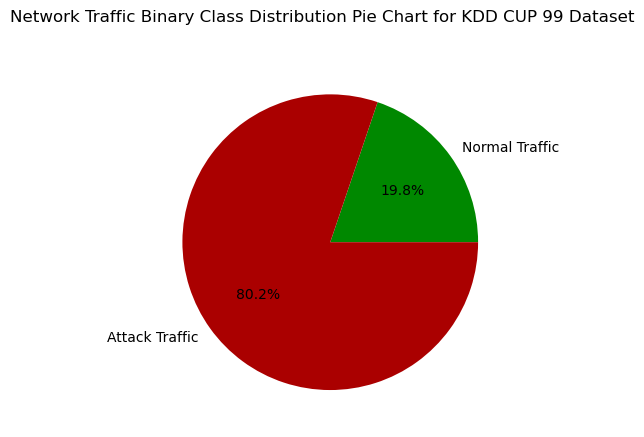

In [41]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_kdd_cup_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for KDD CUP 99 Dataset')

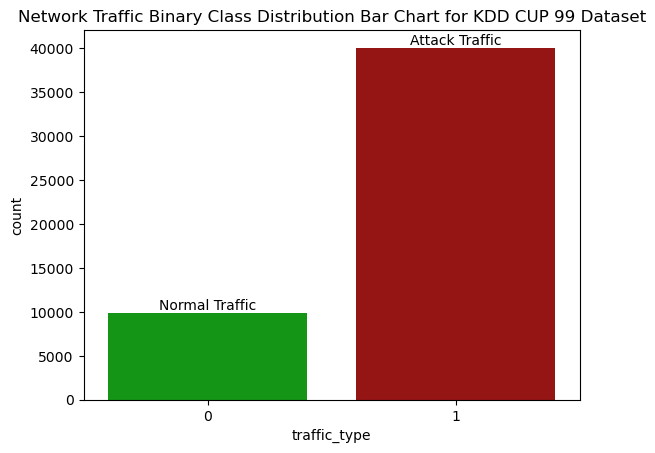

In [42]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_kdd_cup_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart for KDD CUP 99 Dataset')

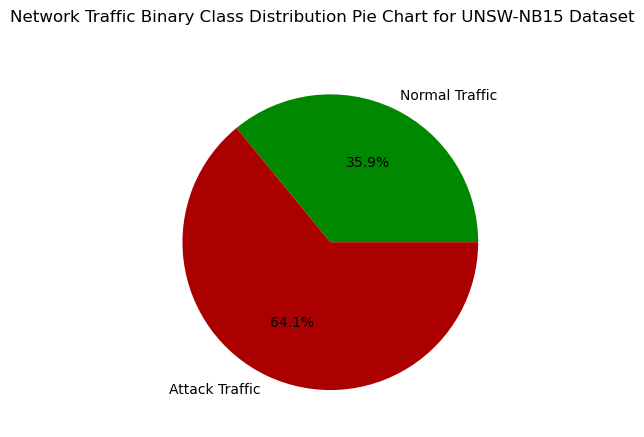

In [43]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_unsw_nb15_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for UNSW-NB15 Dataset')

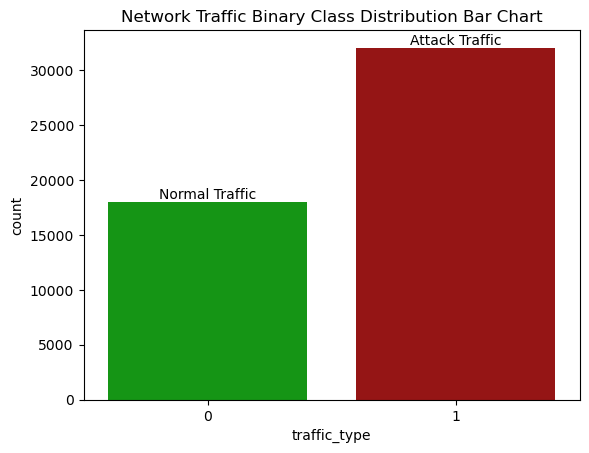

In [44]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_unsw_nb15_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart')

In [45]:
eda_kdd_cup_df = eda_kdd_cup_df.drop([target_variable], axis=1)
eda_unsw_nb15_df = eda_unsw_nb15_df.drop([target_variable], axis=1)

In [46]:
eda_kdd_cup_99_categorical_features, eda_kdd_cup_99_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_kdd_cup_df)

In [47]:
eda_unsw_nb15_categorical_features, eda_unsw_nb15_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_unsw_nb15_df)




Summary for PROTOCOL_TYPE feature value counts

icmp    28904
tcp     19108
udp      1988
Name: protocol_type, dtype: int64



Summary for SERVICE feature value counts

ecr_i          28690
private        11238
http            6375
smtp             948
other            781
domain_u         578
ftp_data         411
eco_i            163
ftp               67
finger            64
urp_i             50
auth              41
telnet            40
ntp_u             39
time              21
pop_3             20
ctf               19
whois             17
sunrpc            17
vmnet             16
sql_net           16
nntp              15
ldap              14
bgp               14
daytime           14
name              14
rje               13
netbios_ns        13
efs               13
login             12
gopher            12
echo              12
exec              12
supdup            11
pop_2             11
Z39_50            11
domain            10
hostnames         10
iso_tsap          10
nnsp     

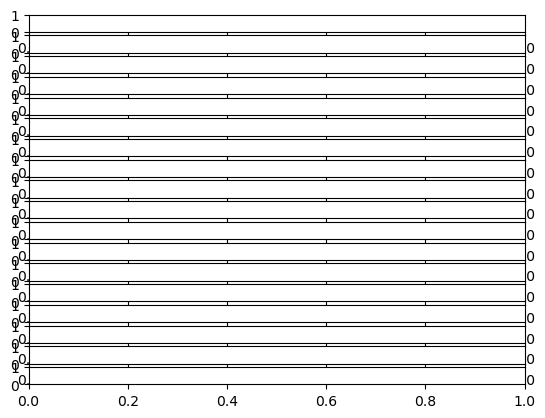

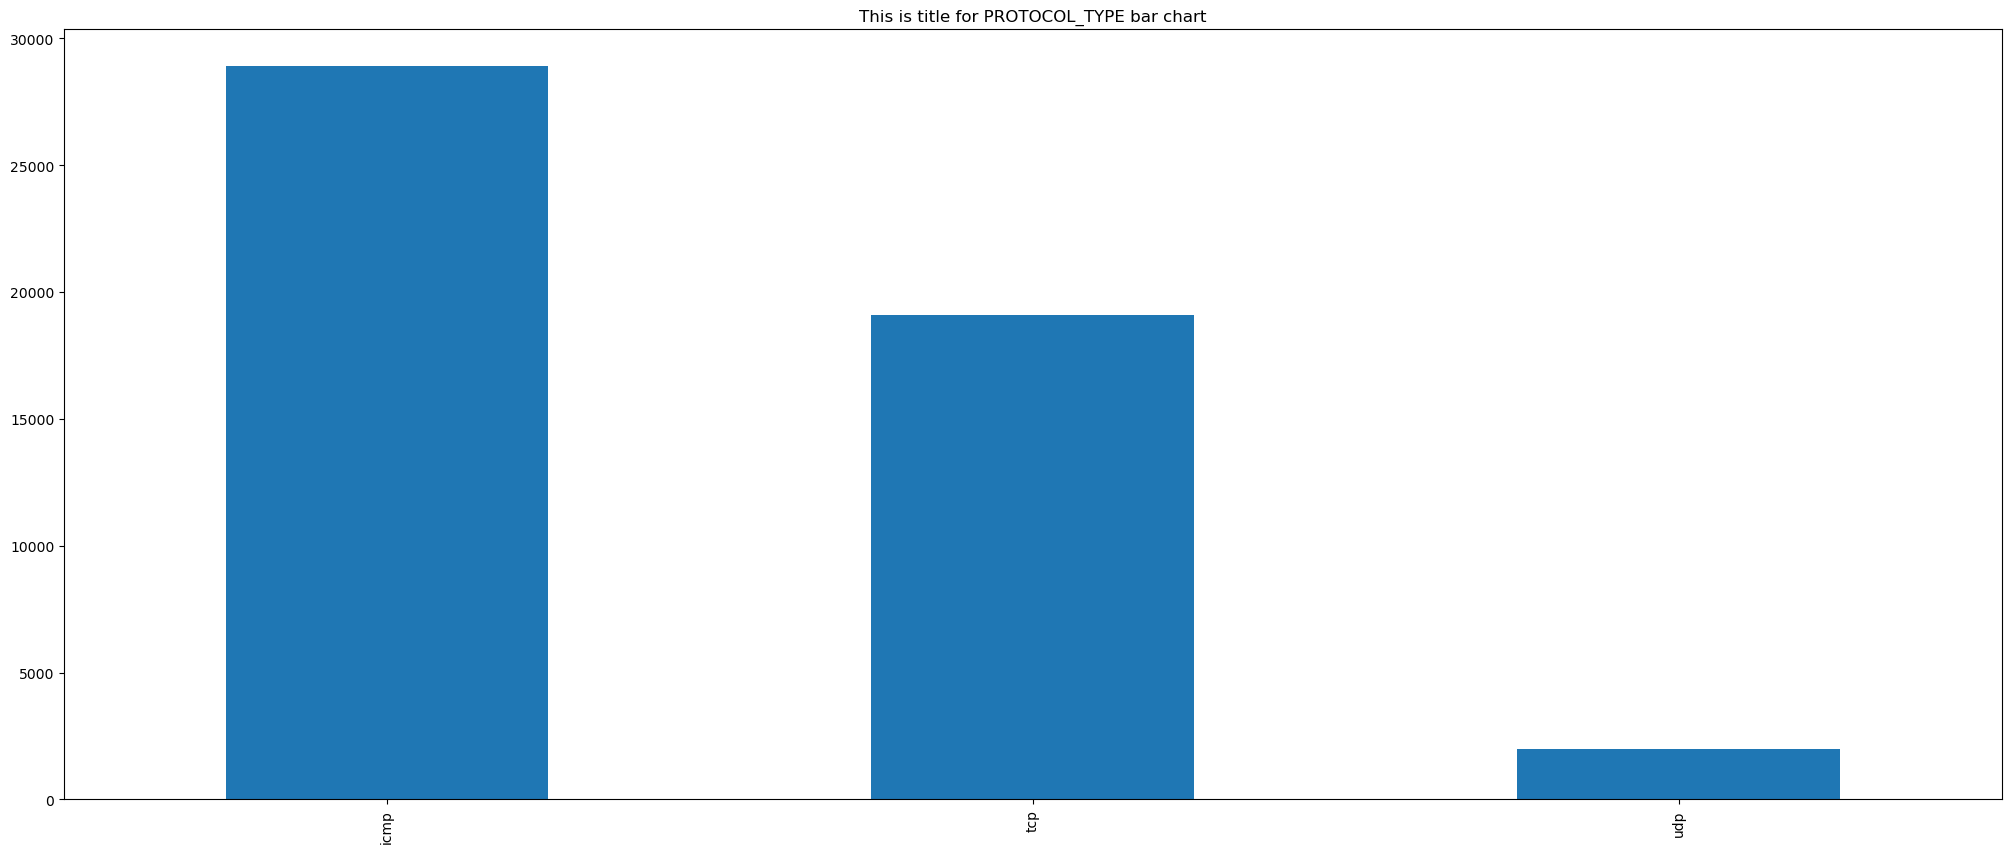

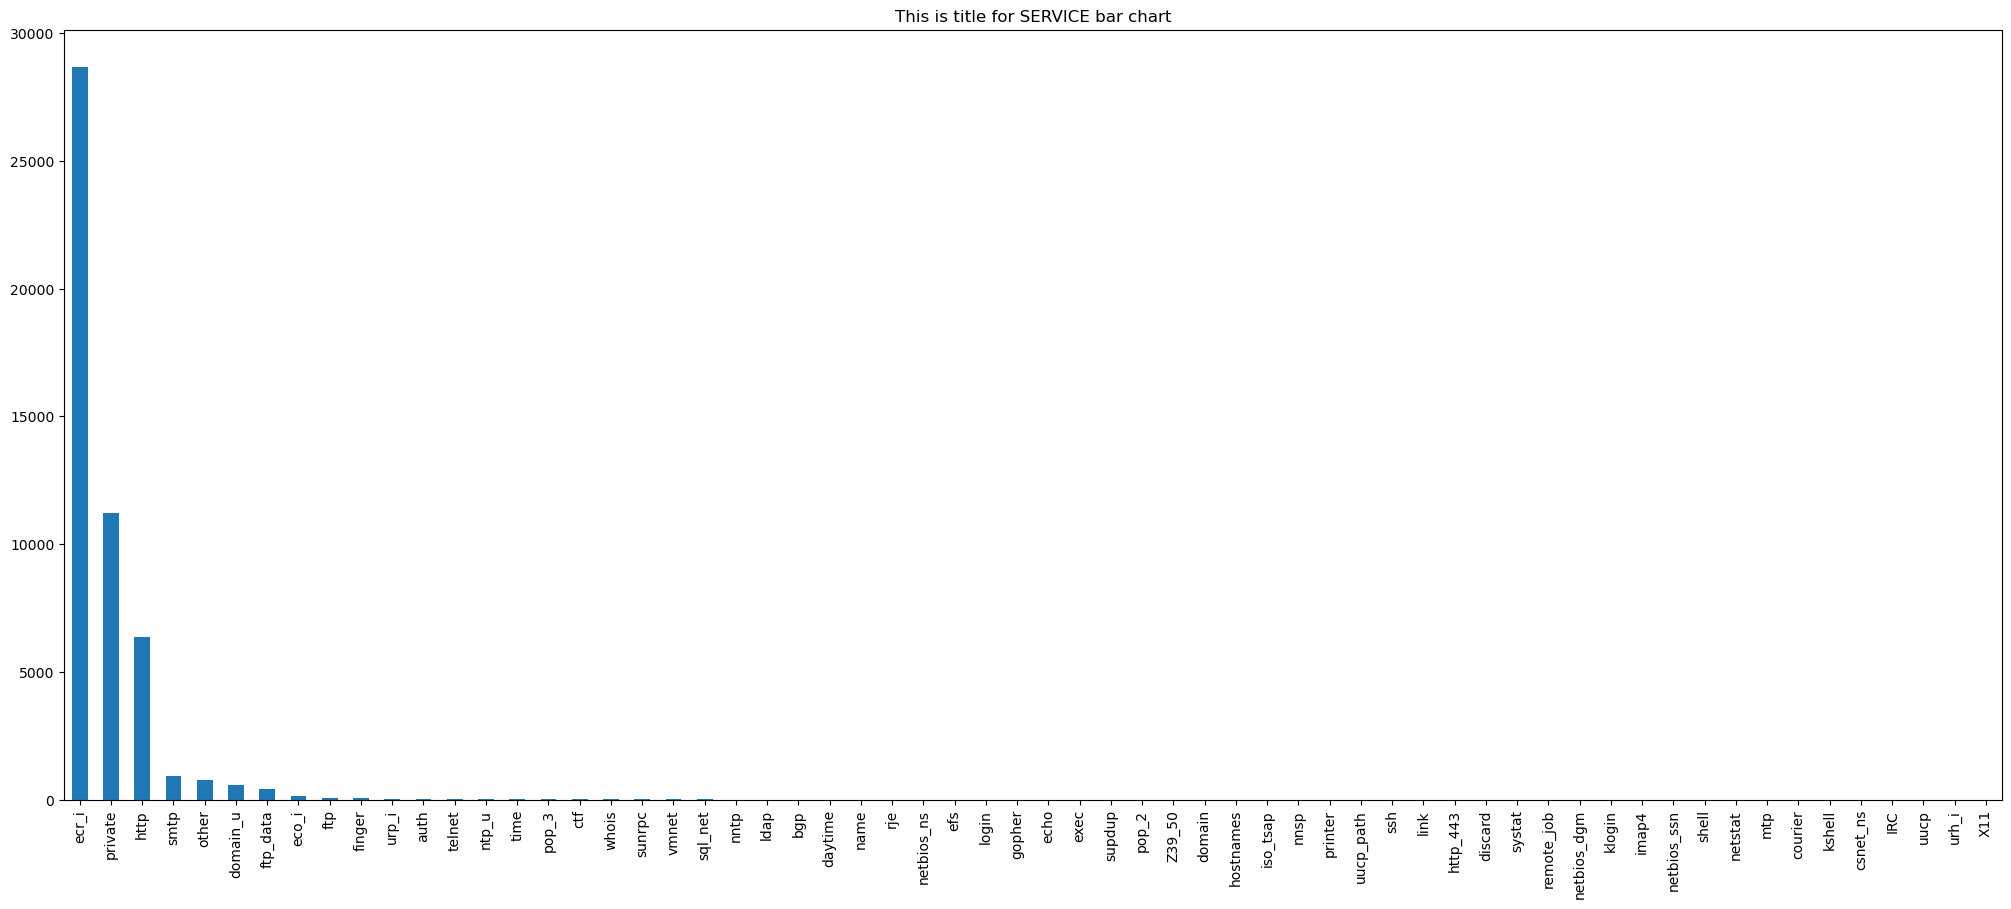

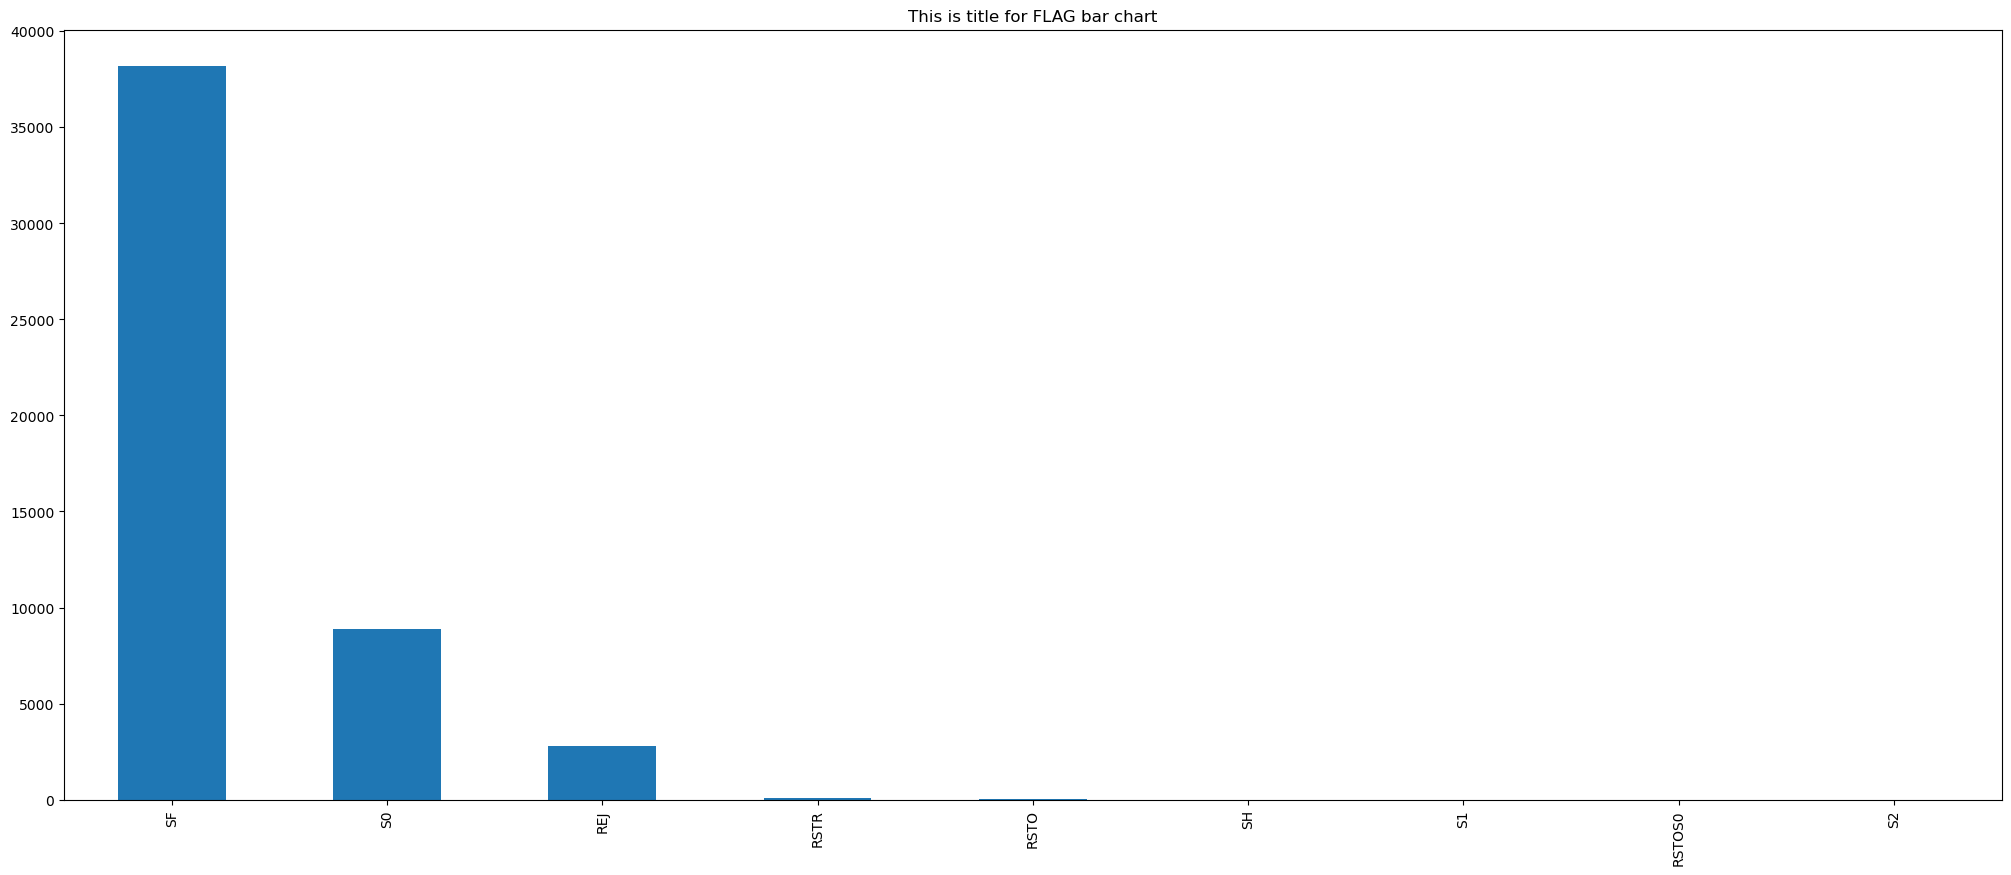

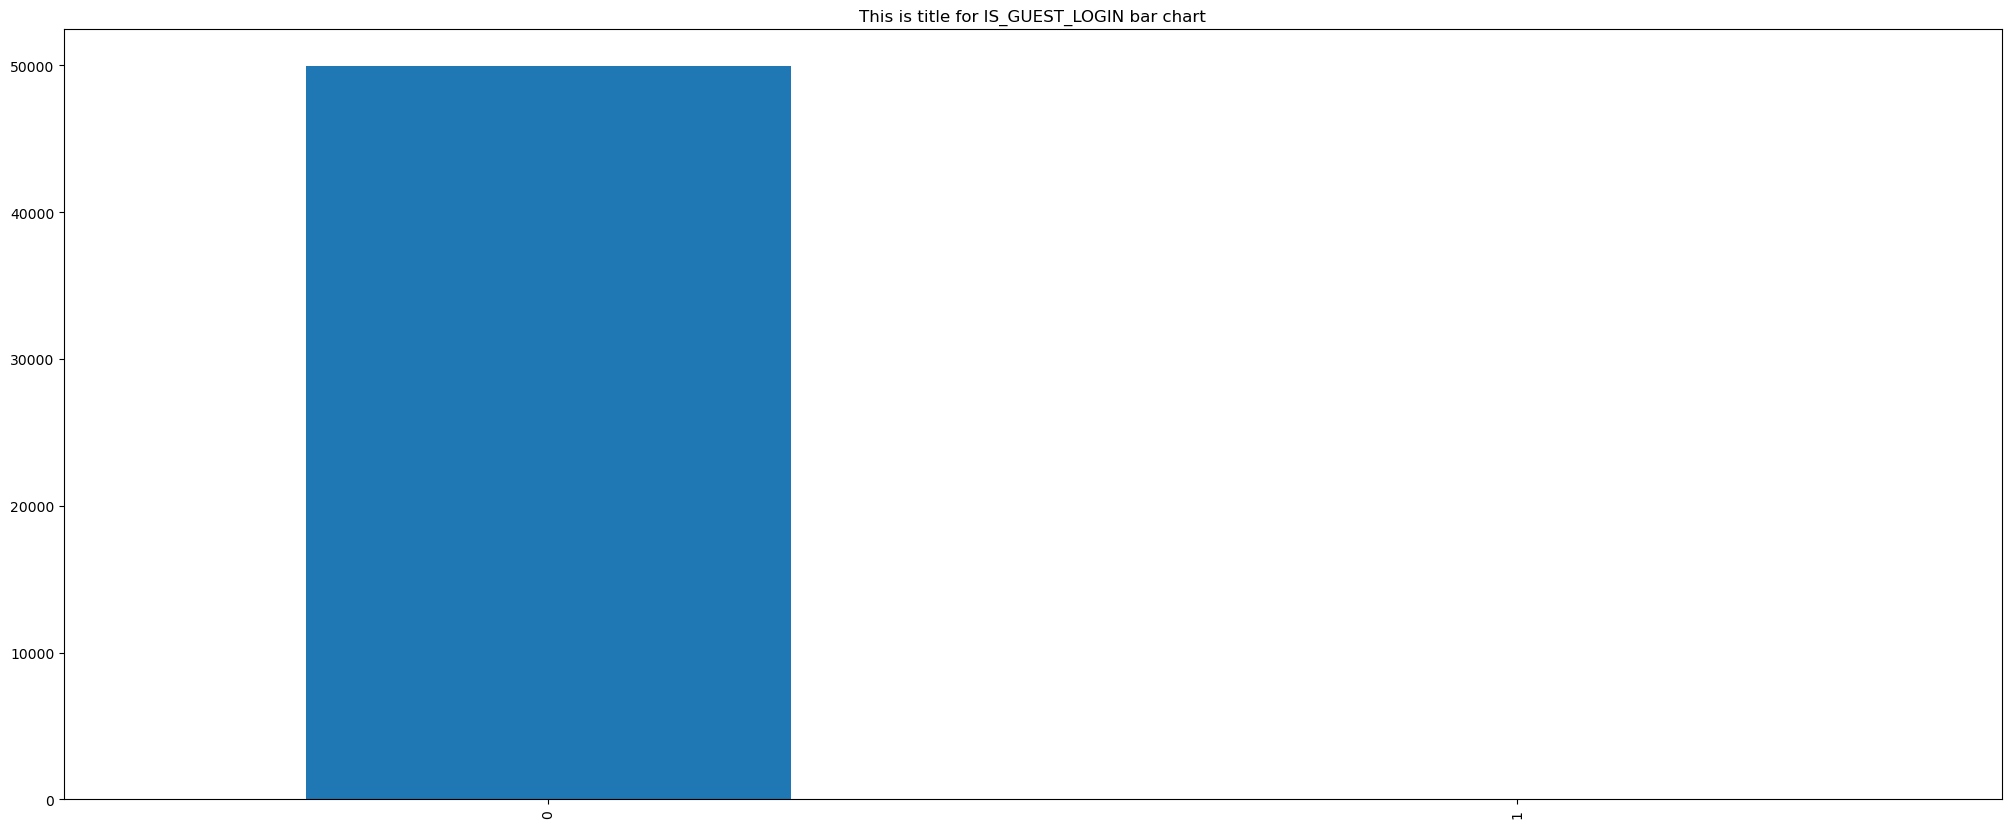

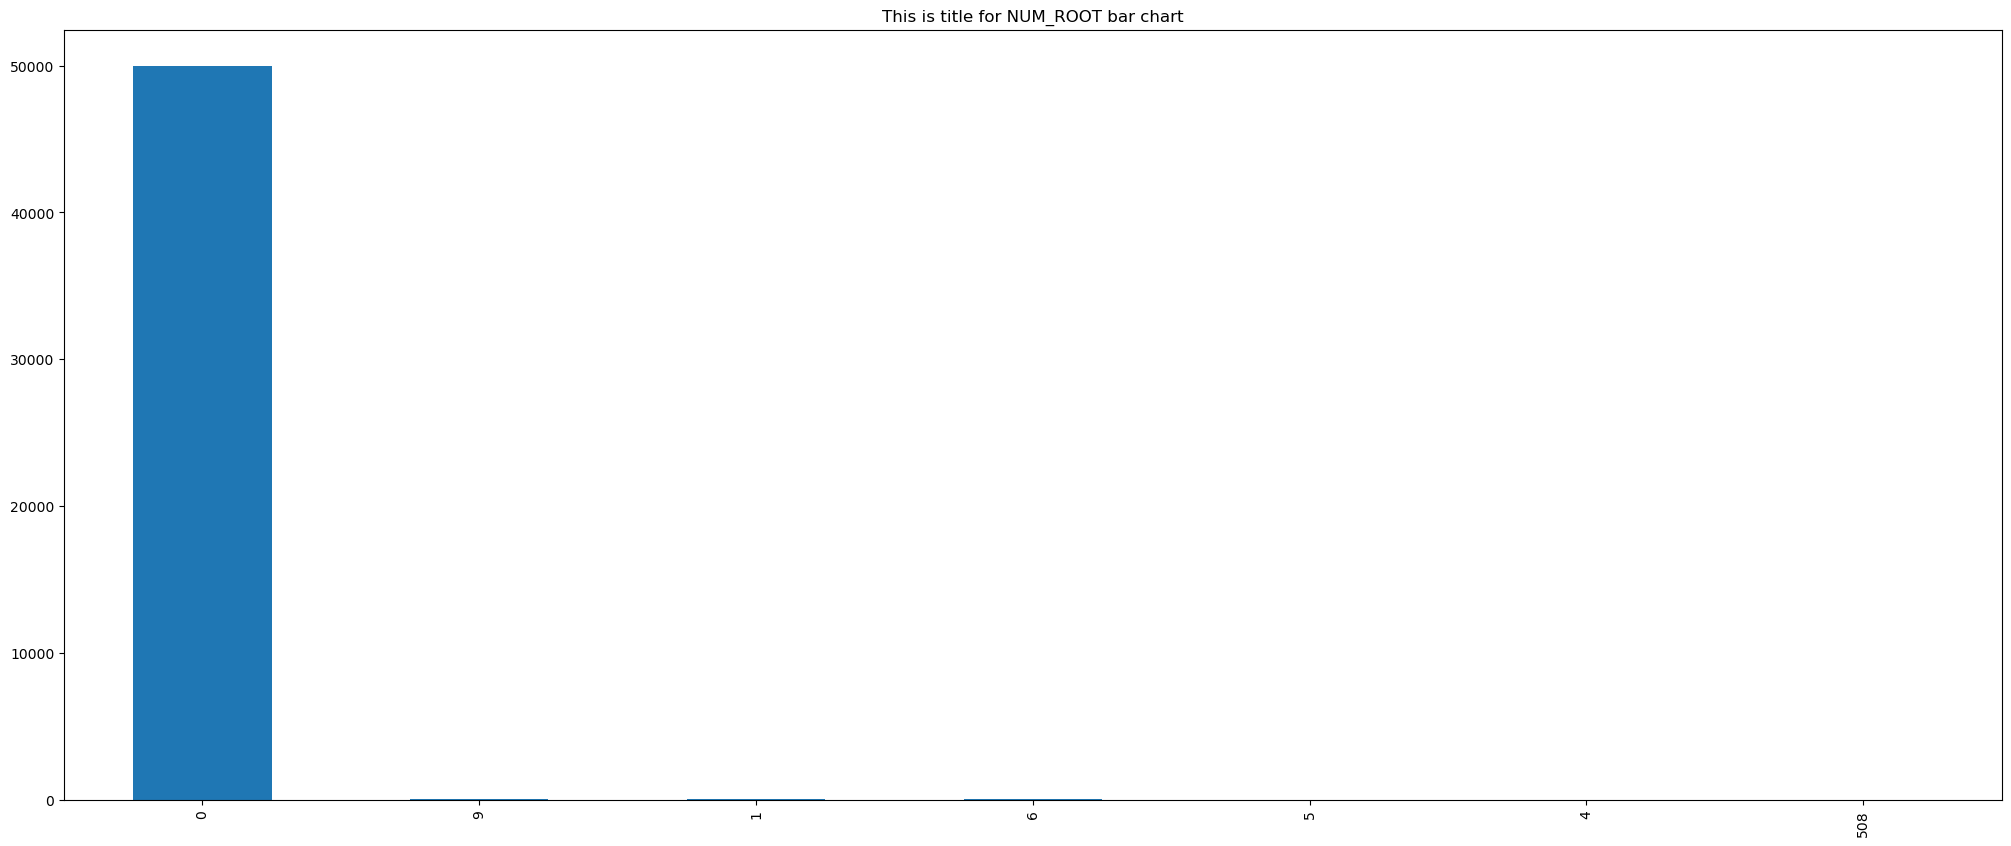

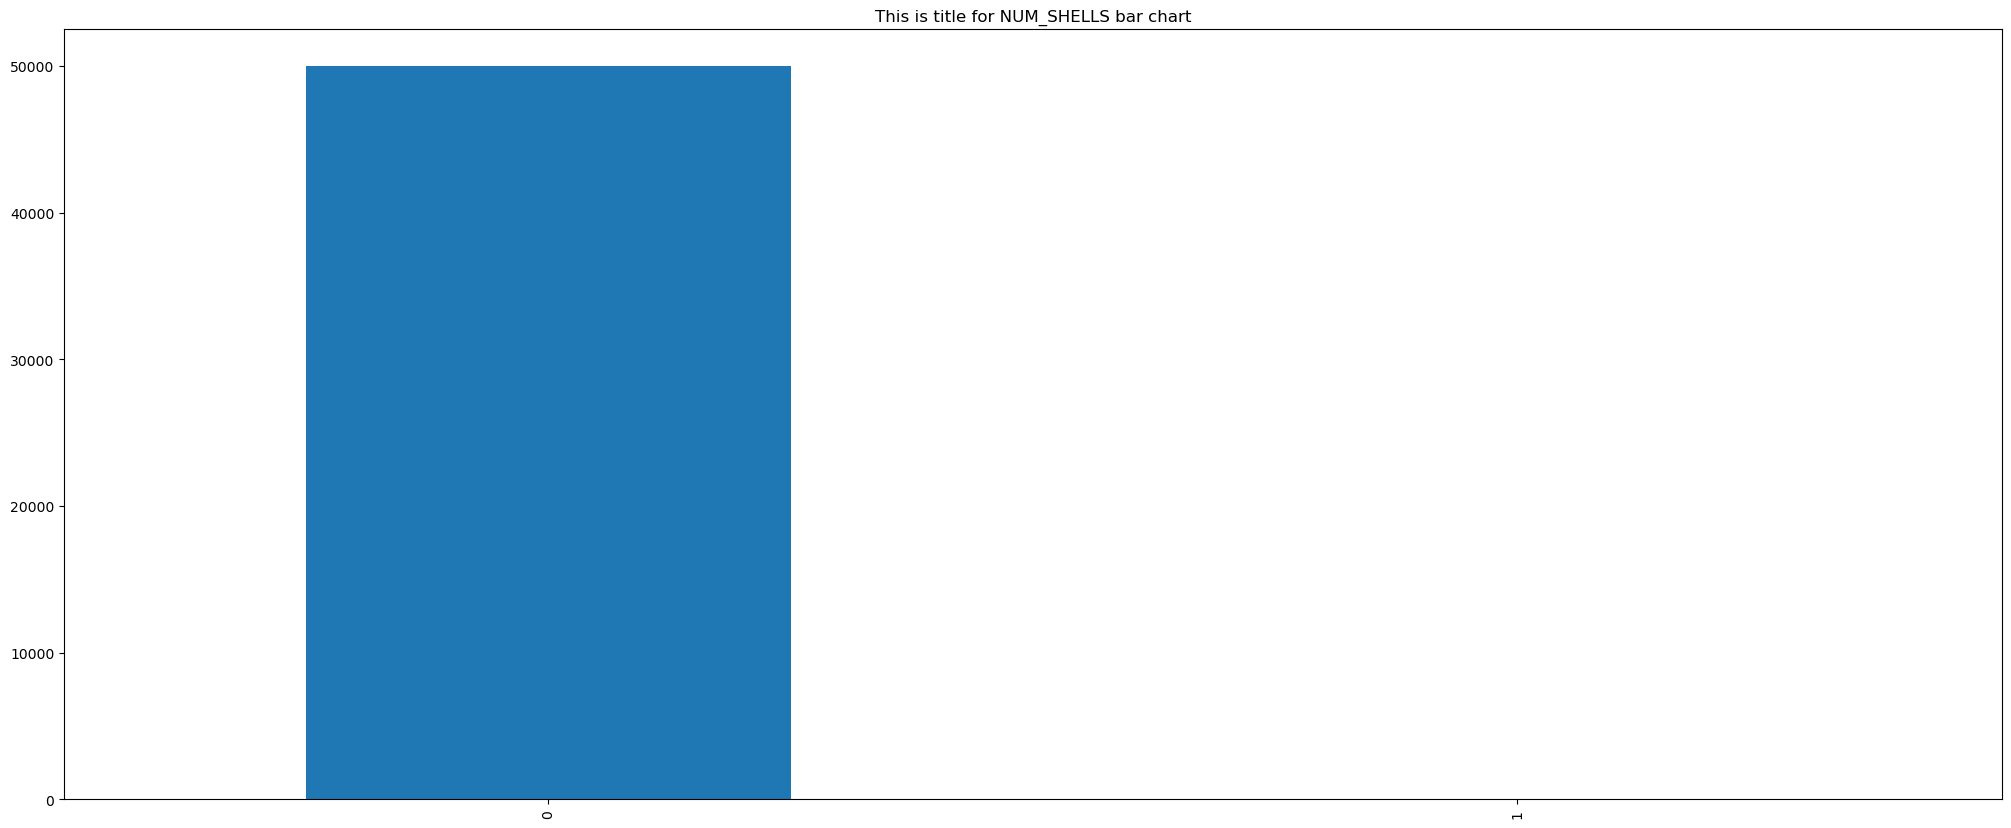

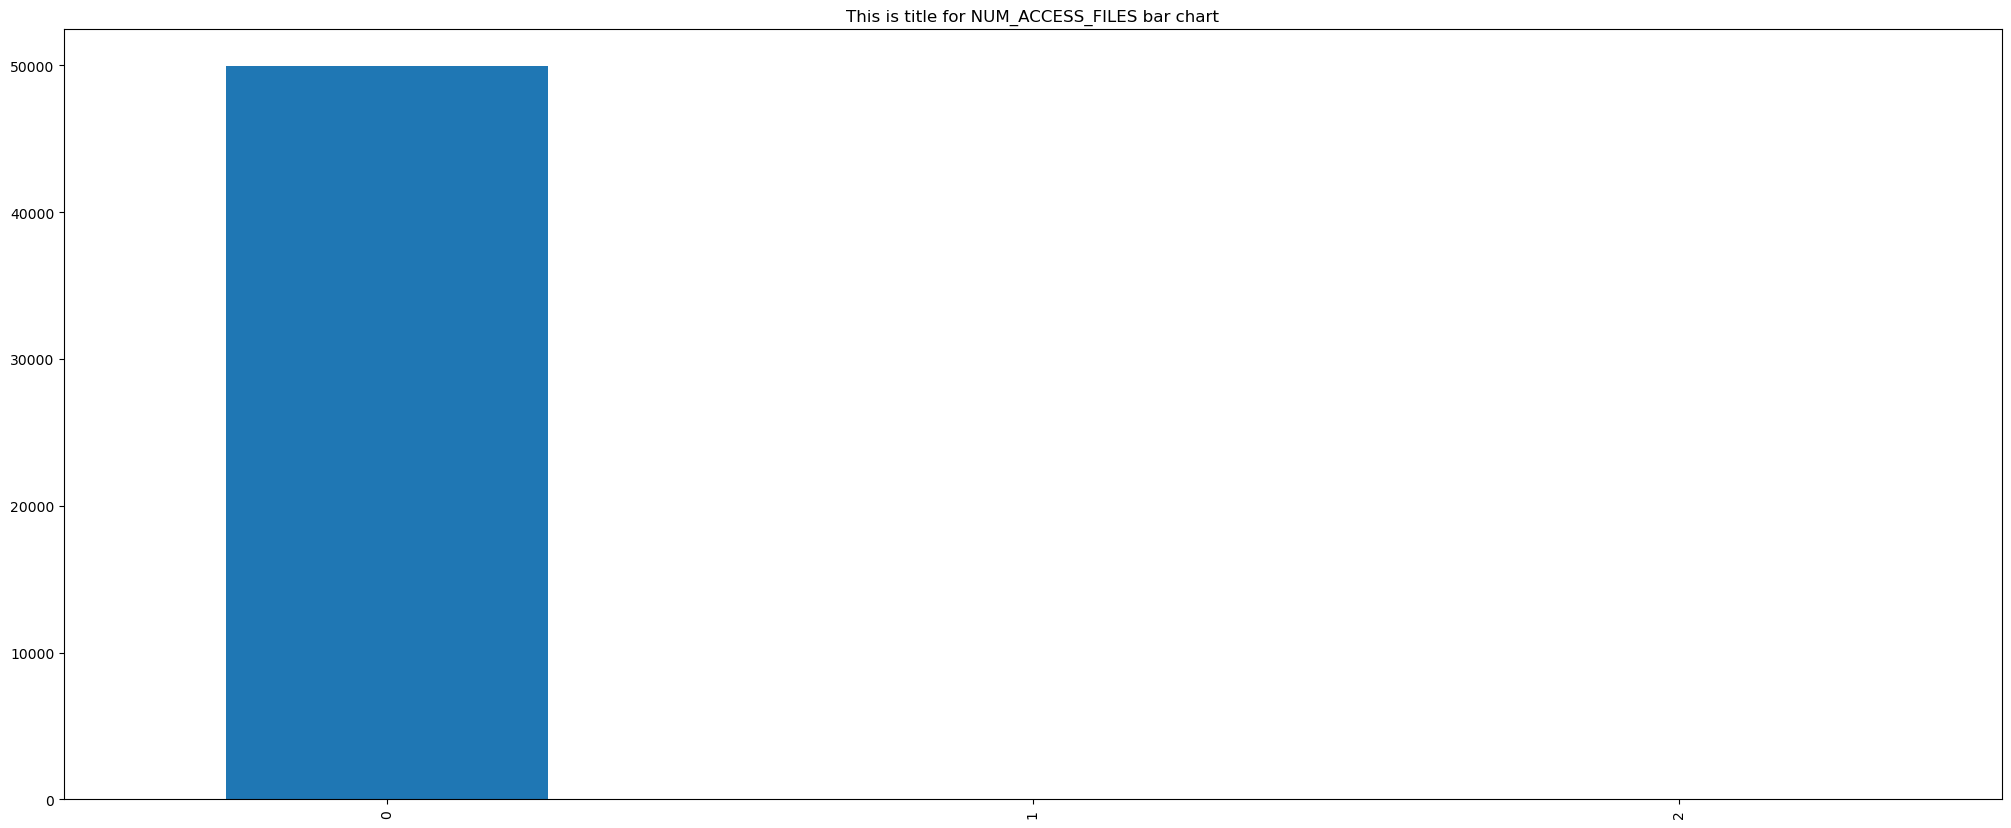

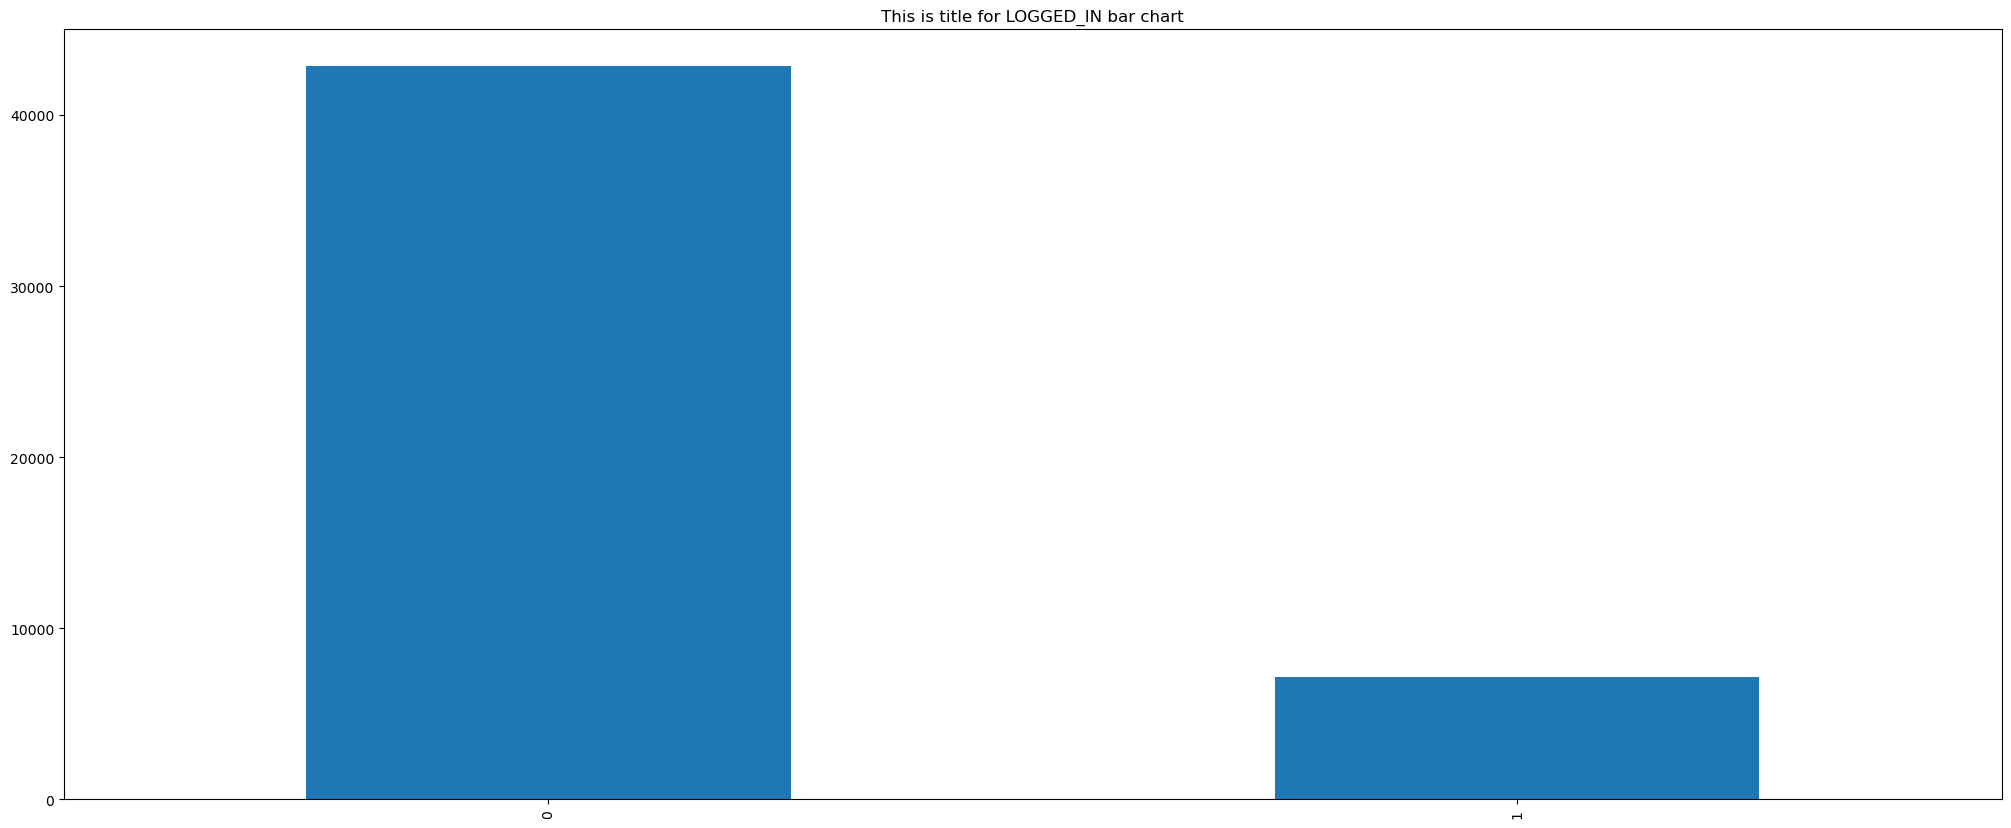

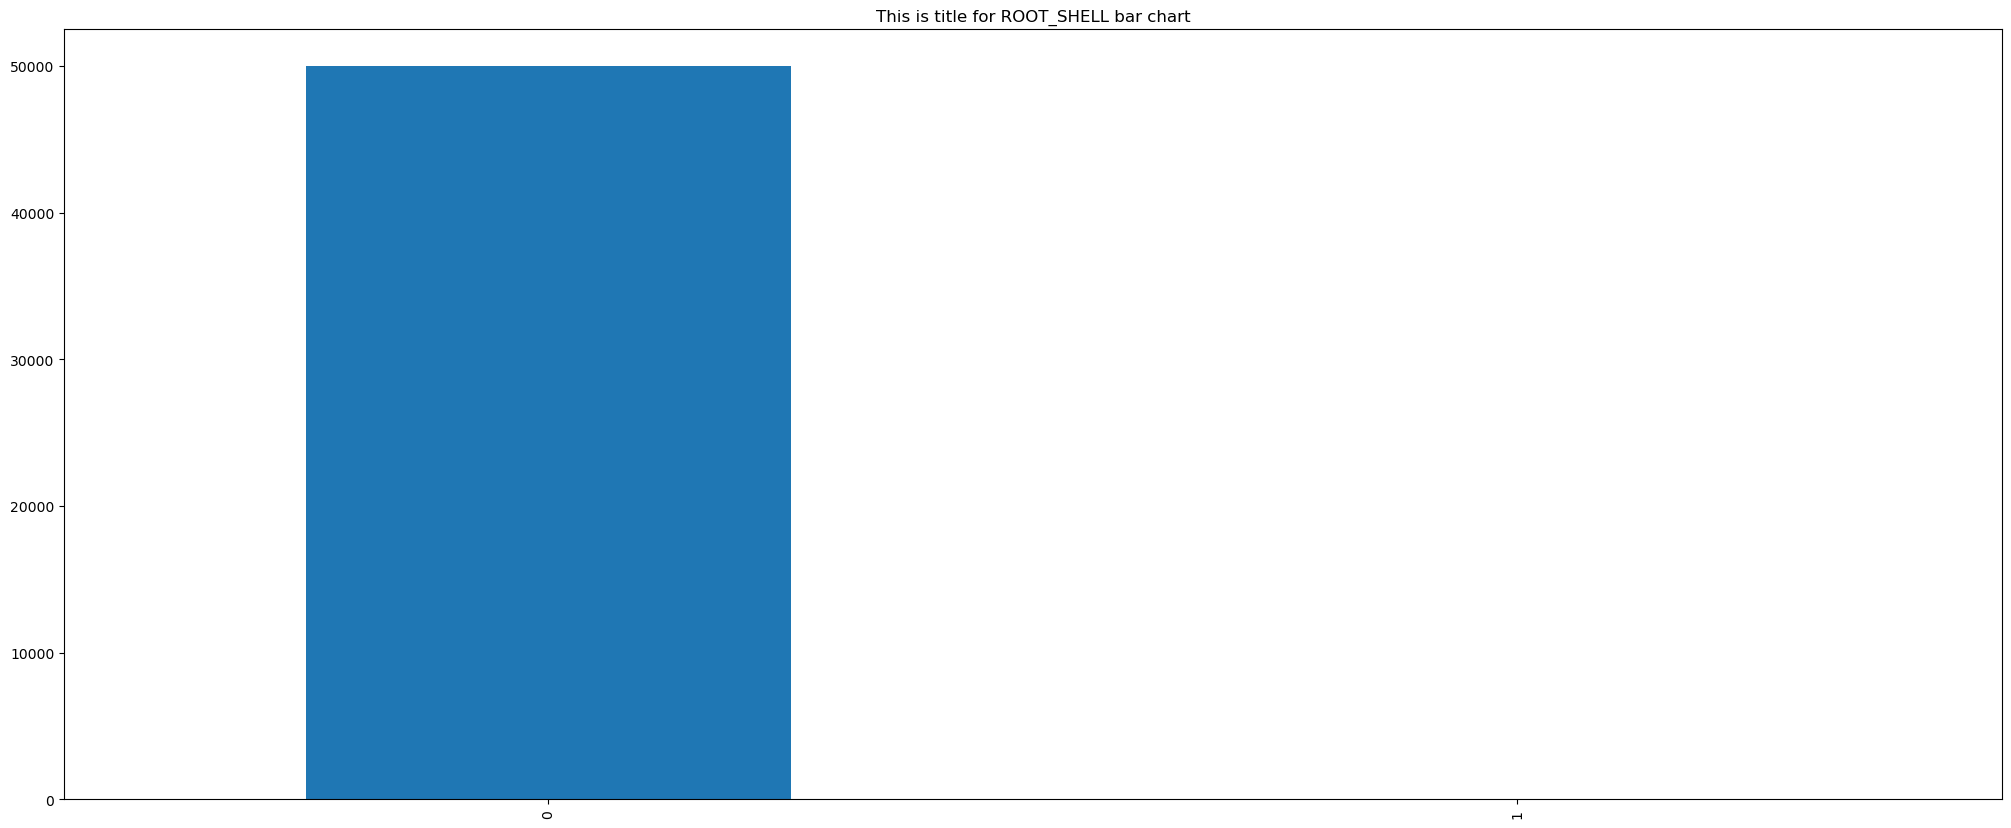

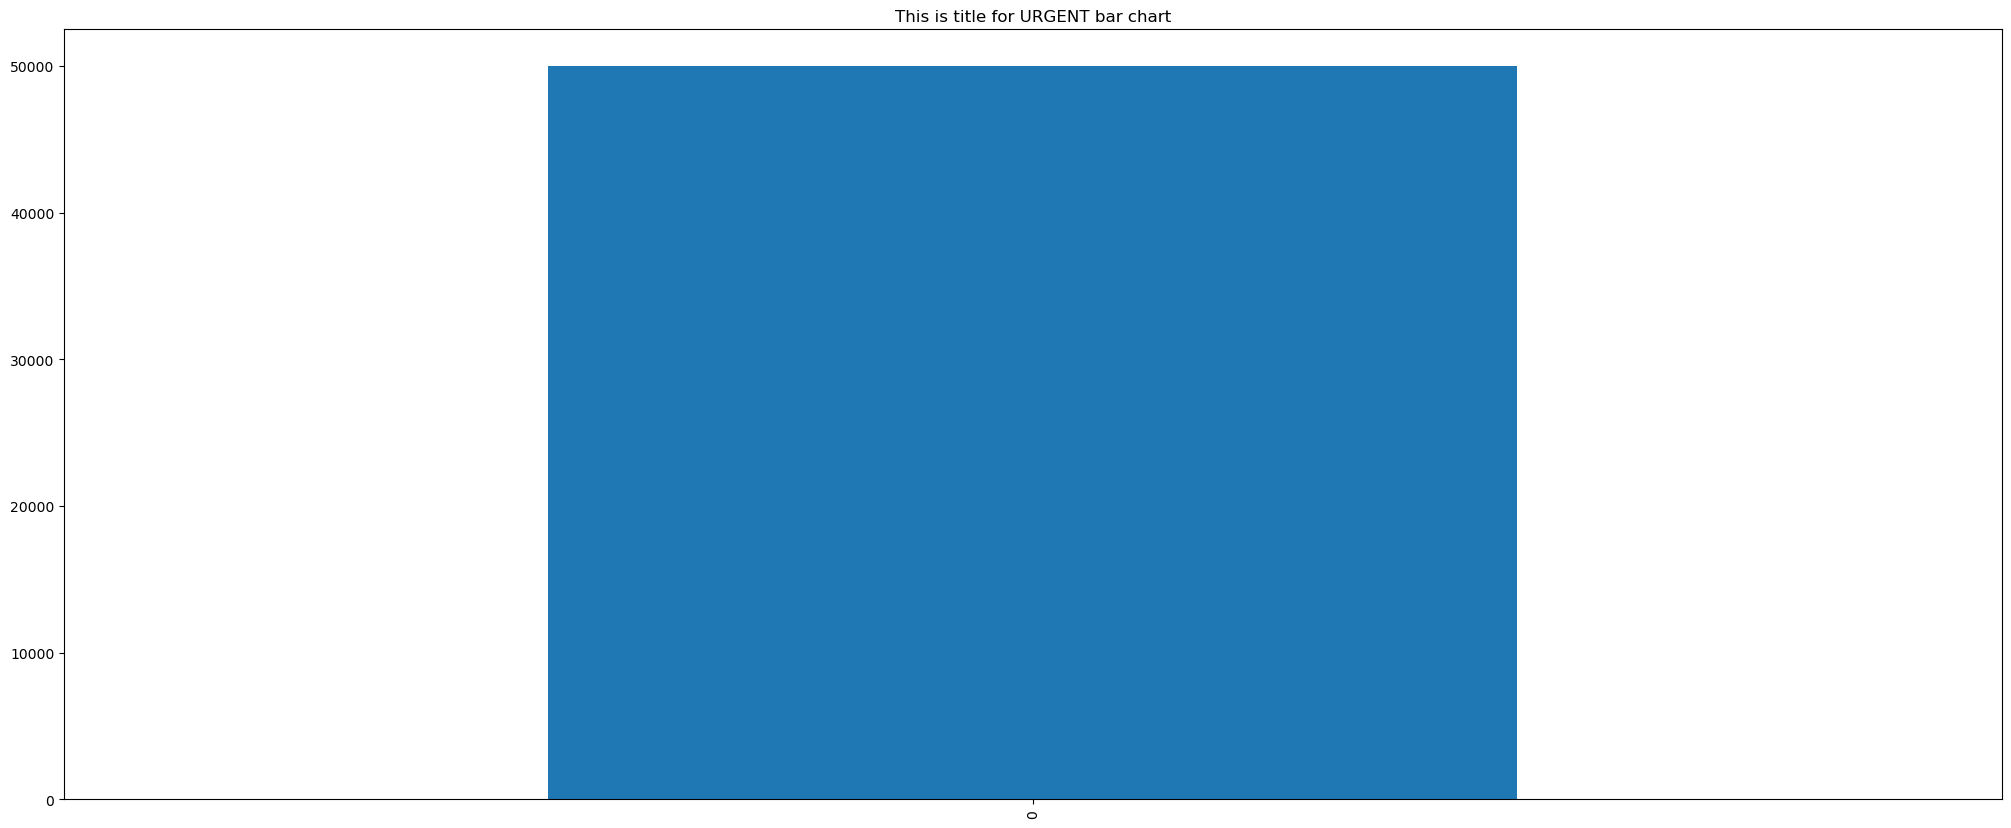

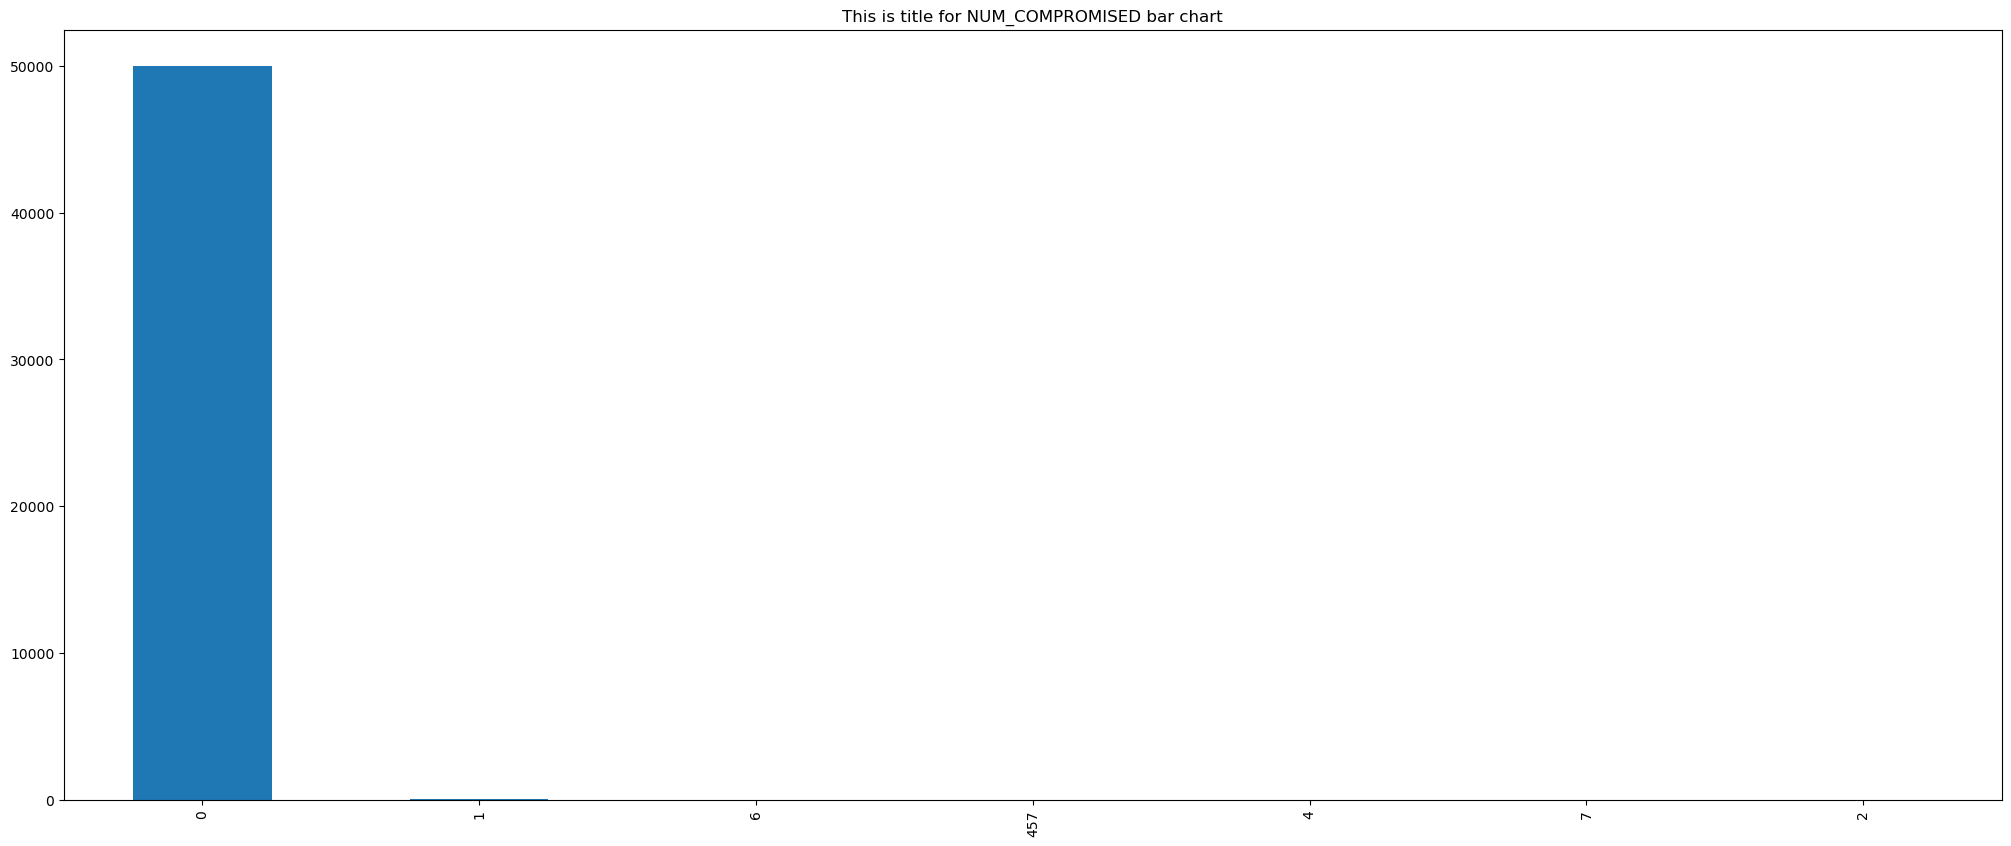

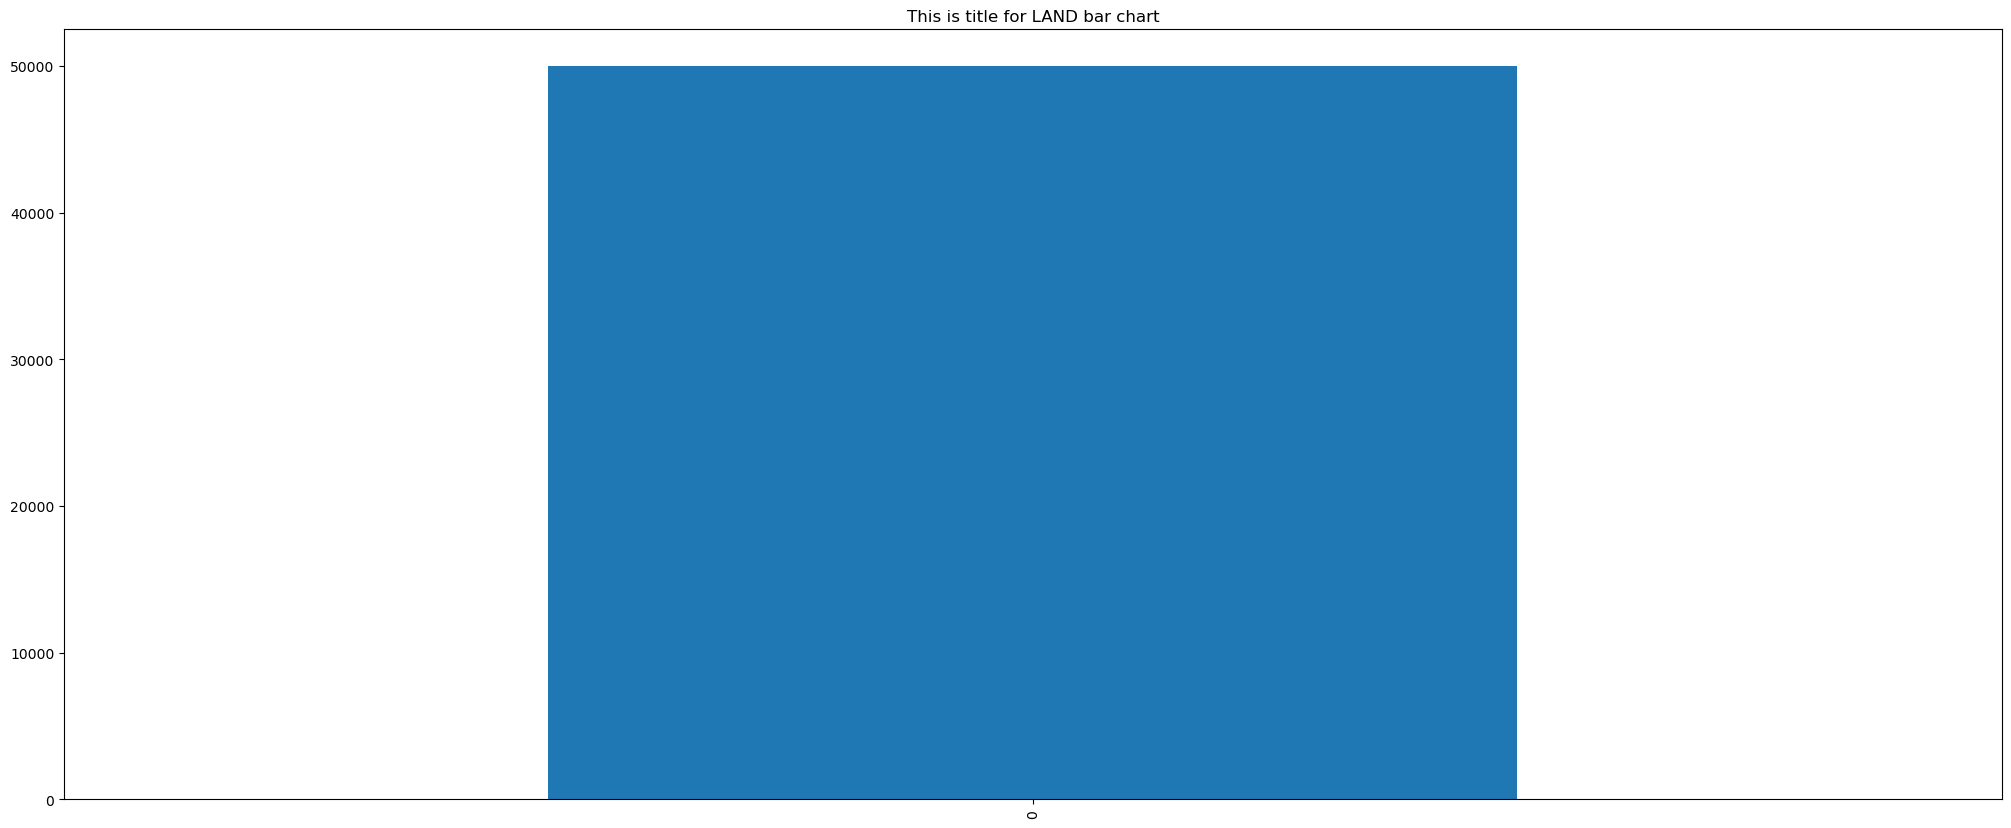

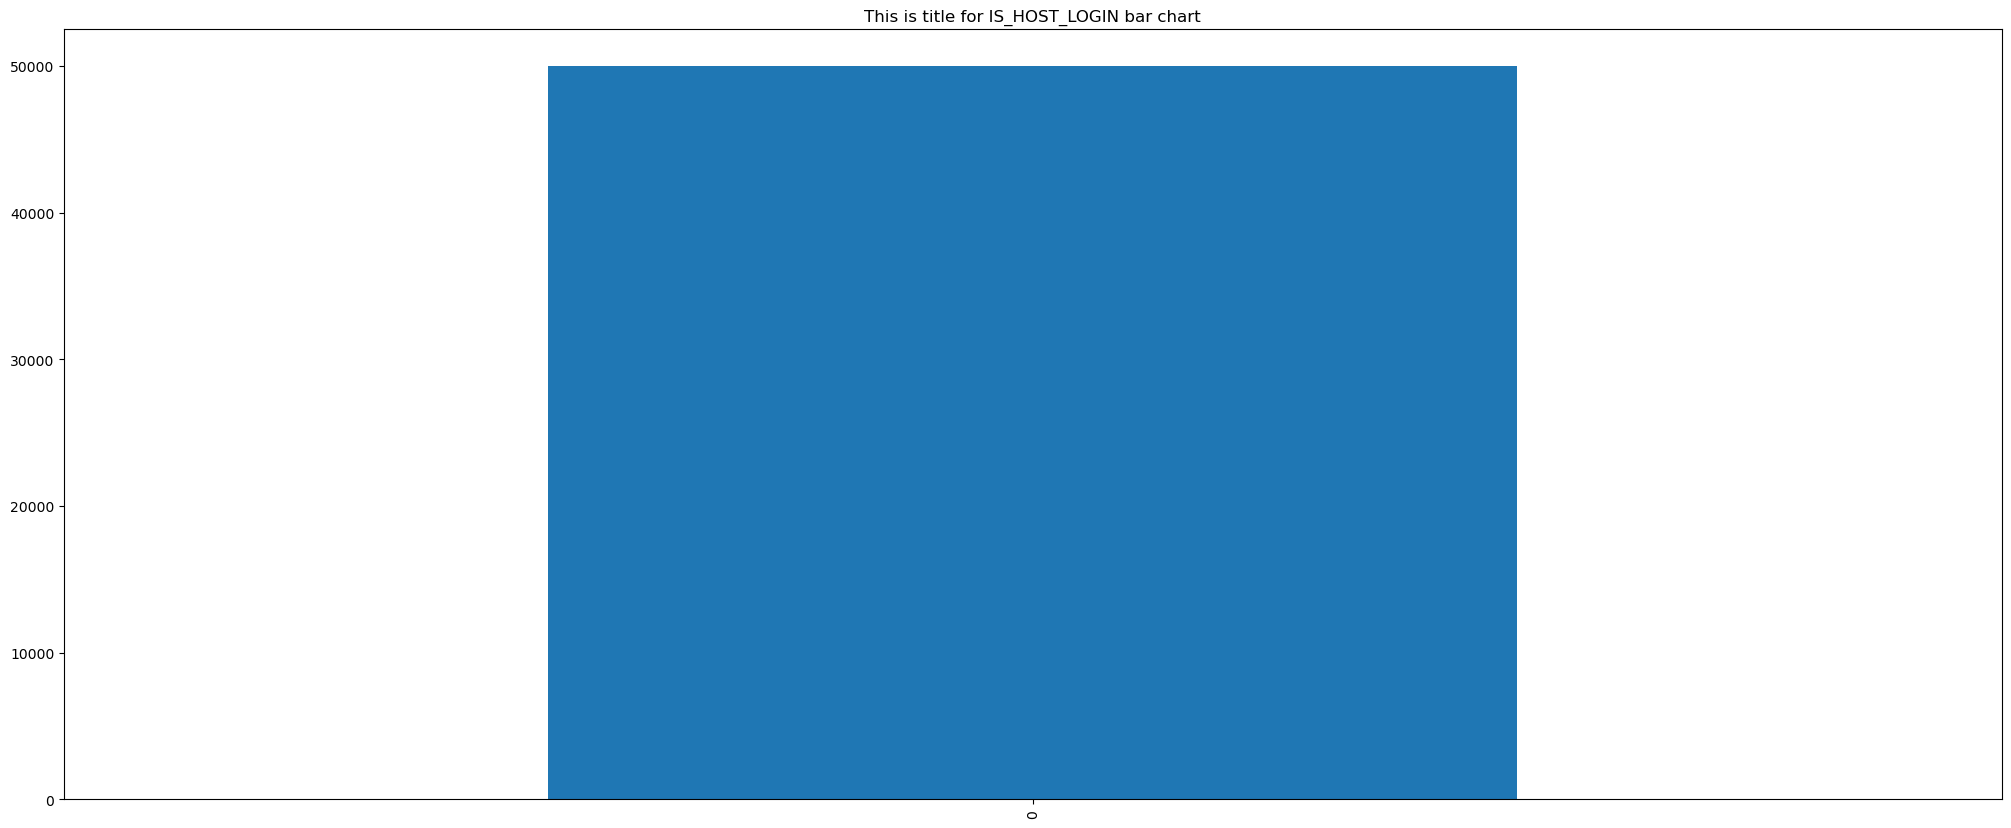

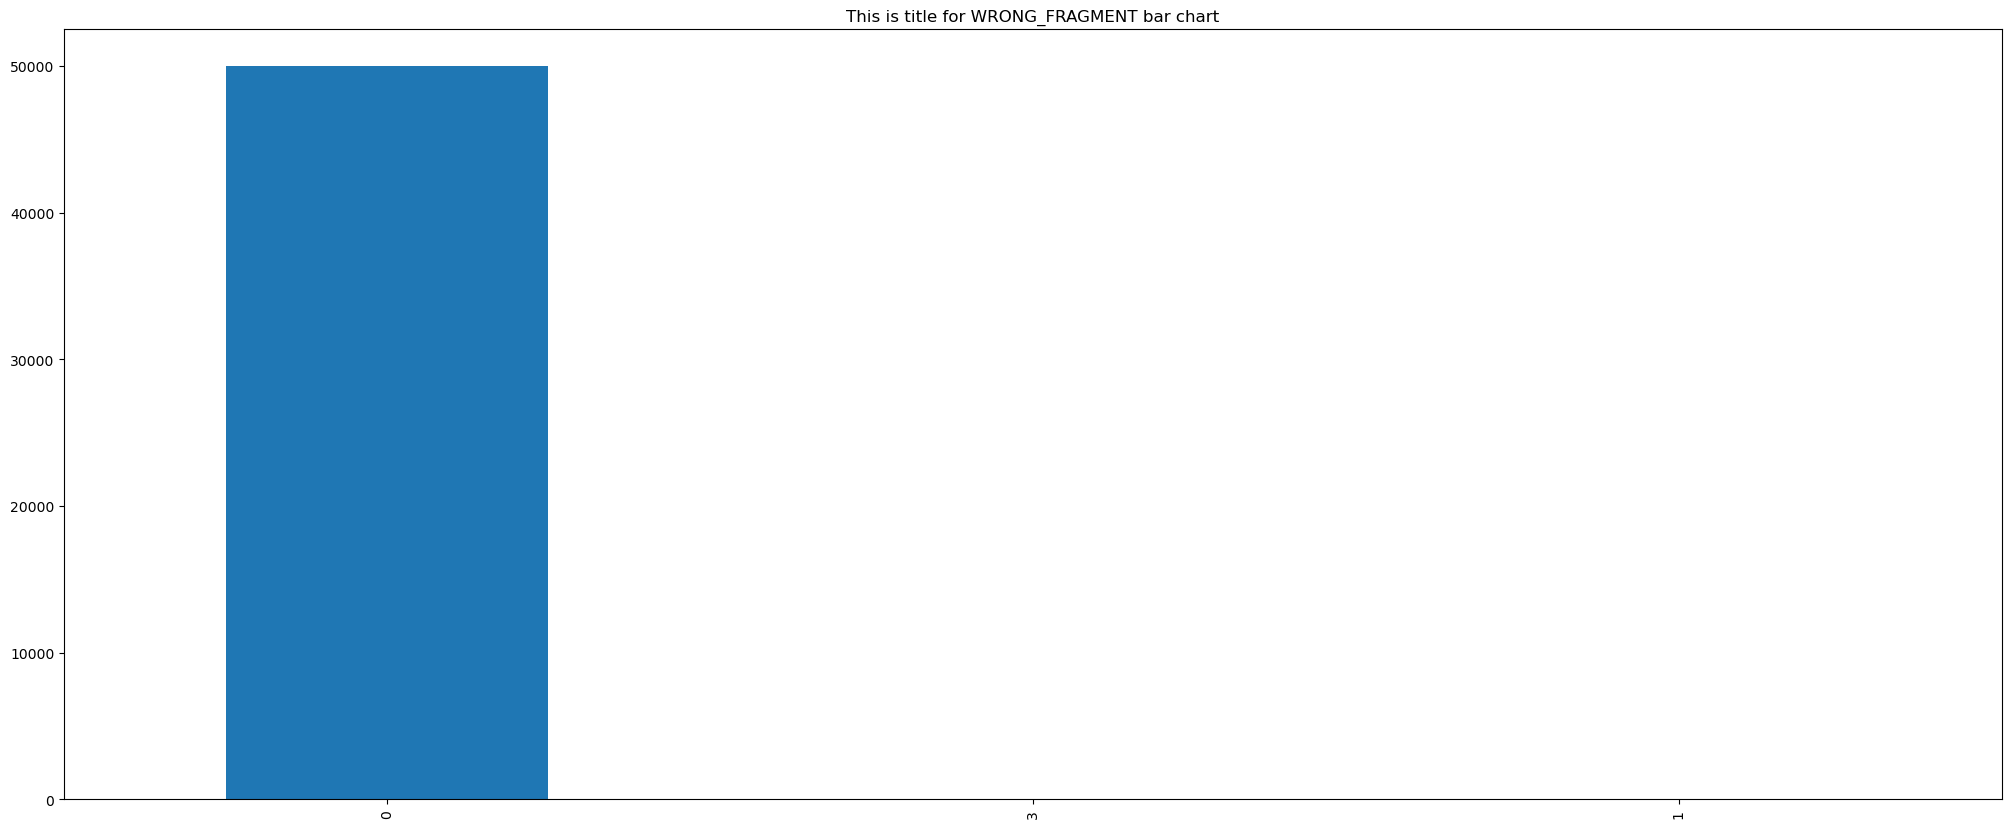

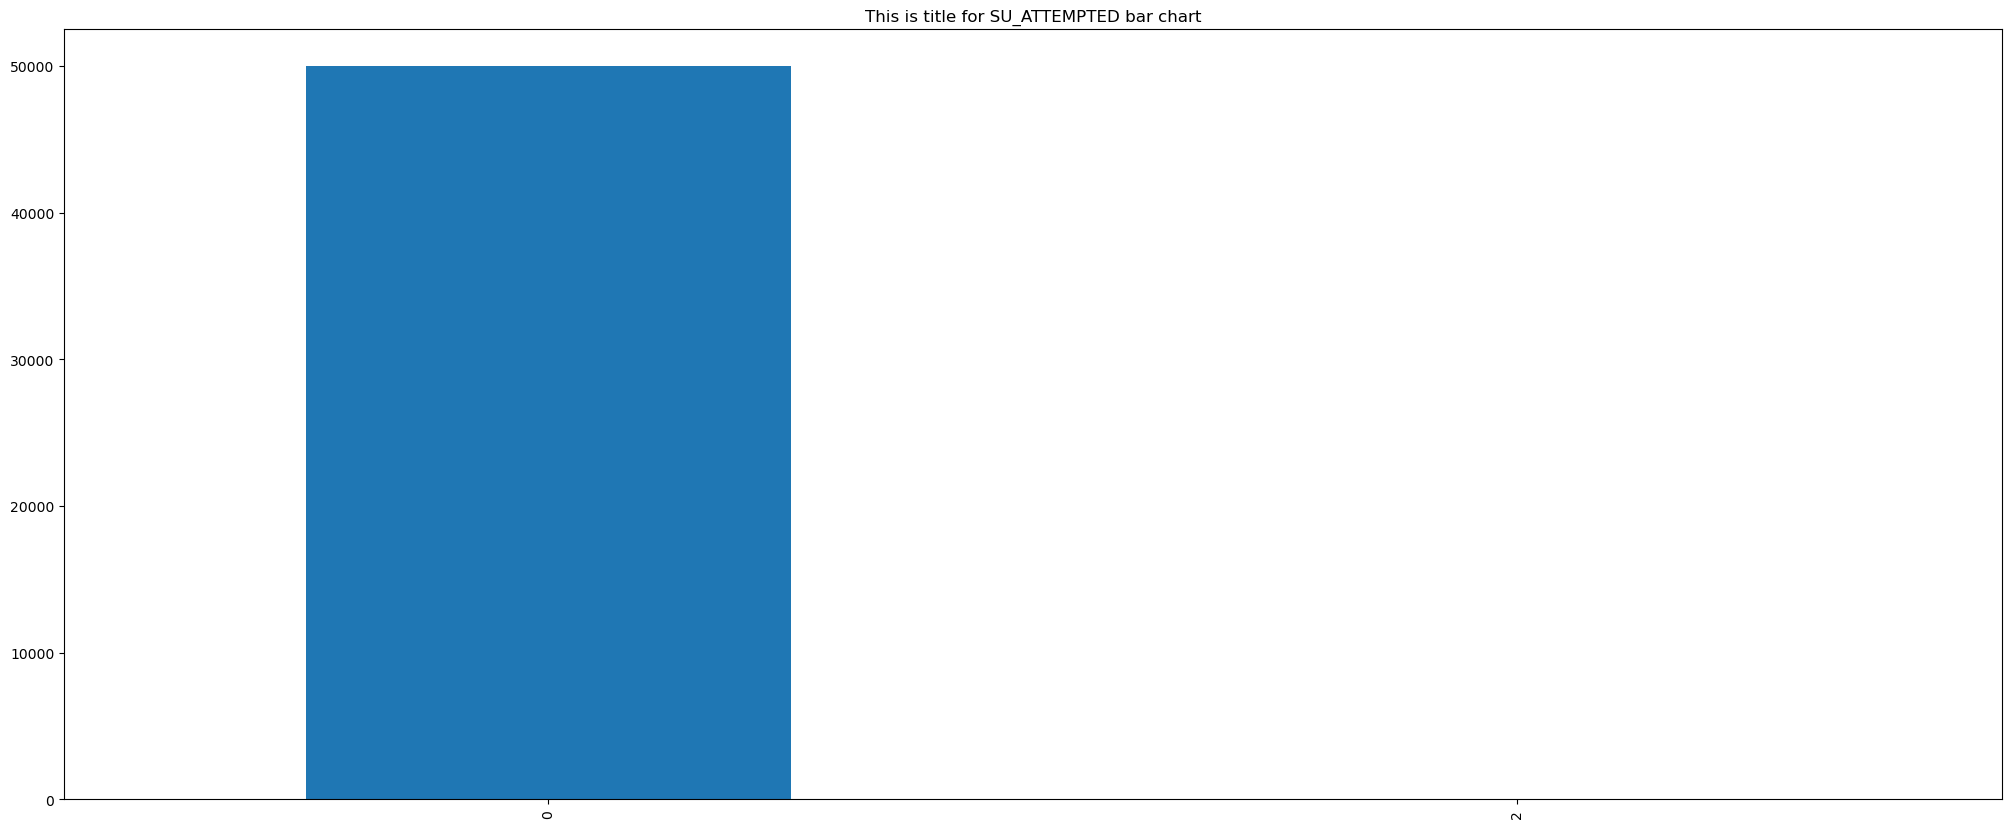

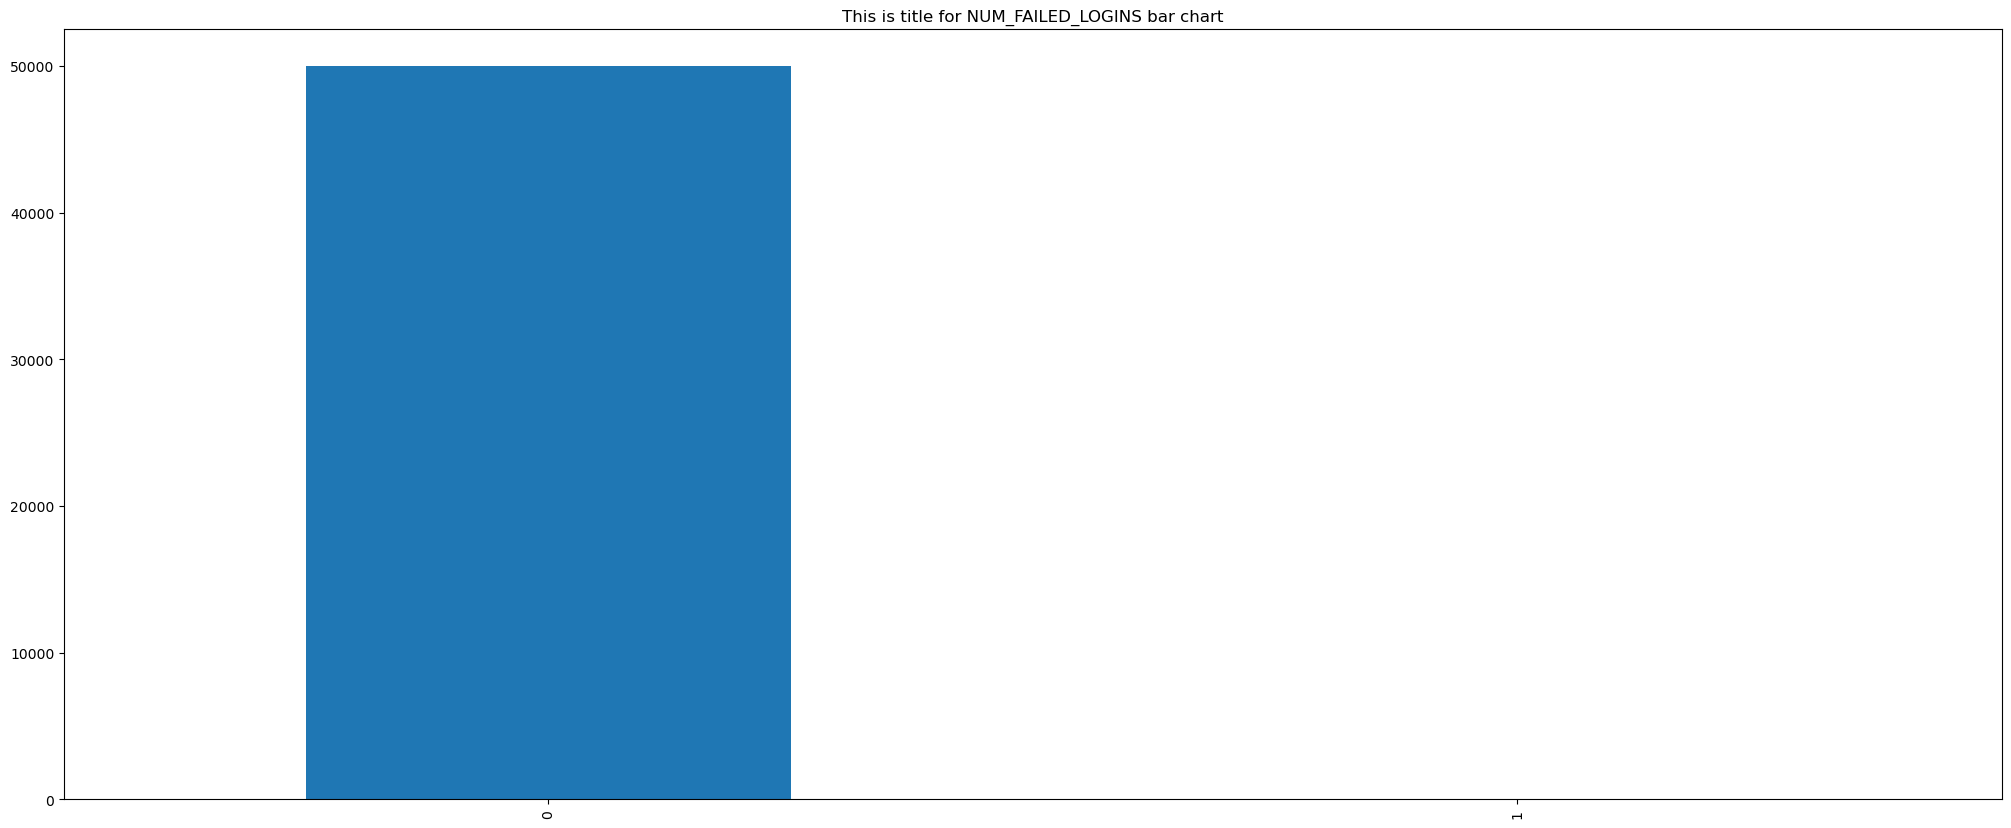

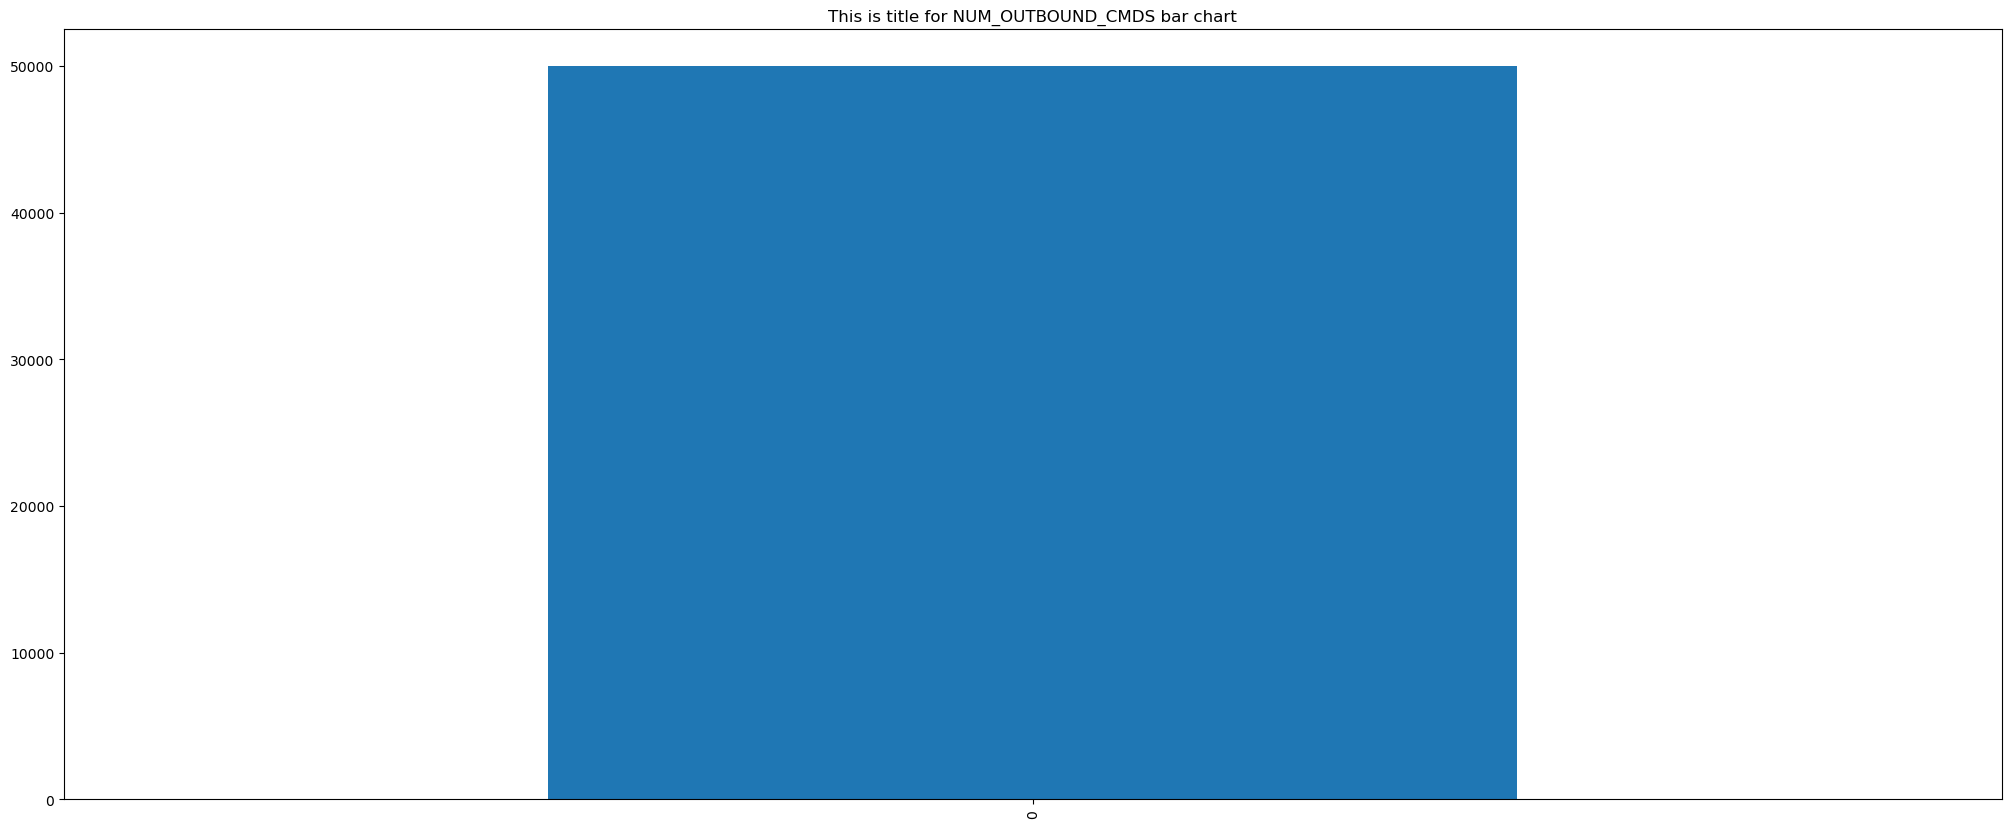

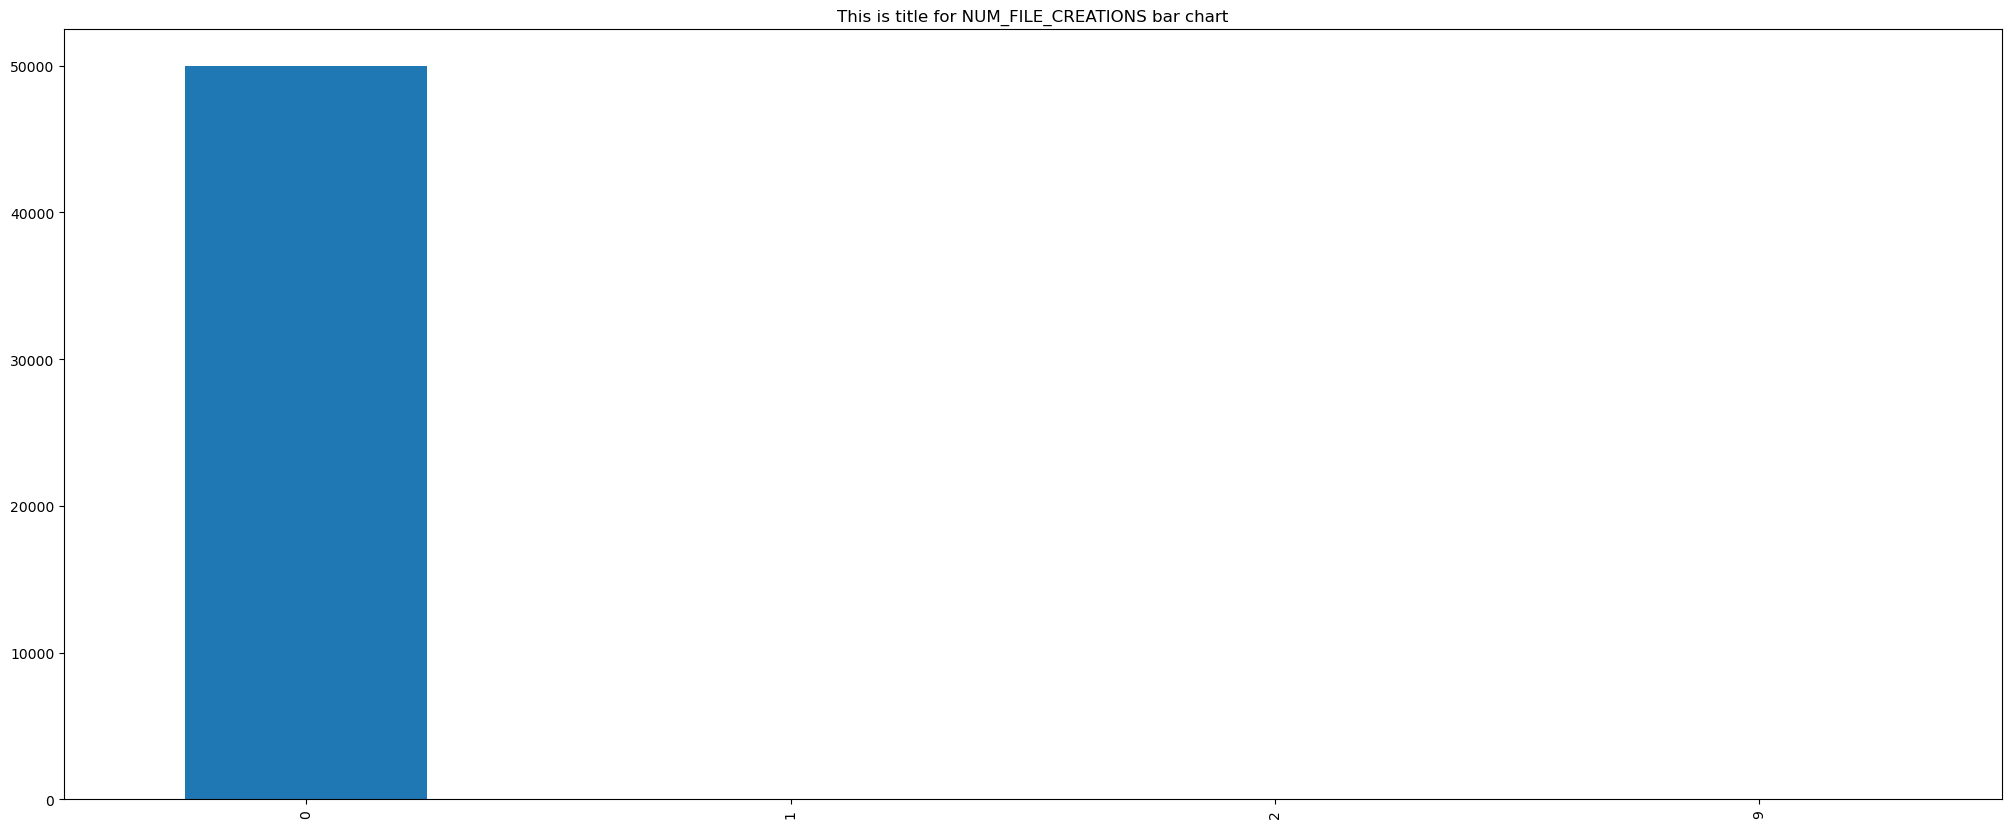

In [48]:
show_bar_plots_for_all_categorical_plots(eda_kdd_cup_df, eda_kdd_cup_99_categorical_features)




Summary for STATE feature value counts

INT    22690
FIN    22650
CON     3868
REQ      770
RST       17
ECO        3
URN        1
CLO        1
Name: state, dtype: int64



Summary for PROTO feature value counts

tcp            23781
udp            18049
unas            3019
arp              708
ospf             673
sctp             287
any               73
gre               72
rsvp              65
swipe             64
mobile            56
pim               51
sep               50
ipv6              48
sun-nd            41
pnni              36
tcf               35
isis              34
wb-mon            34
ptp               33
gmtp              33
narp              33
ttp               33
pup               32
vrrp              32
idpr-cmtp         32
merit-inp         32
xtp               31
xnet              31
ipx-n-ip          31
larp              31
sps               30
ifmp              30
emcon             30
ax.25             30
iso-ip            29
leaf-2            29
rdp    

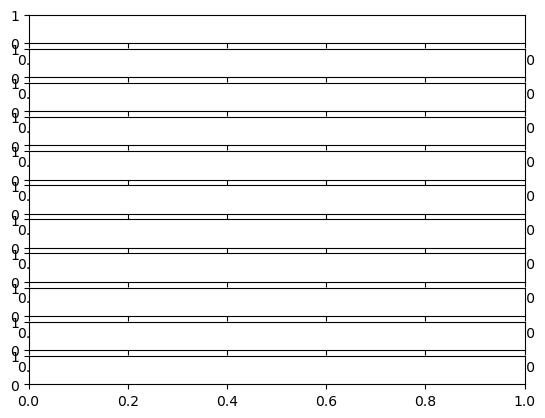

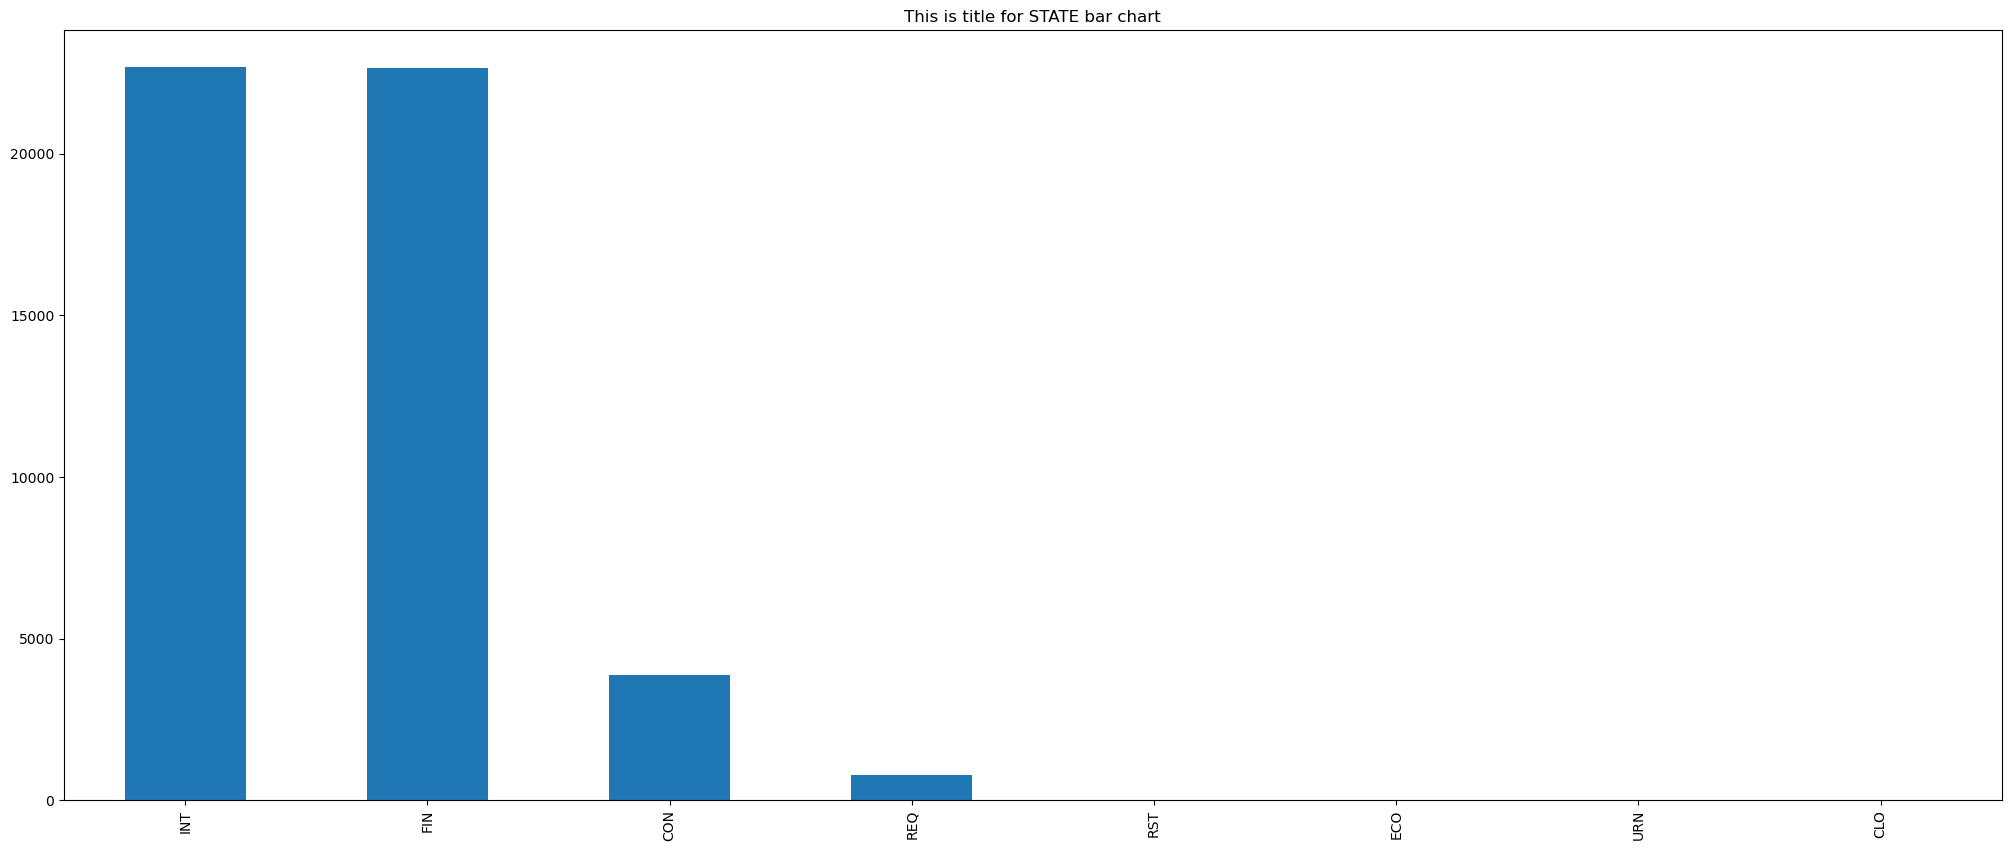

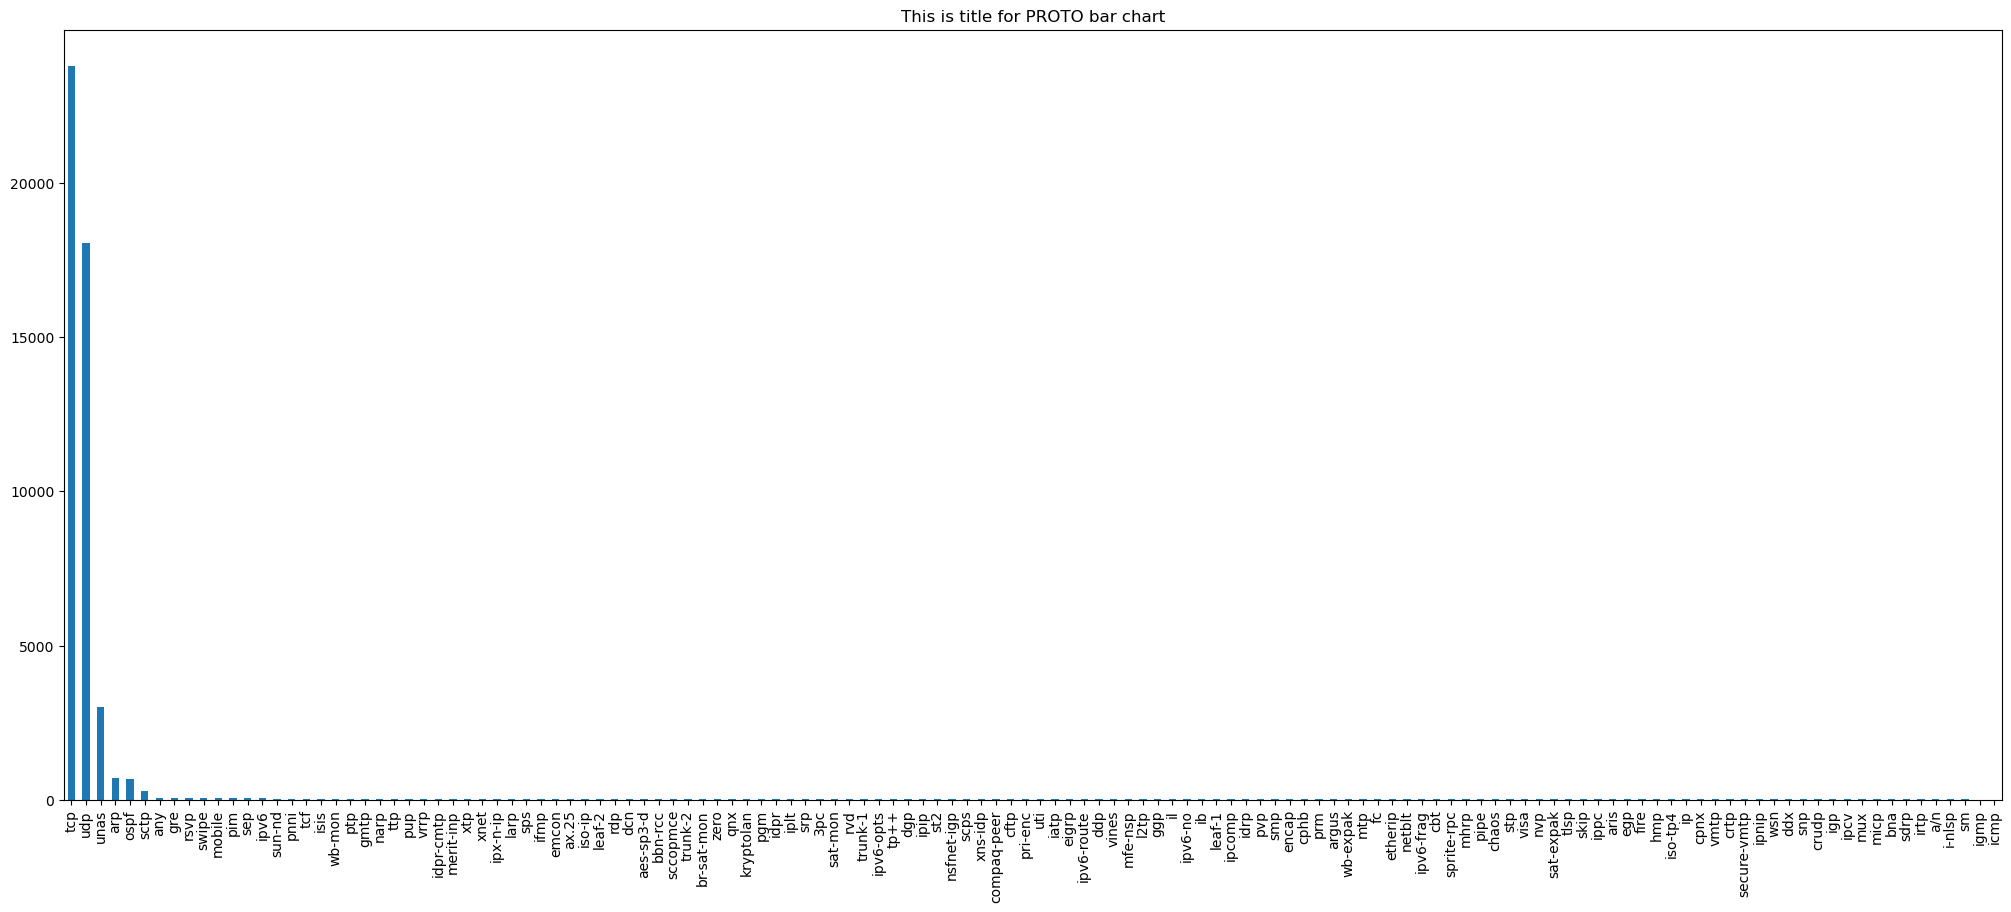

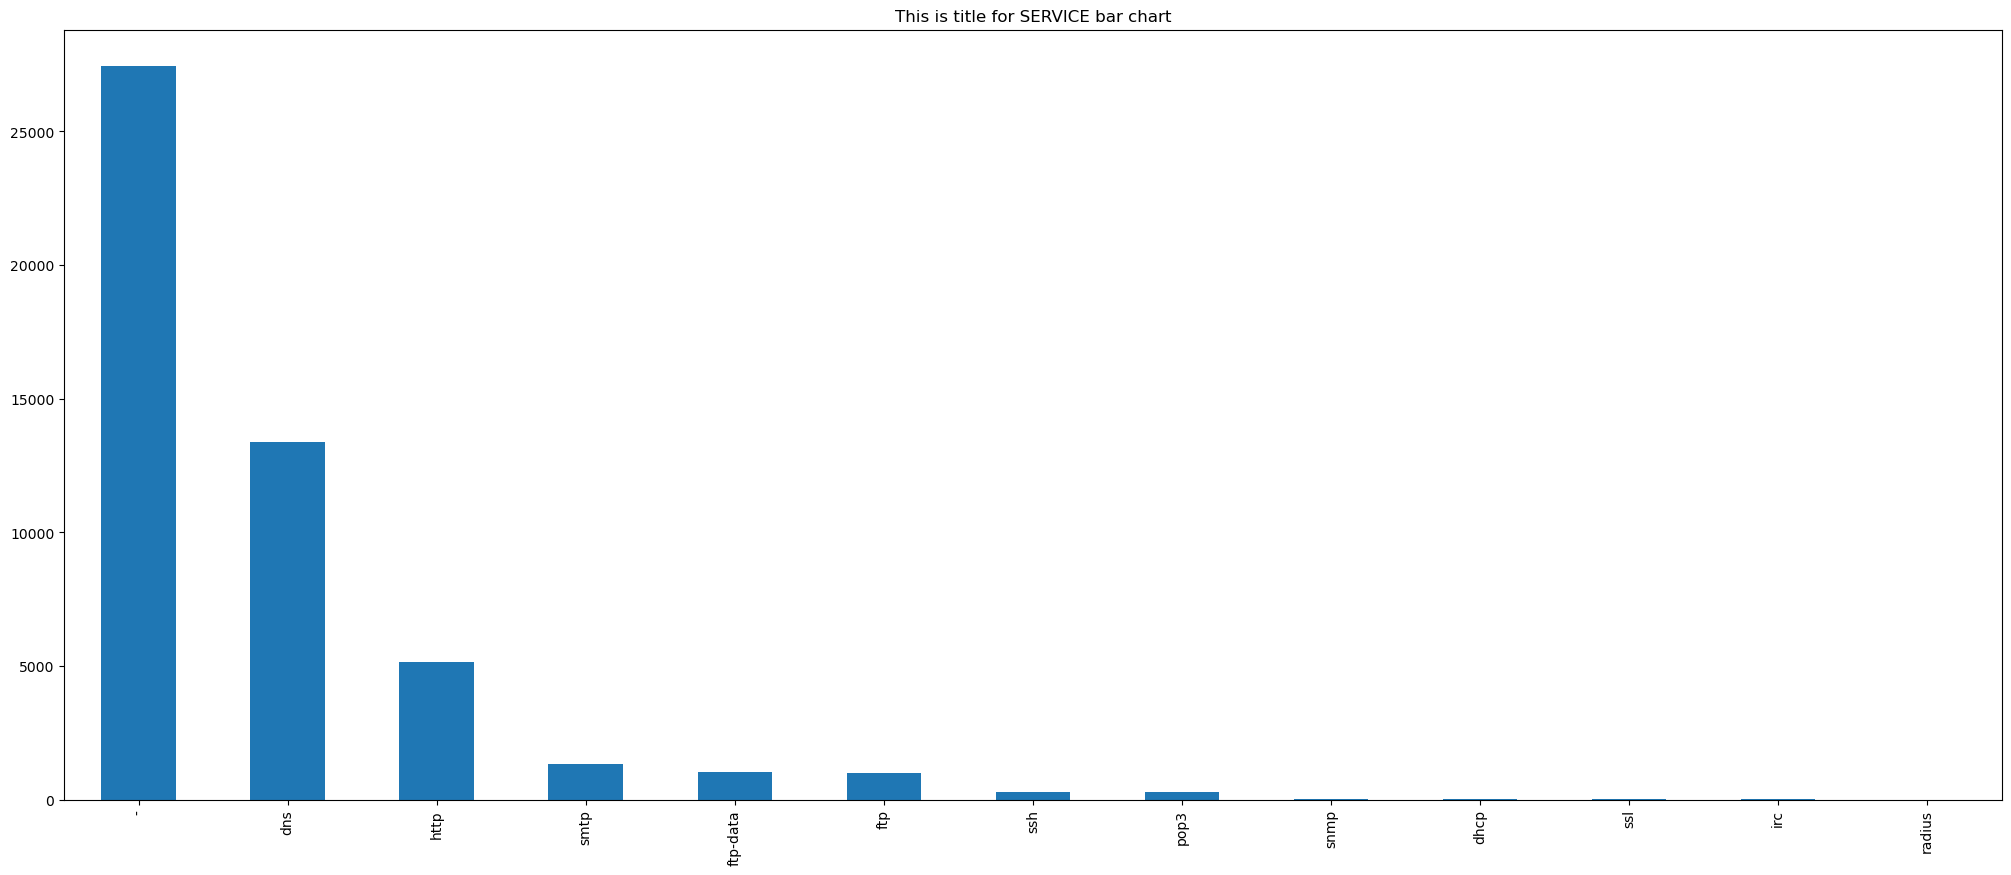

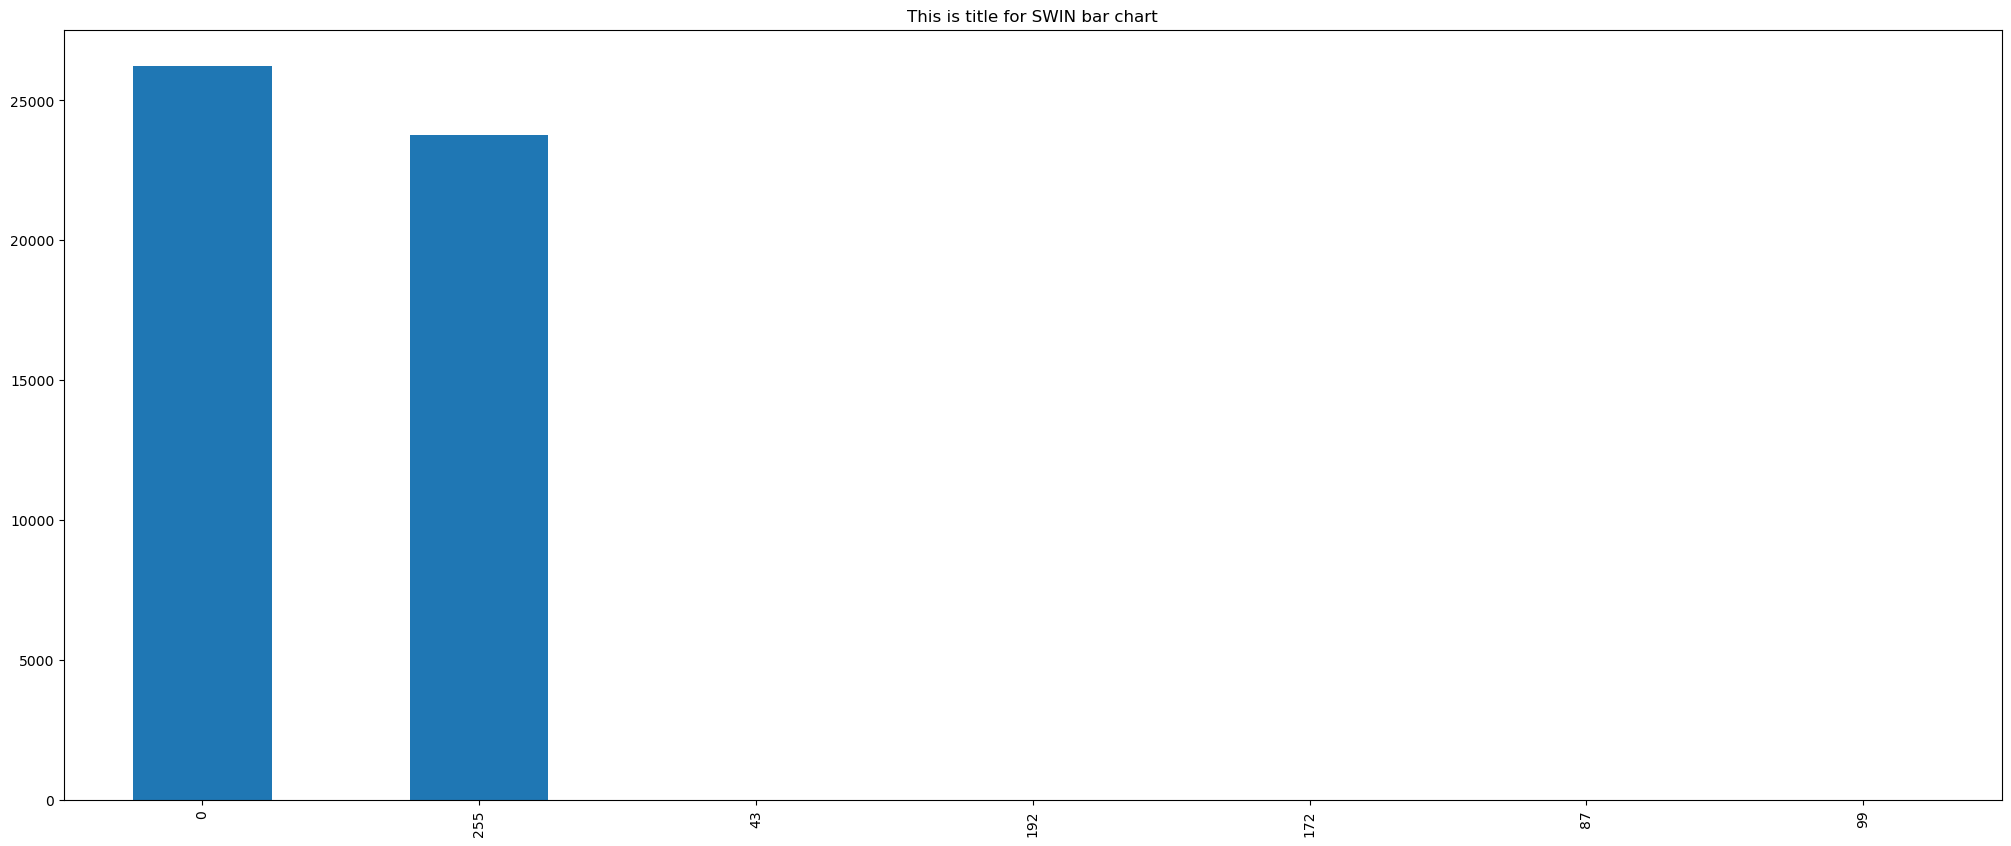

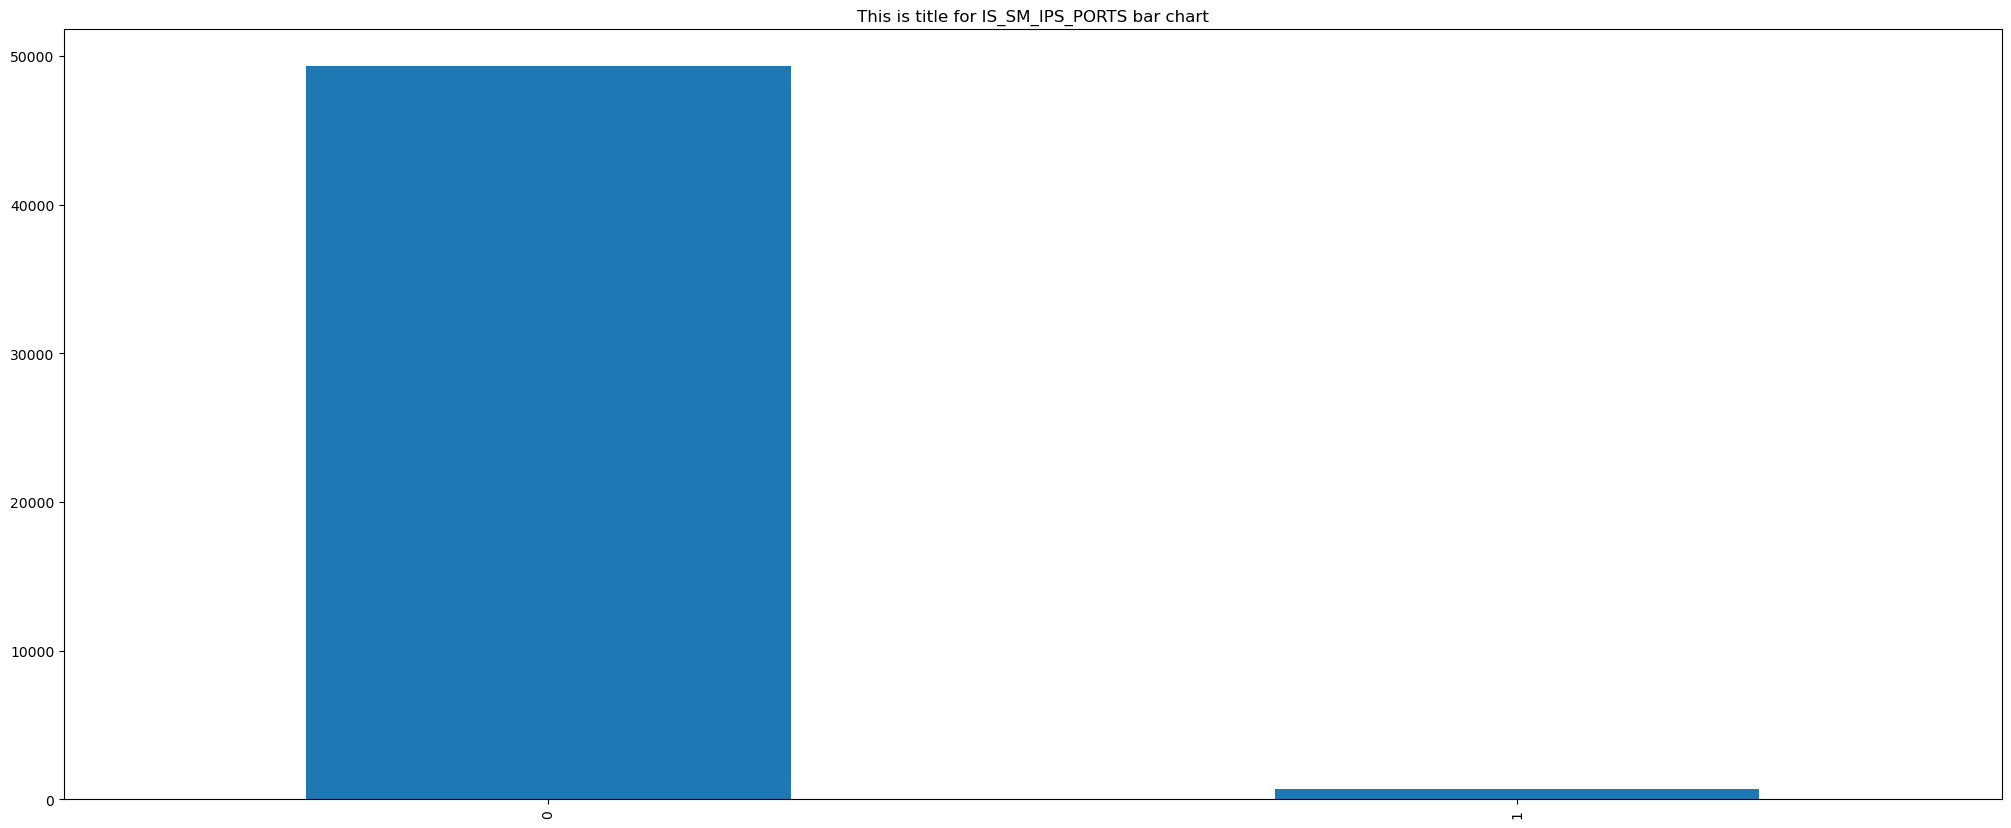

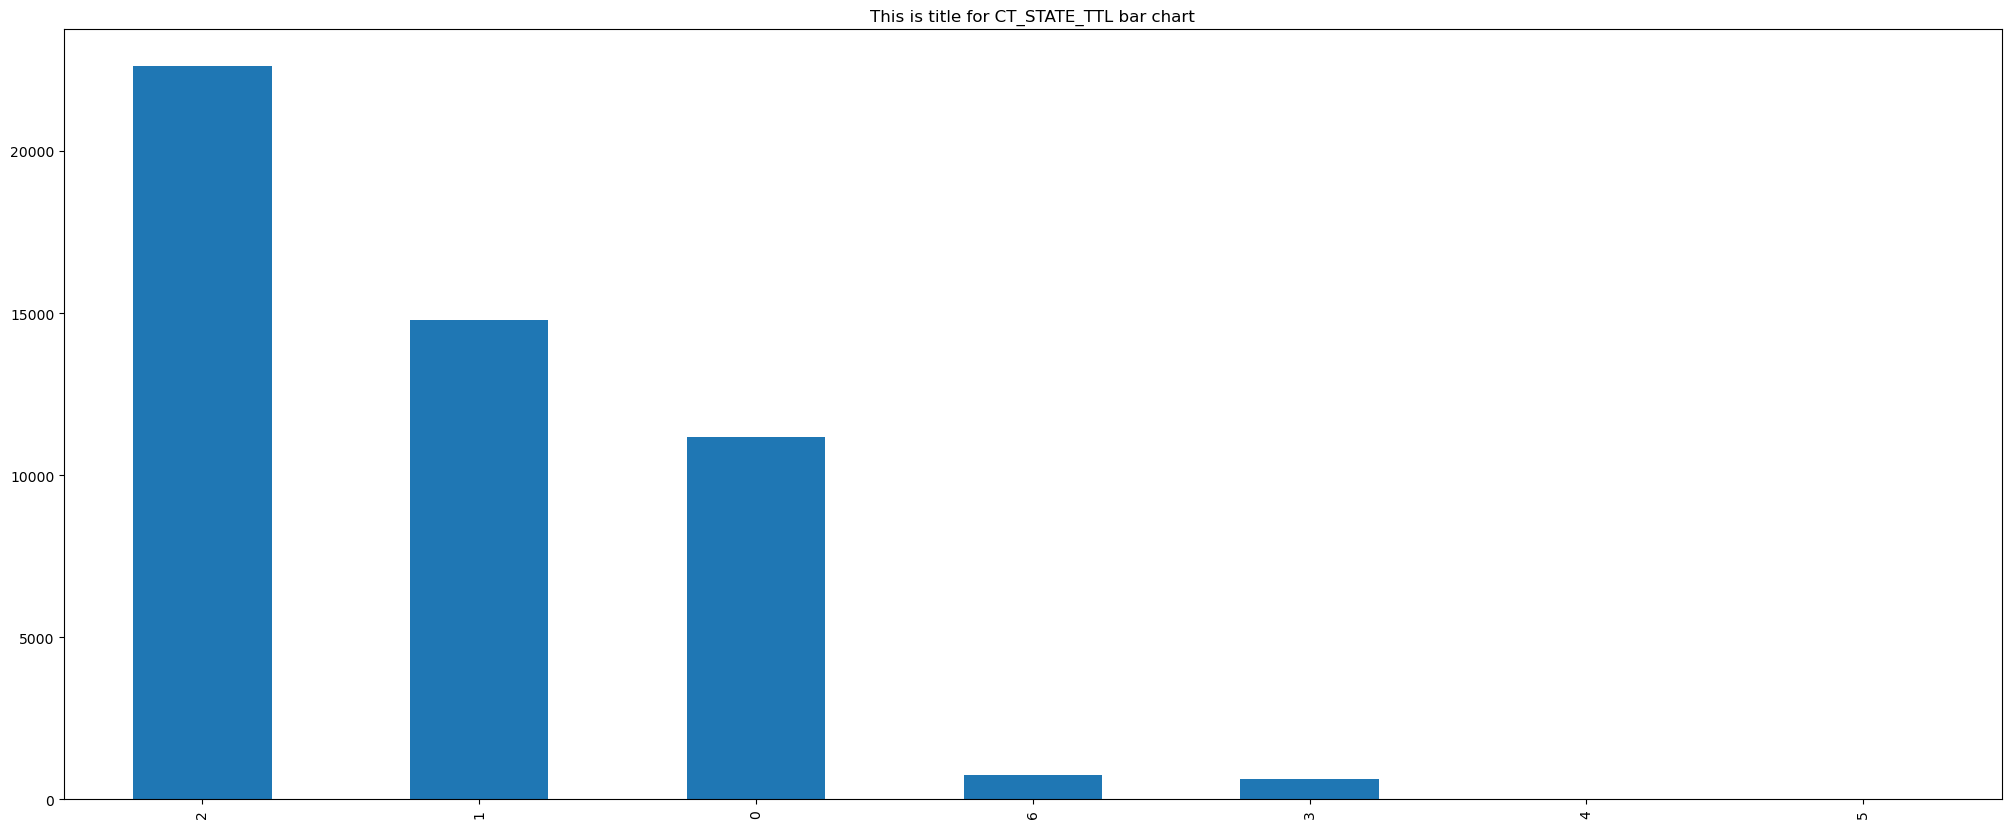

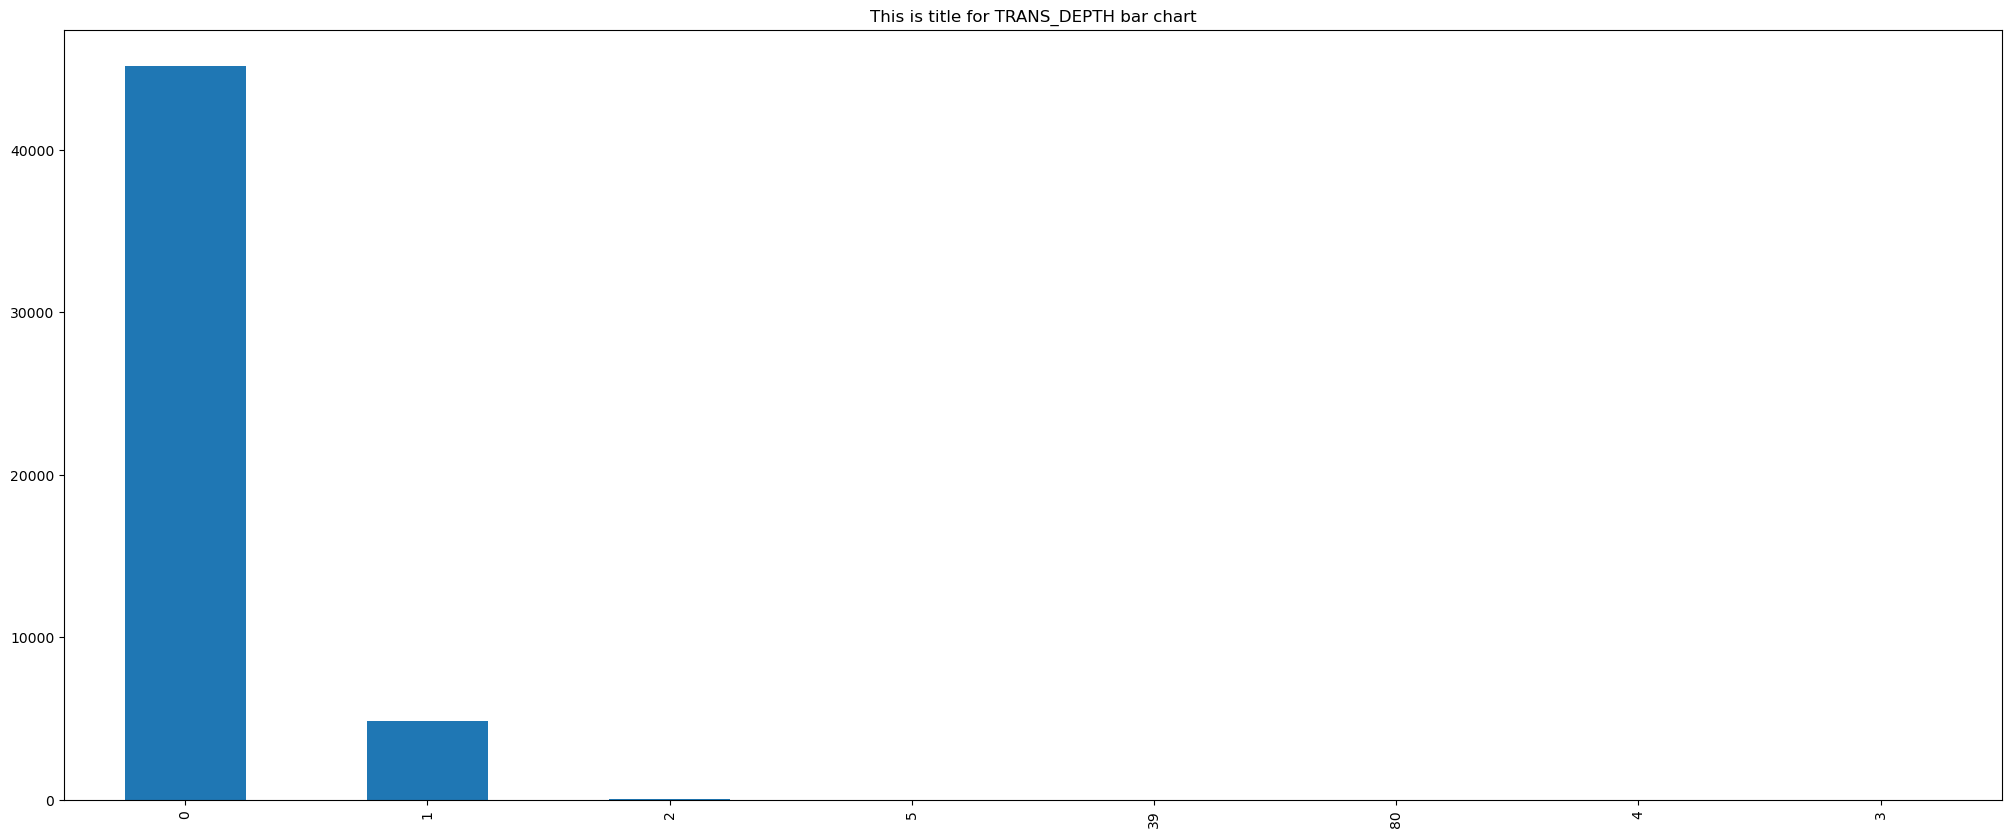

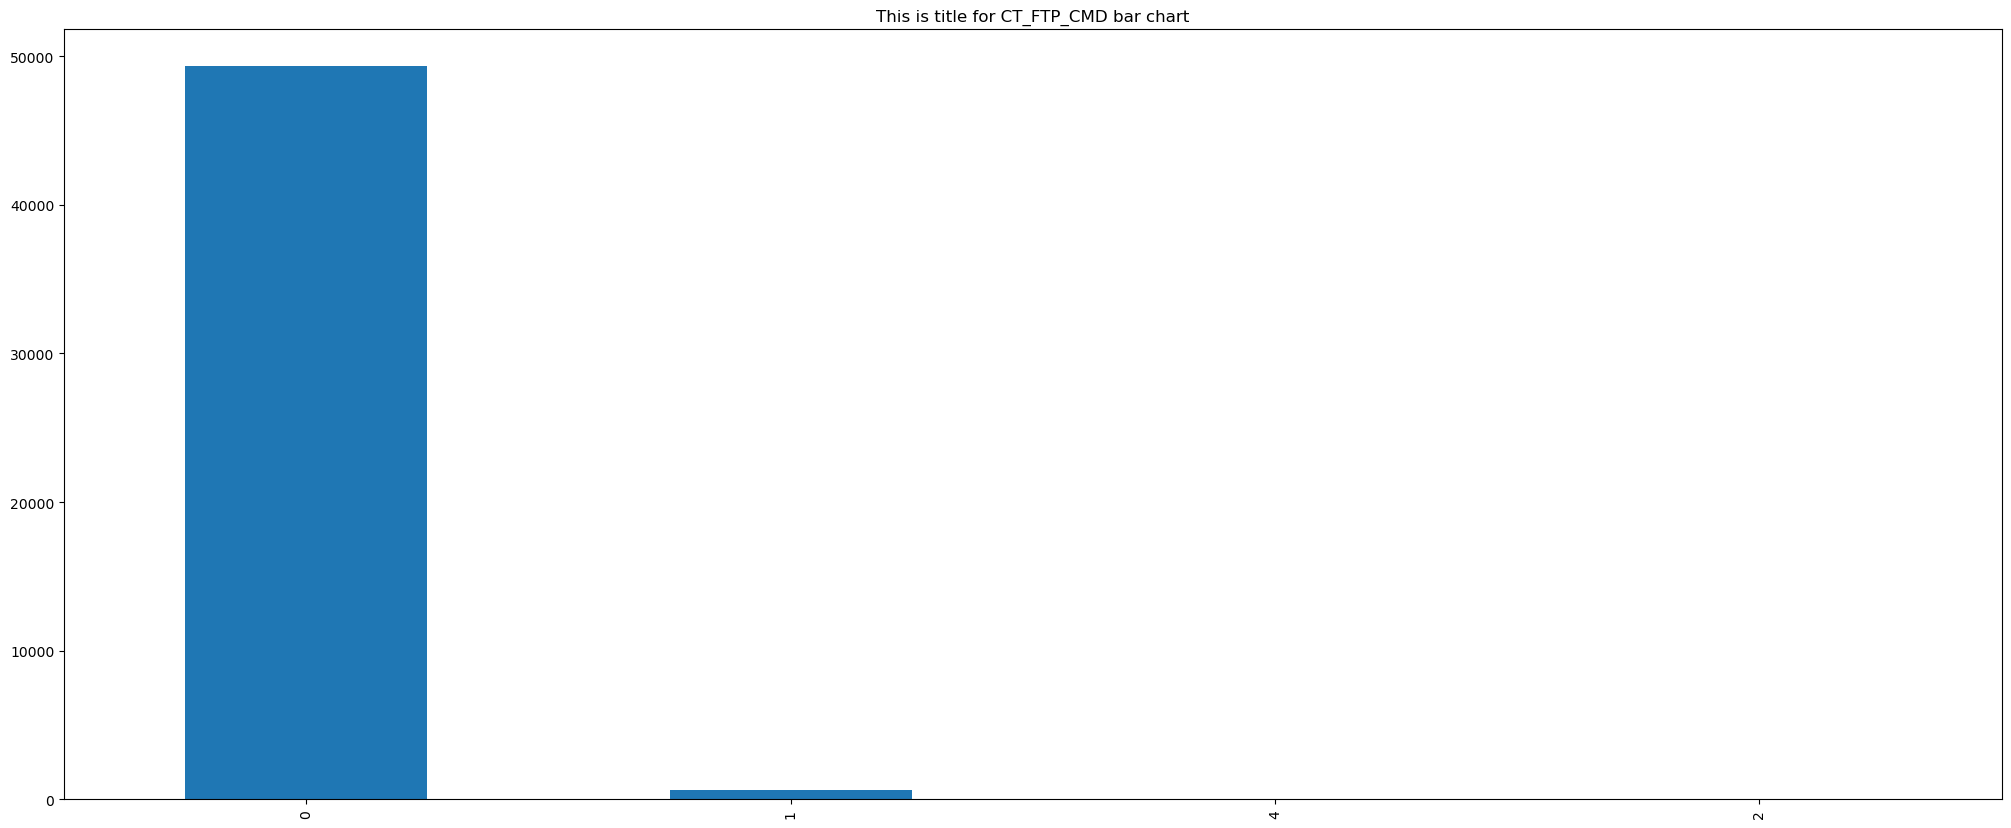

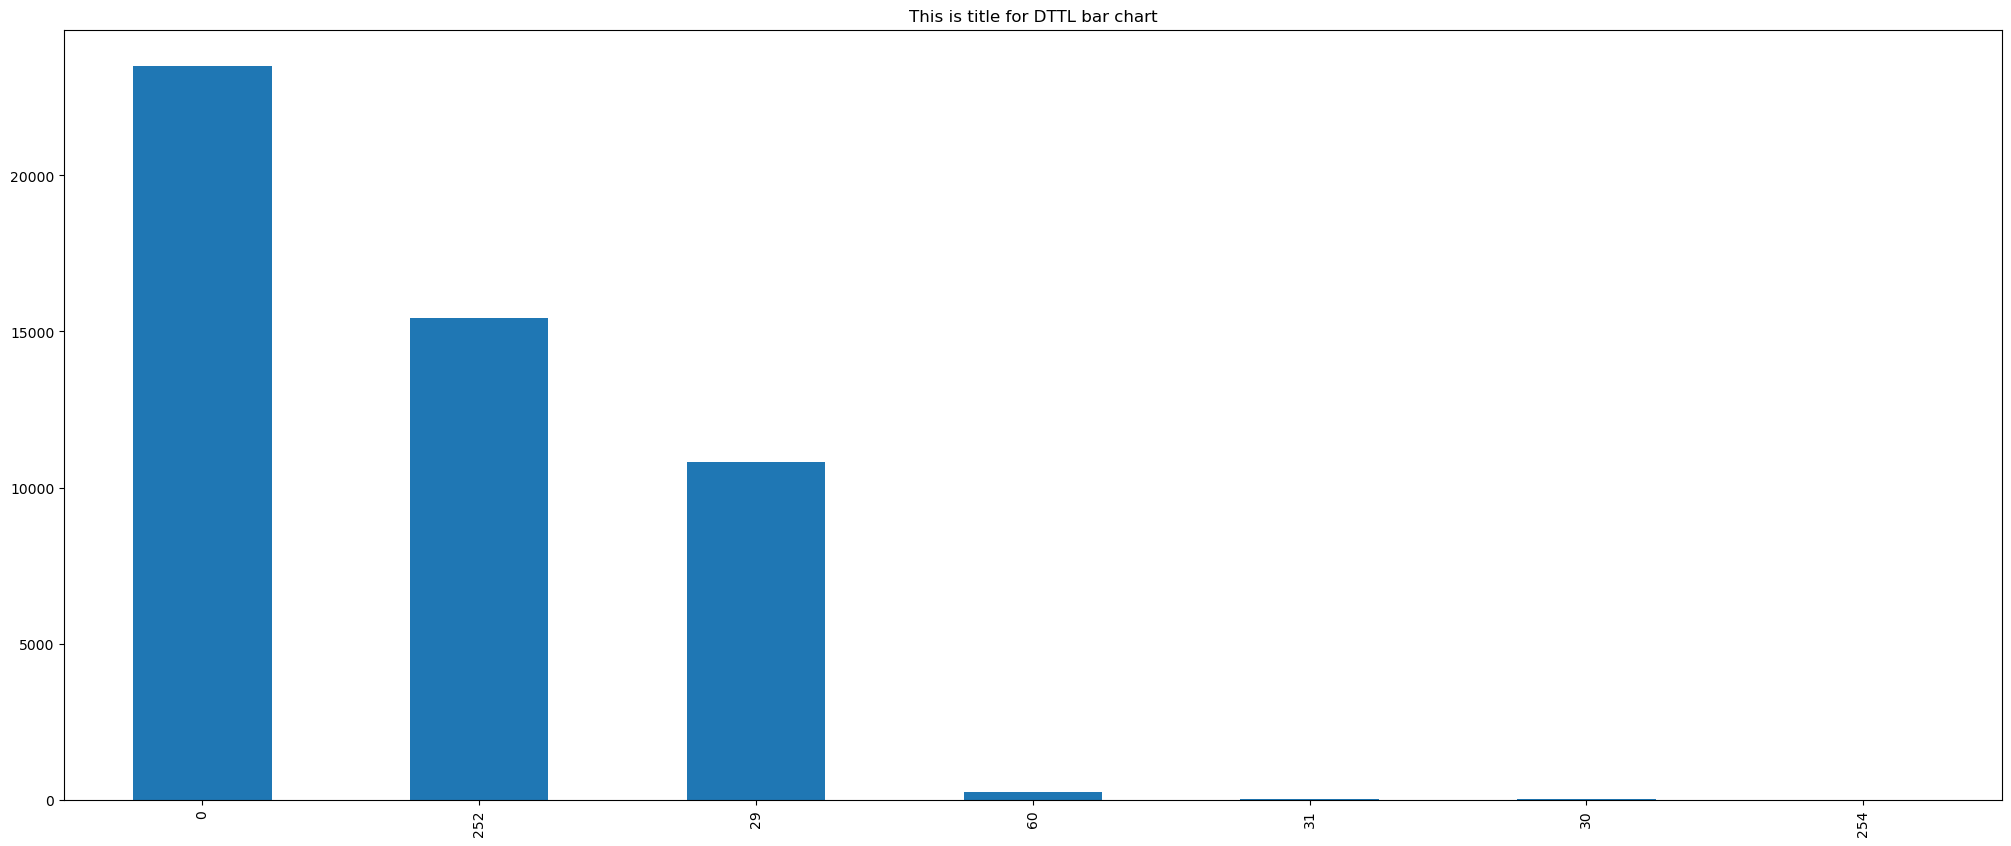

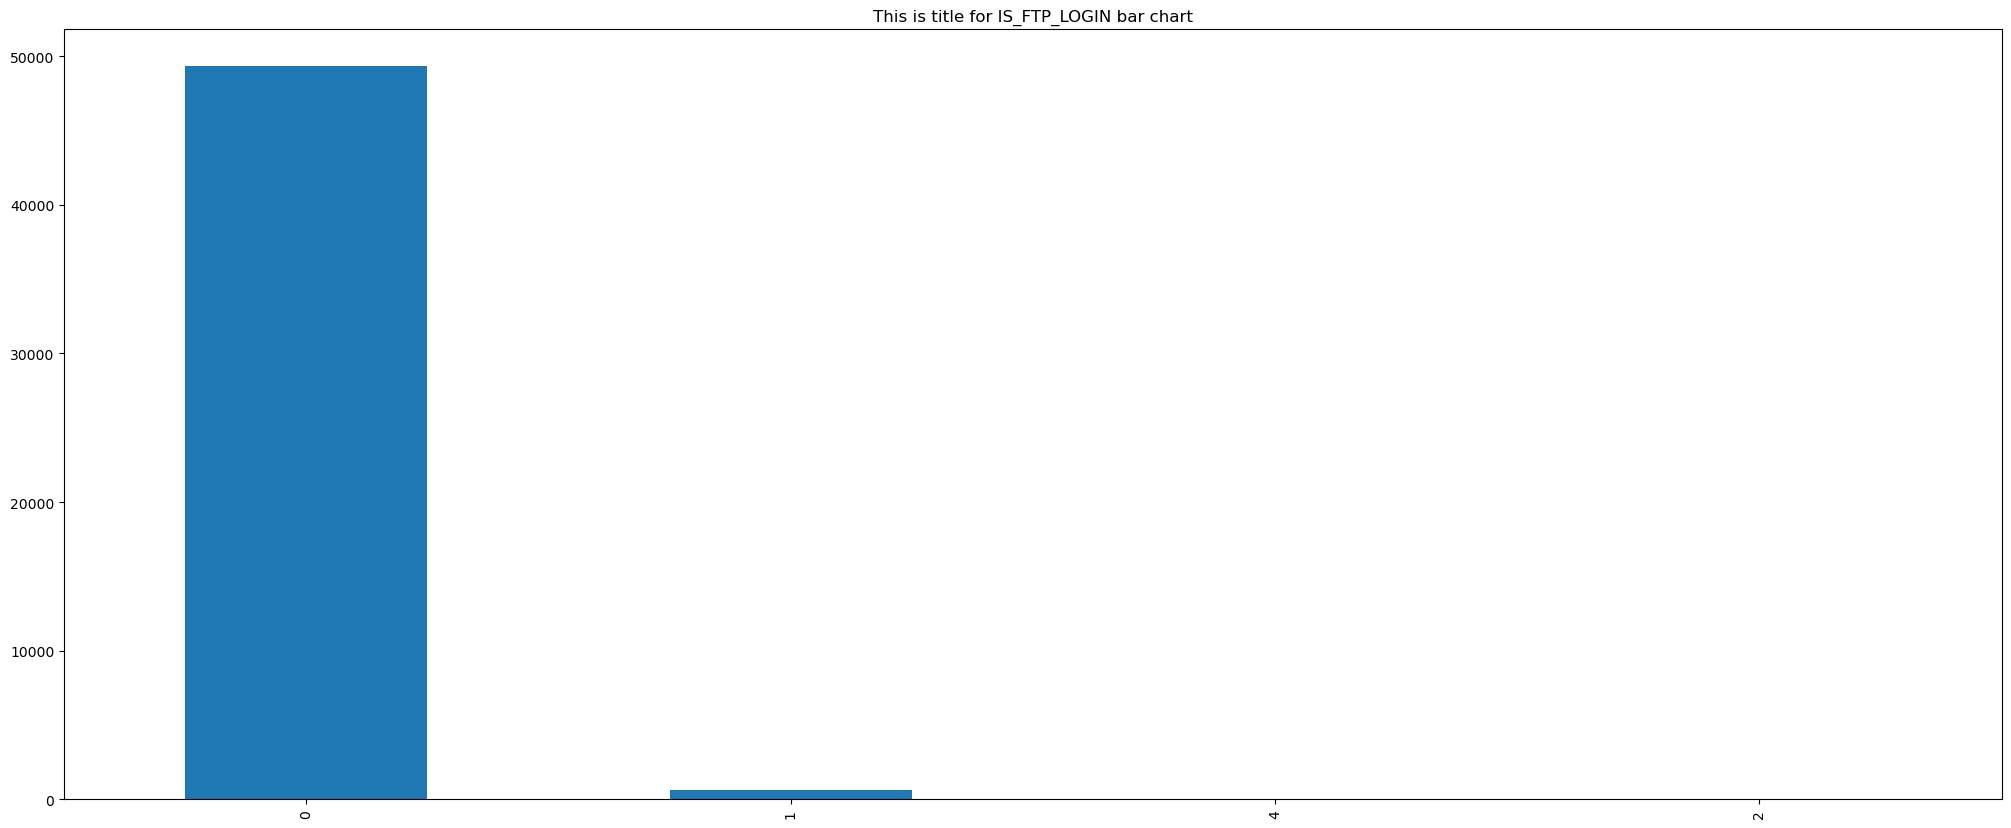

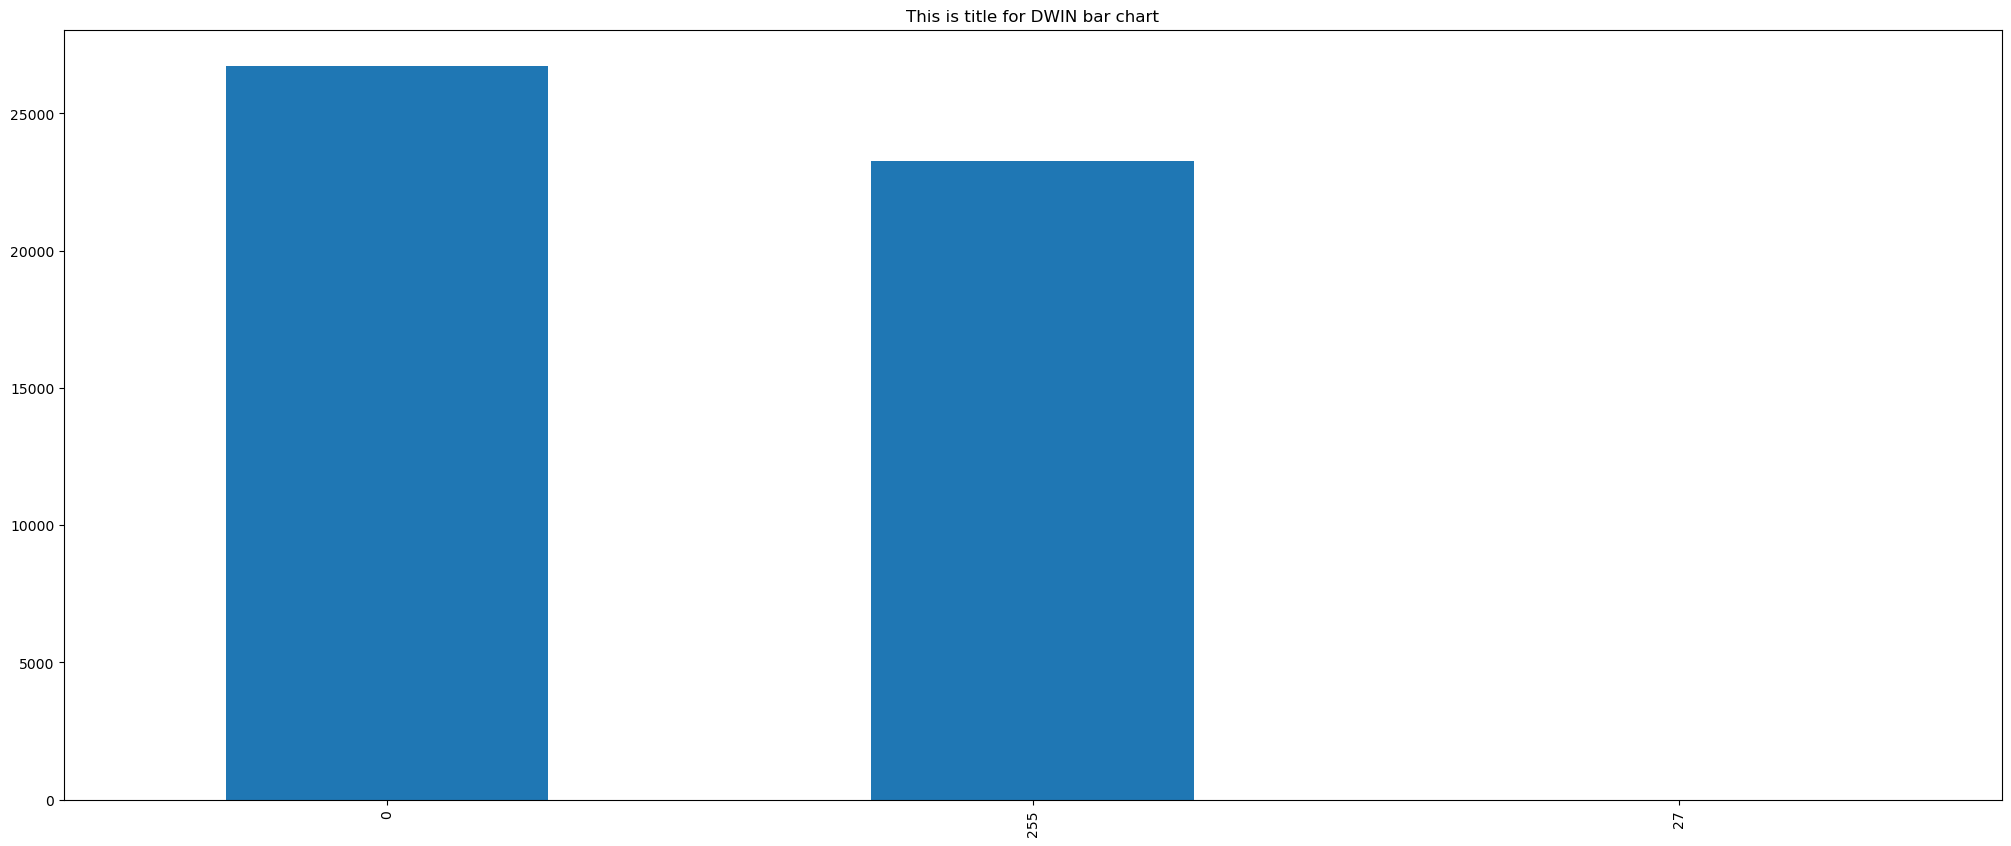

In [49]:
show_bar_plots_for_all_categorical_plots(eda_unsw_nb15_df, eda_unsw_nb15_categorical_features)

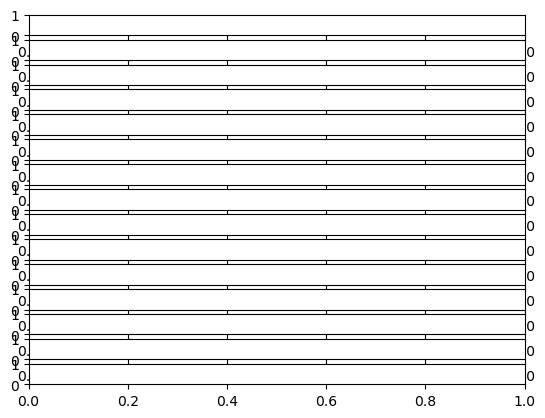

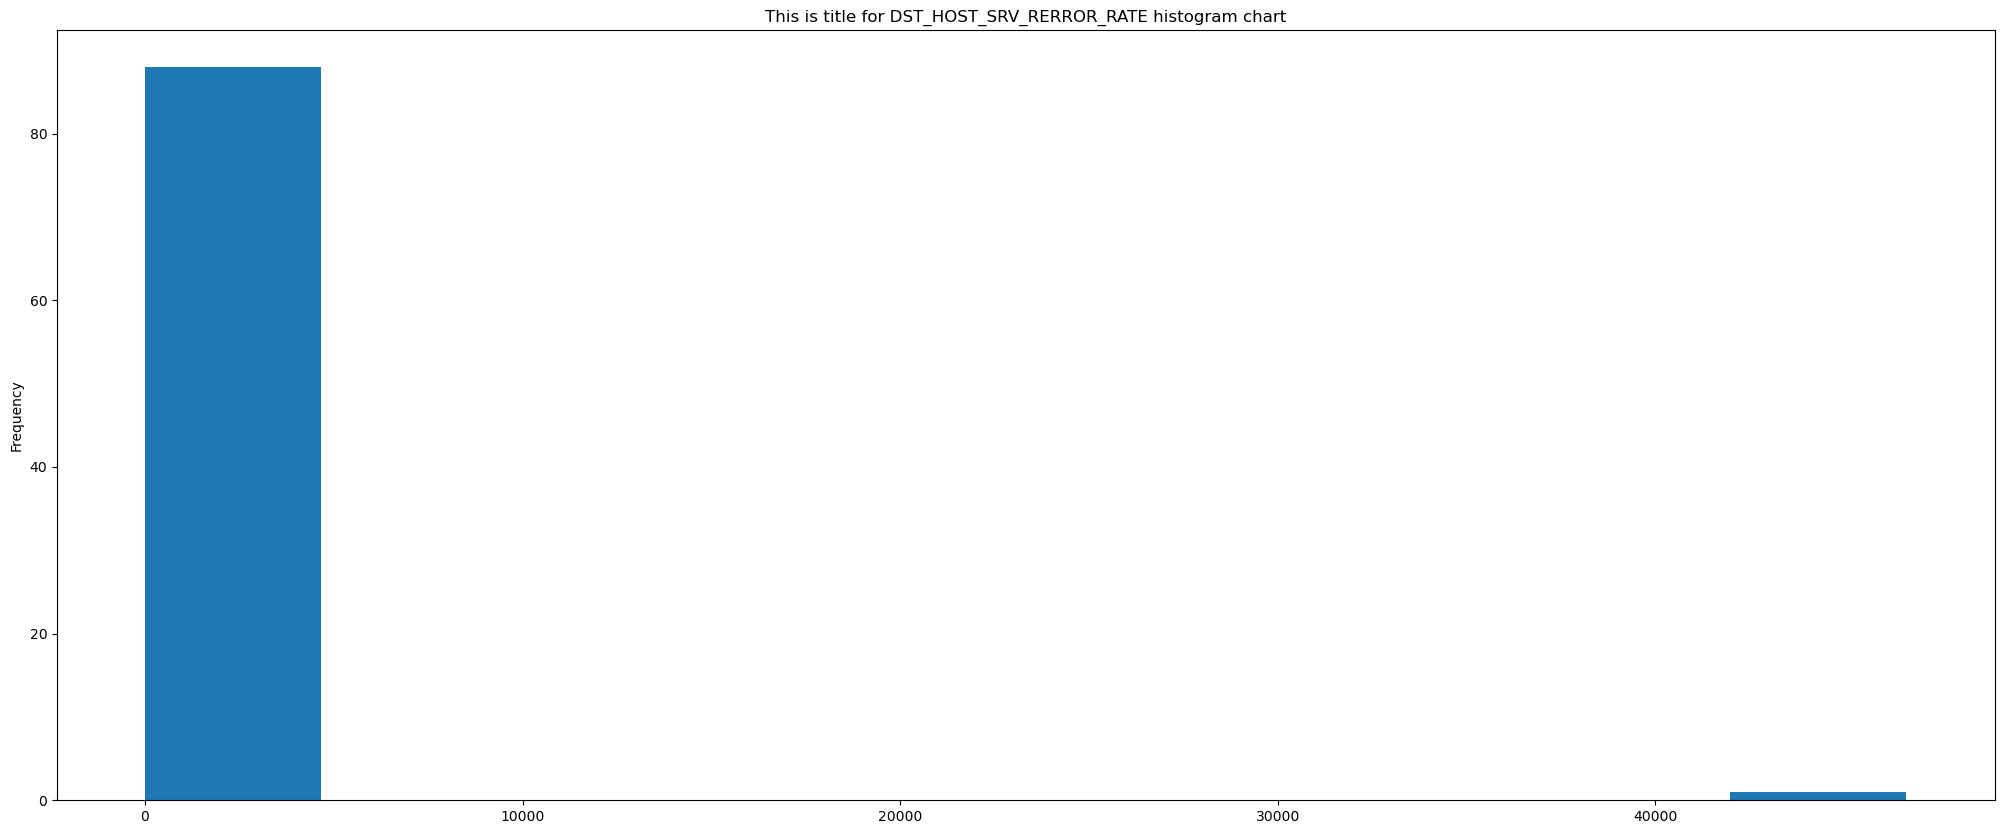

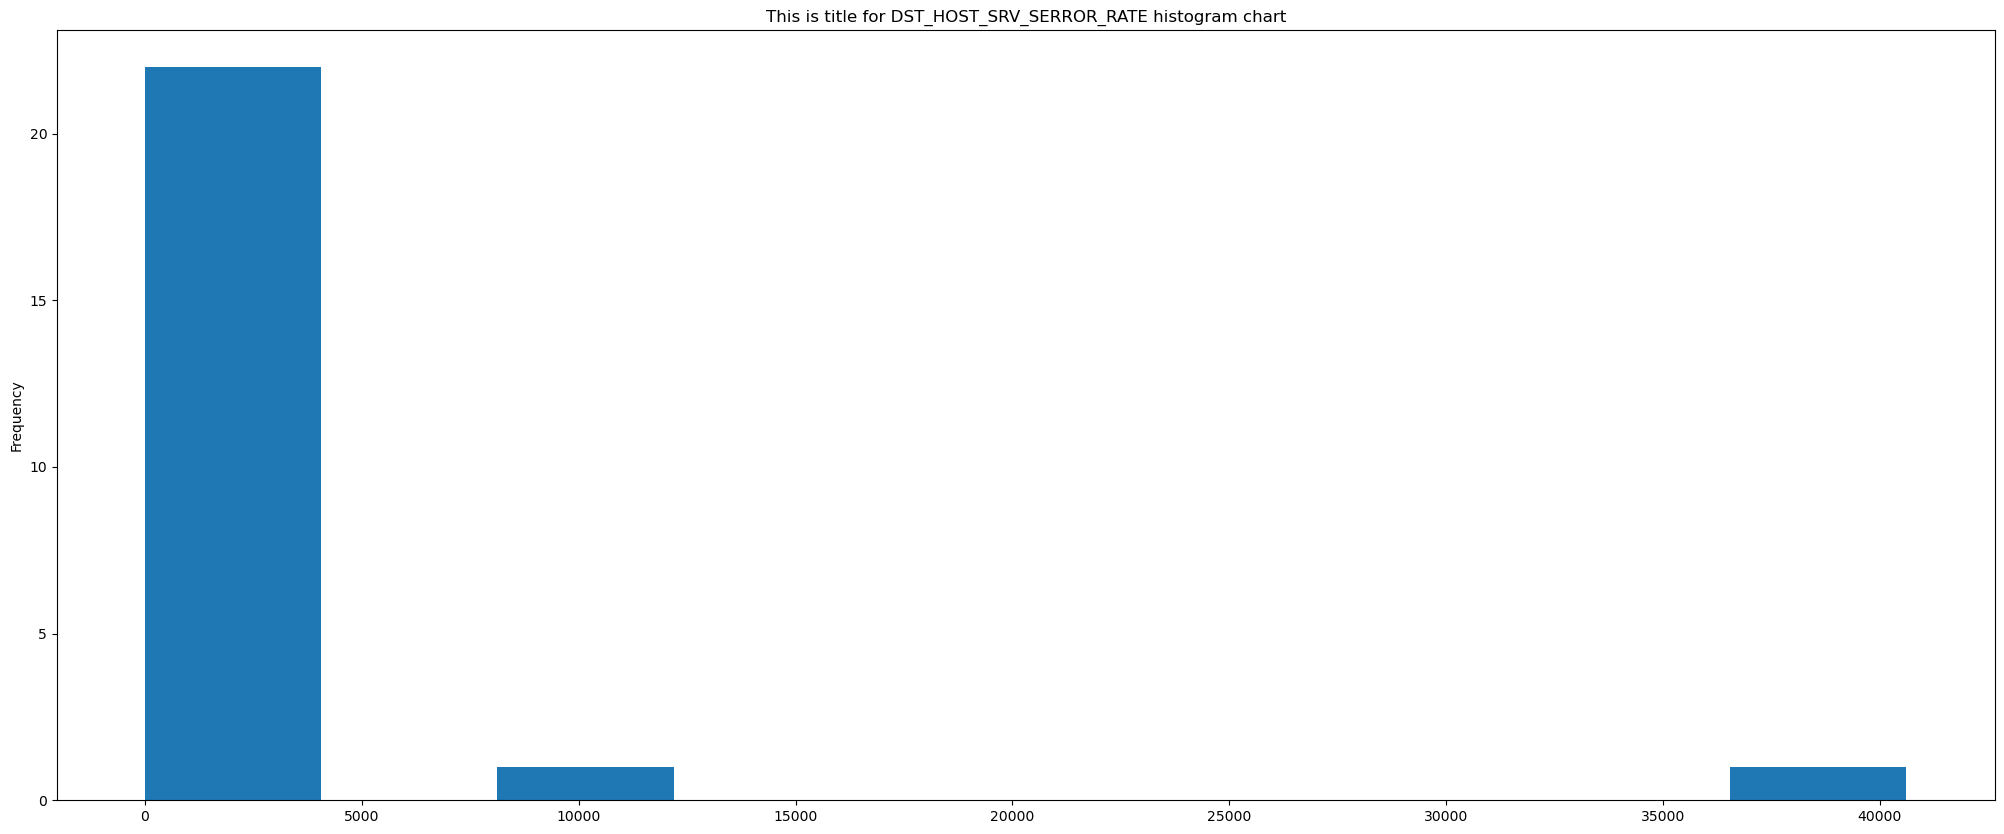

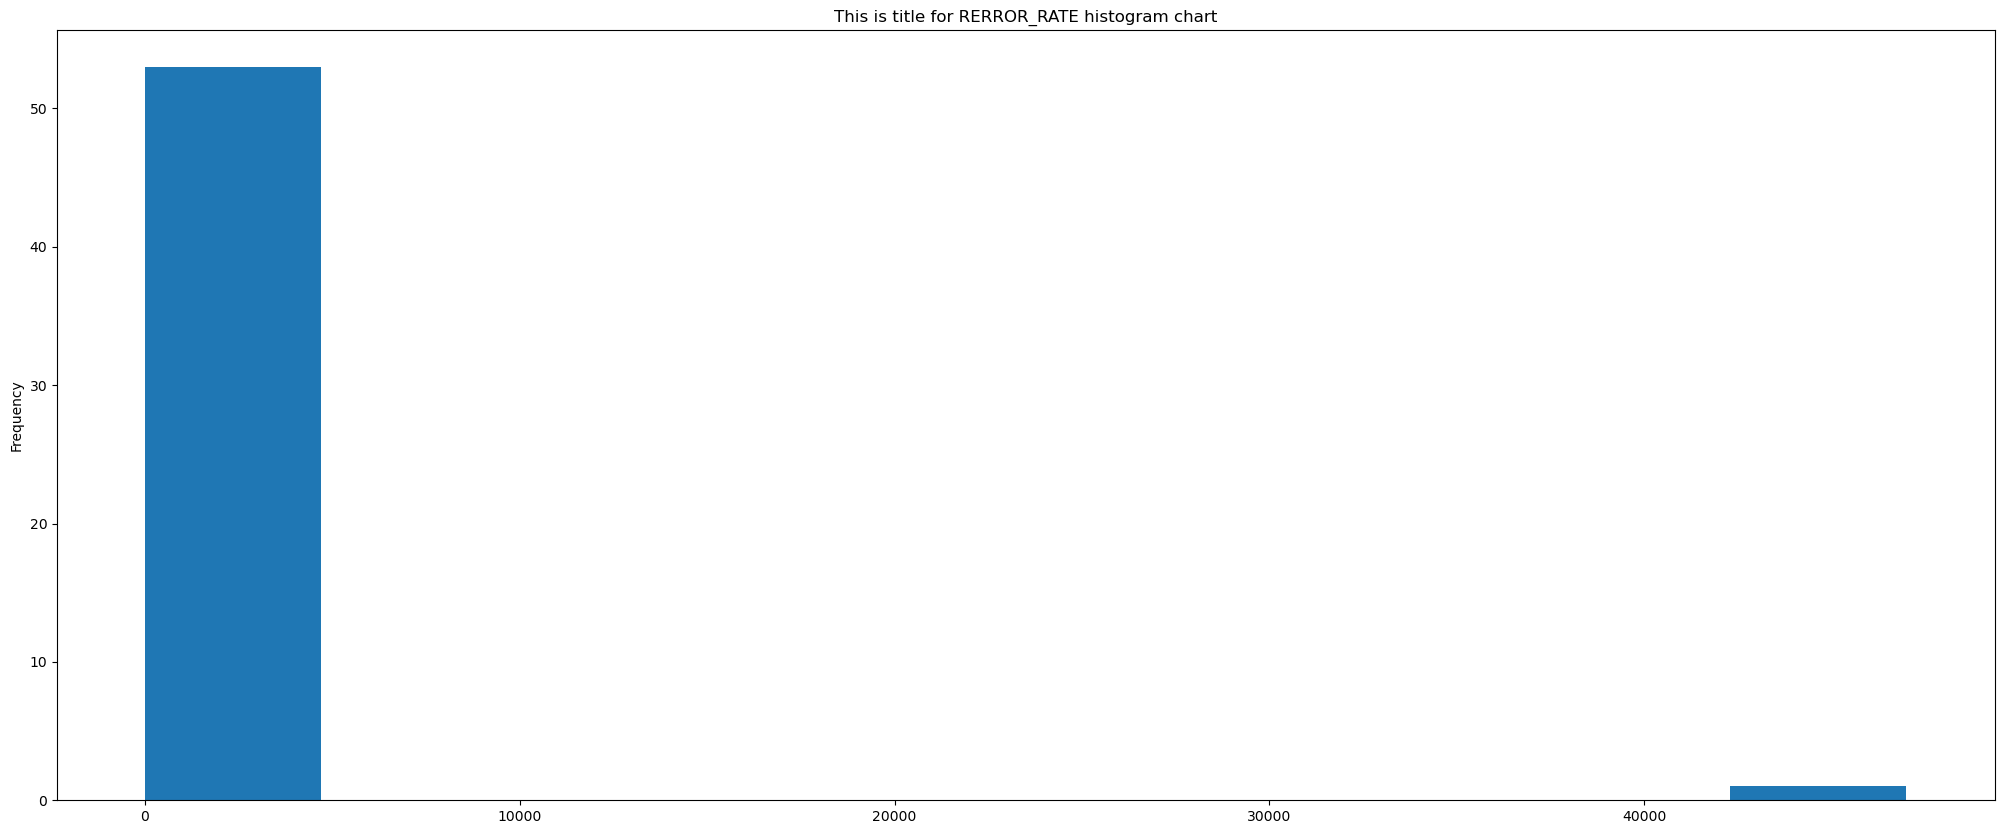

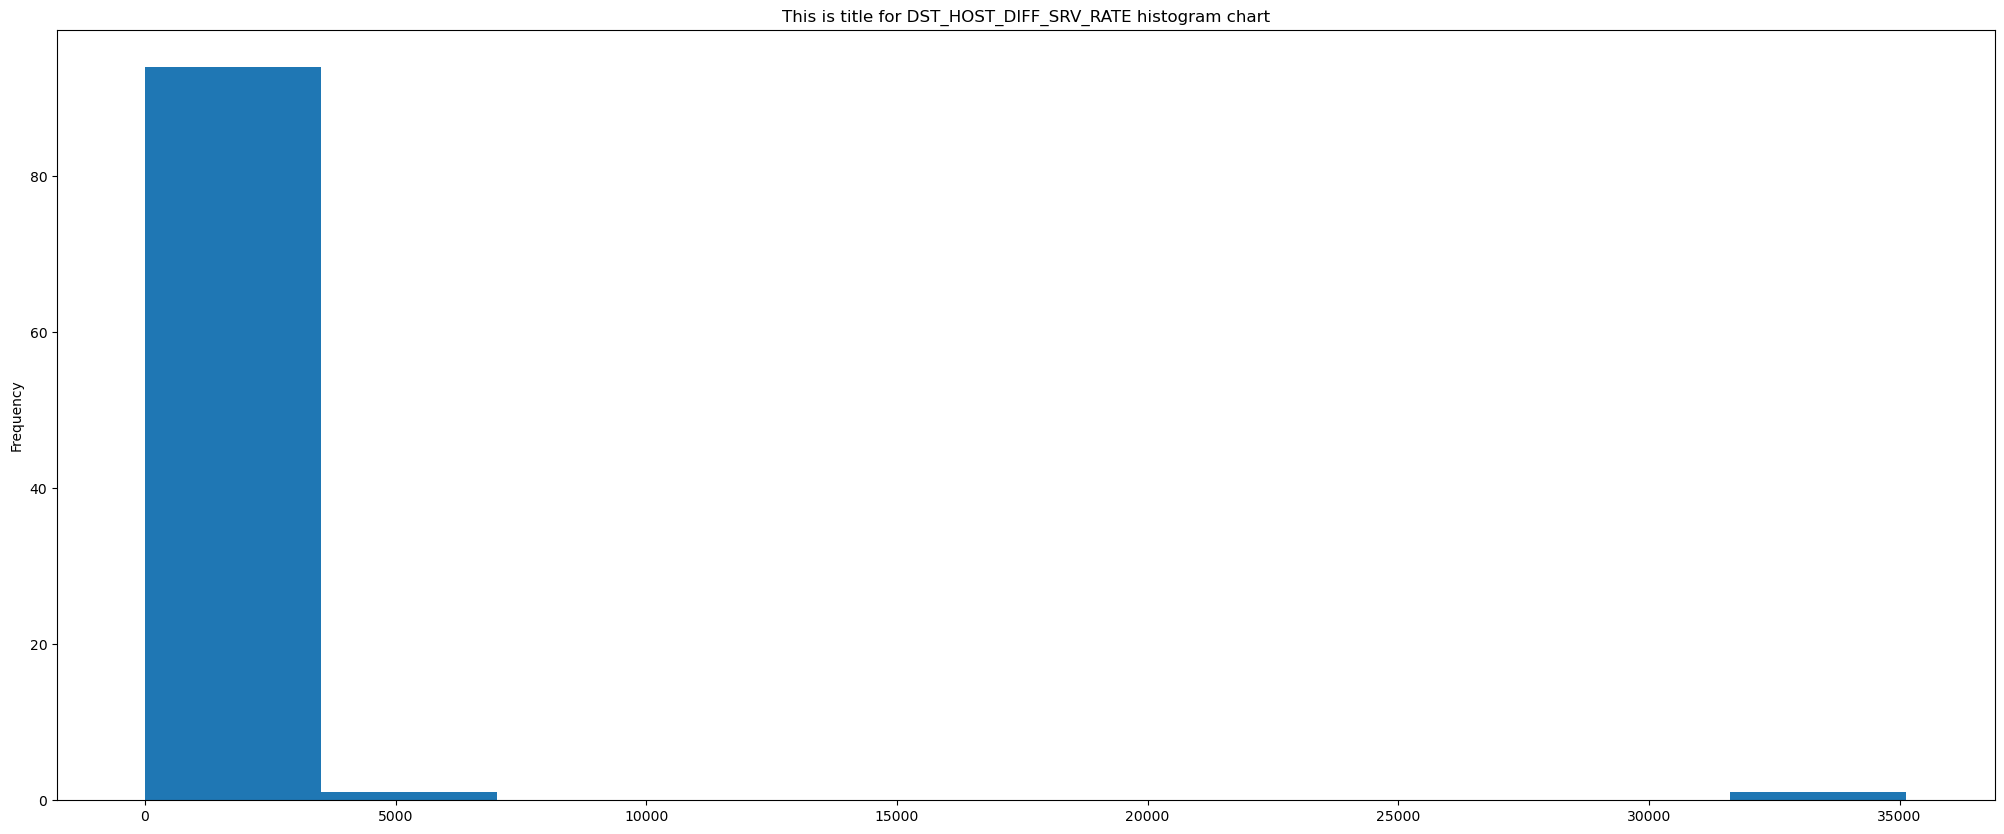

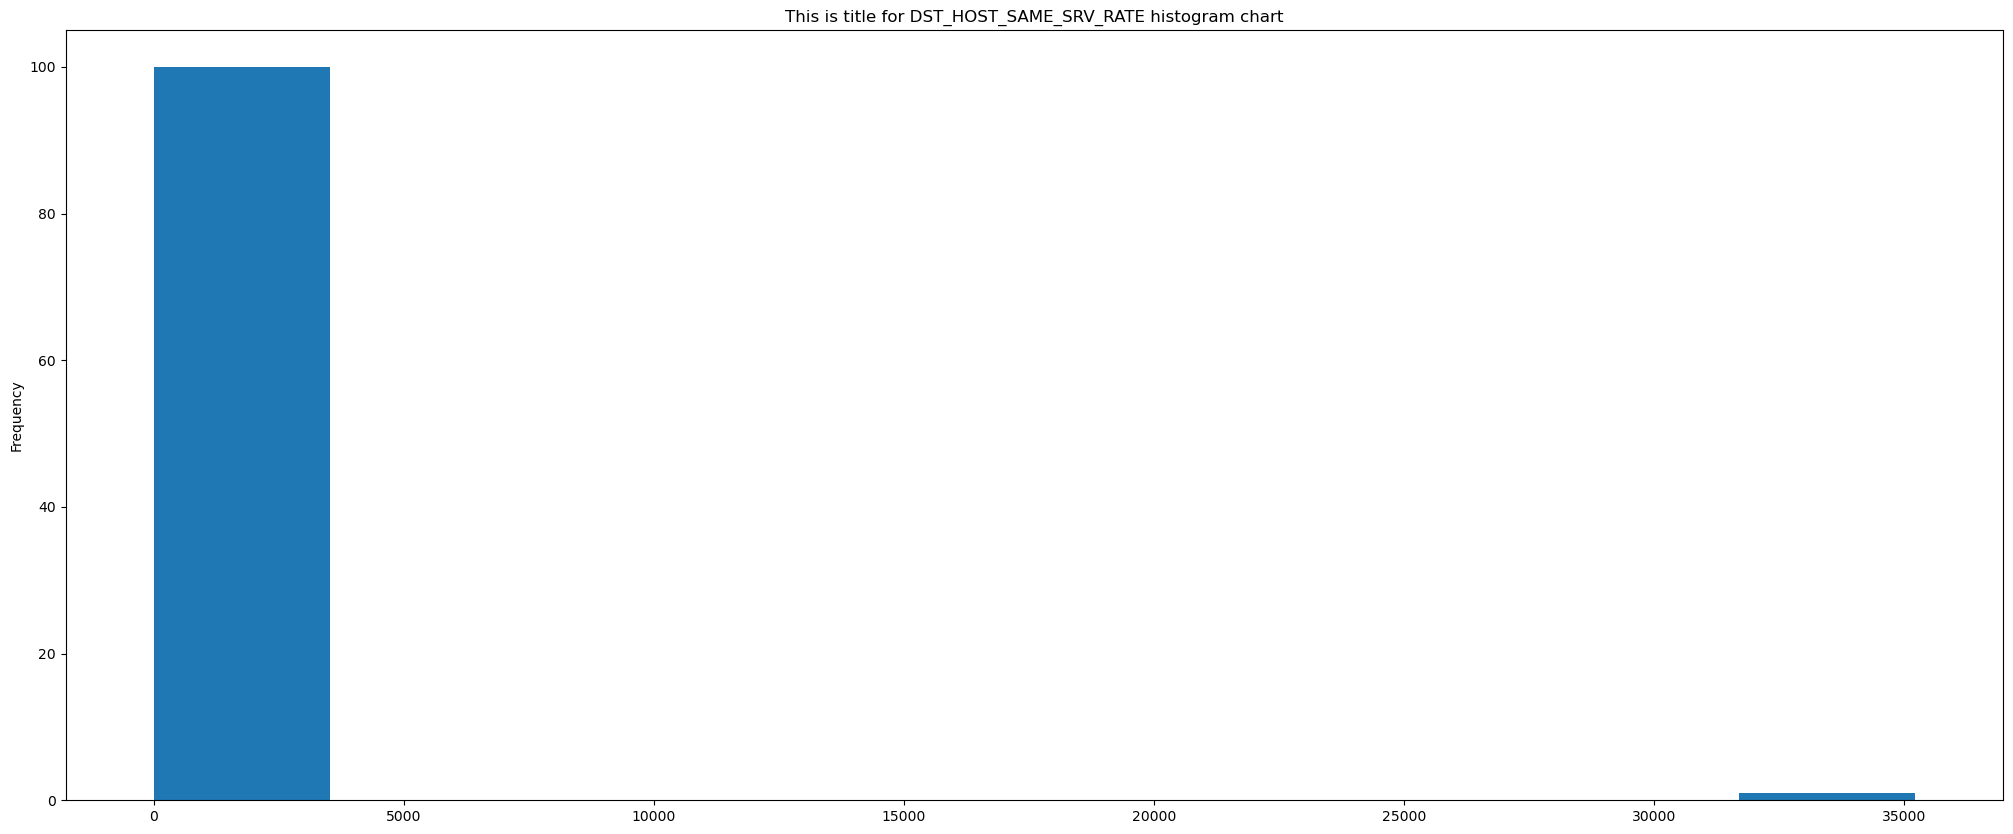

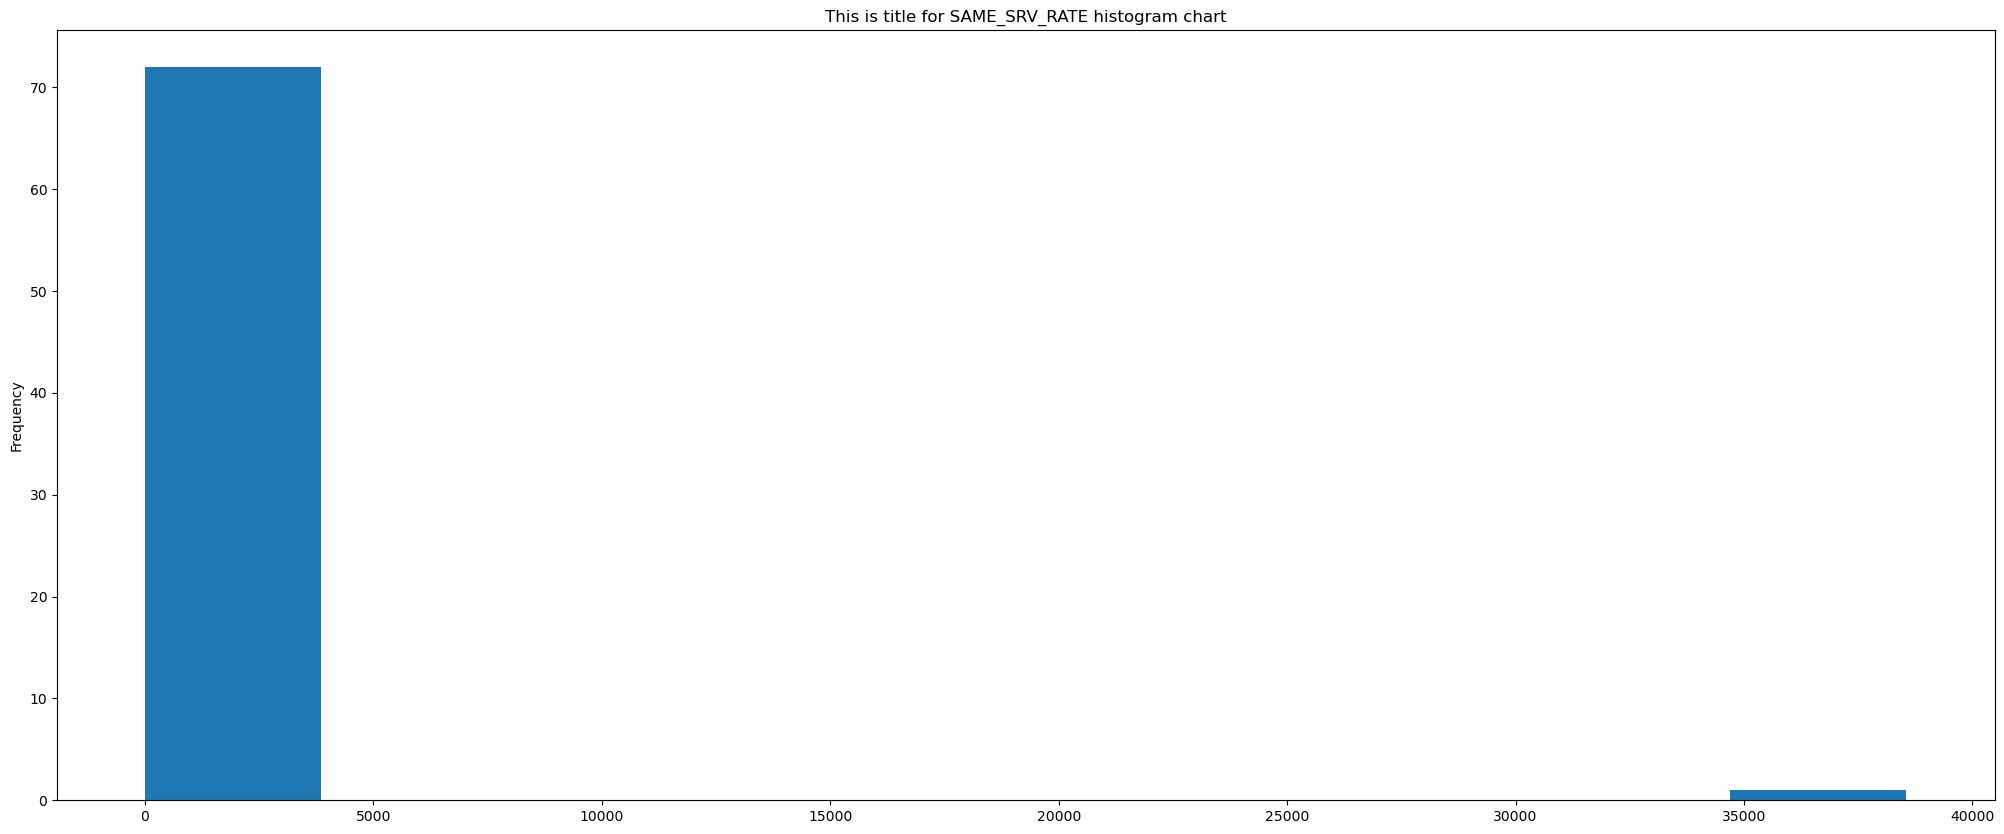

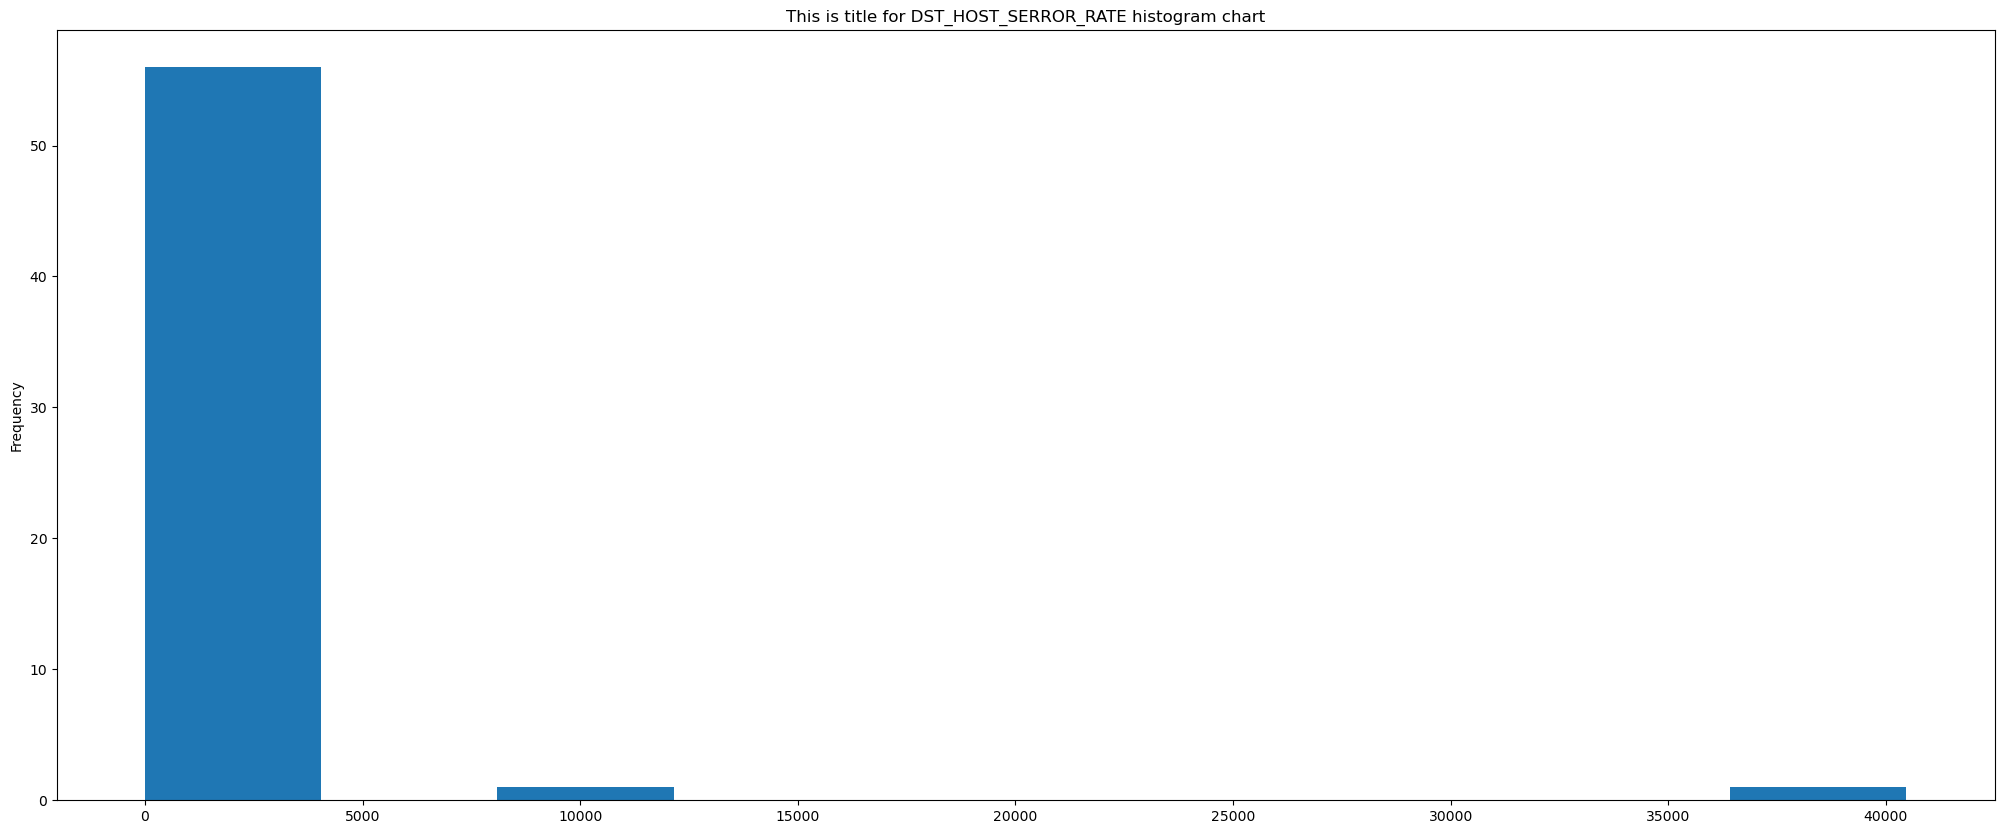

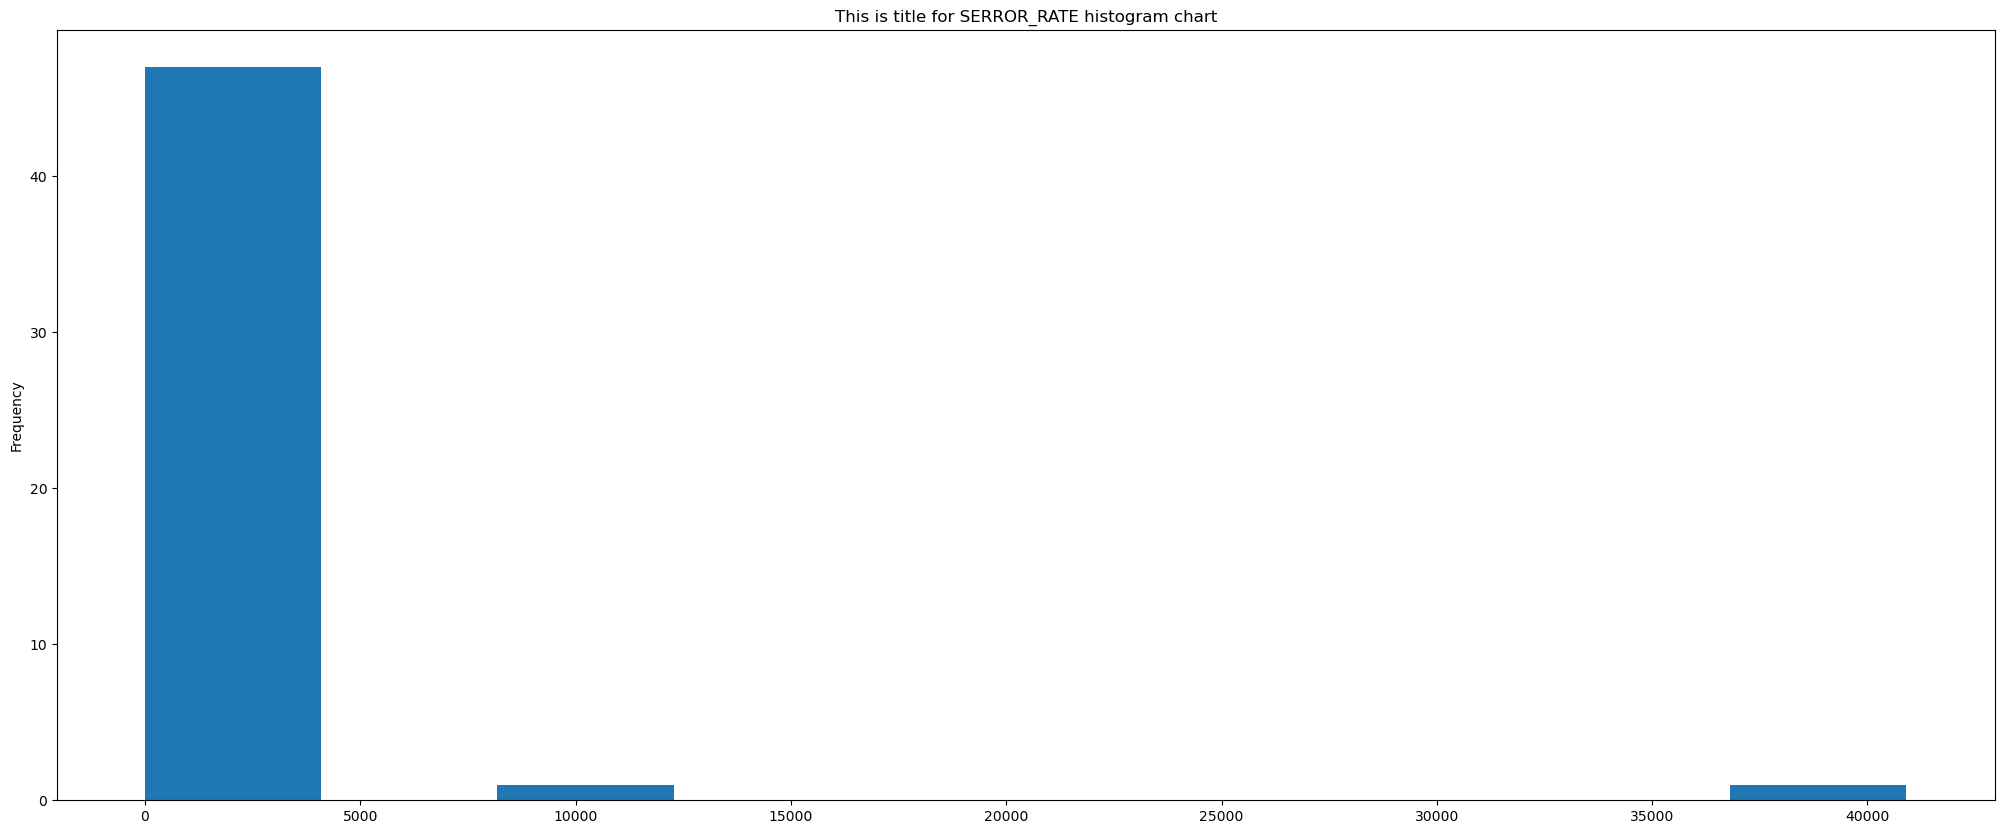

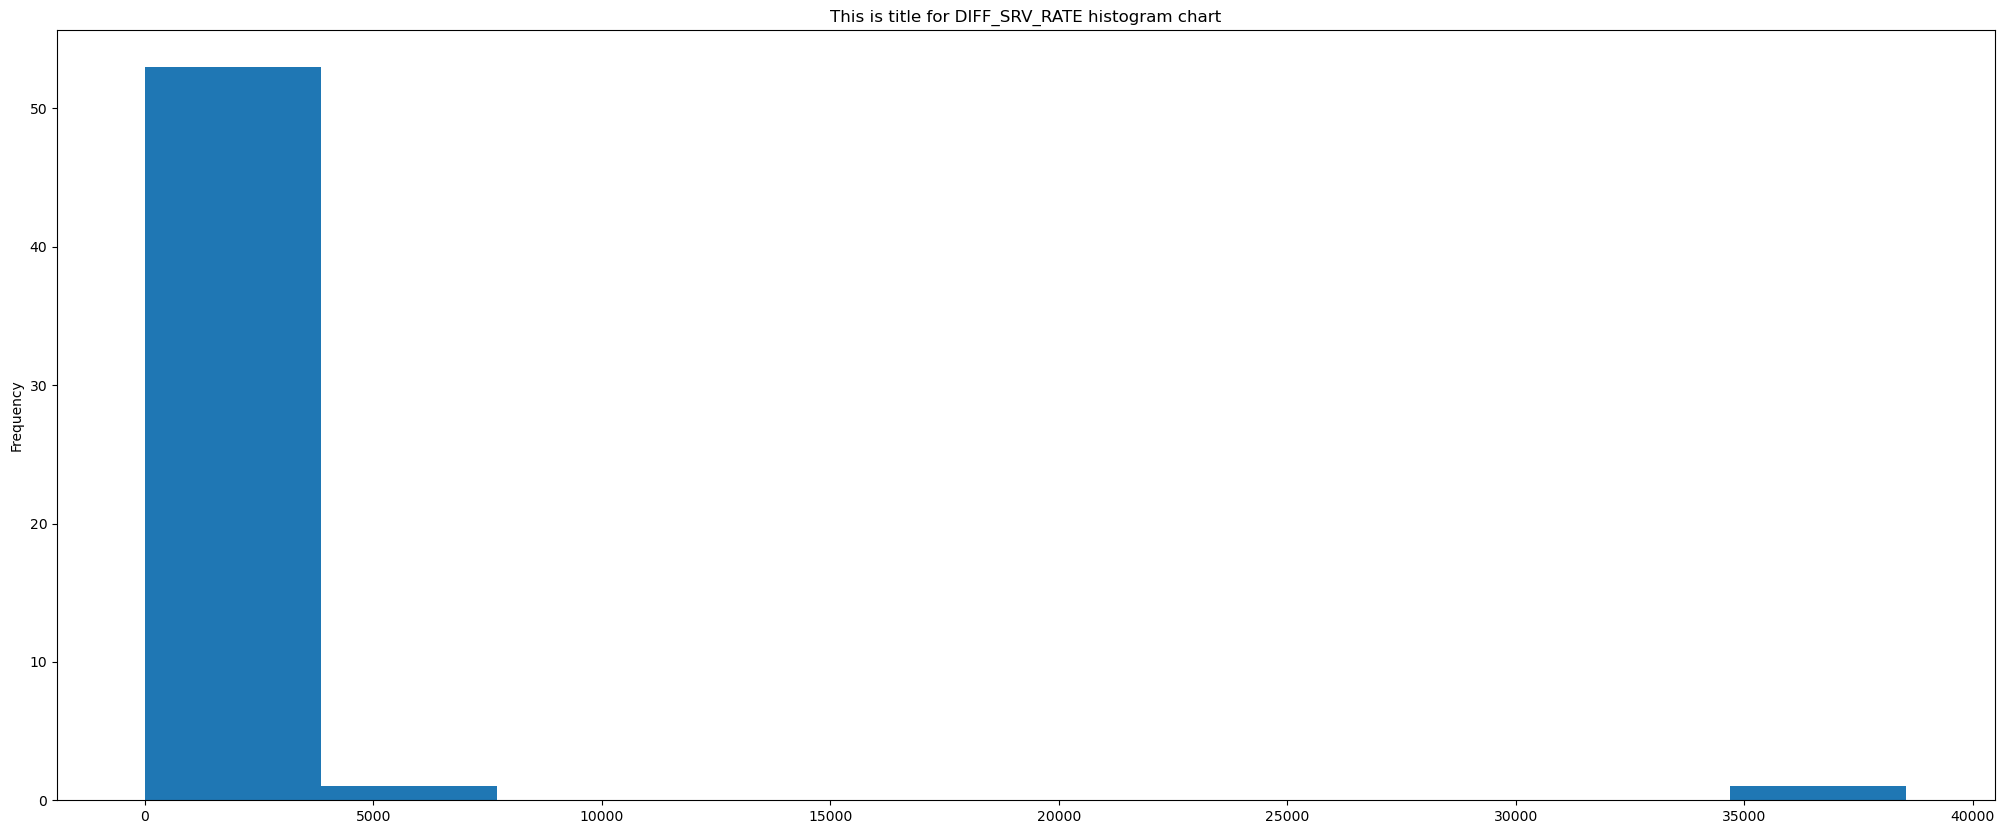

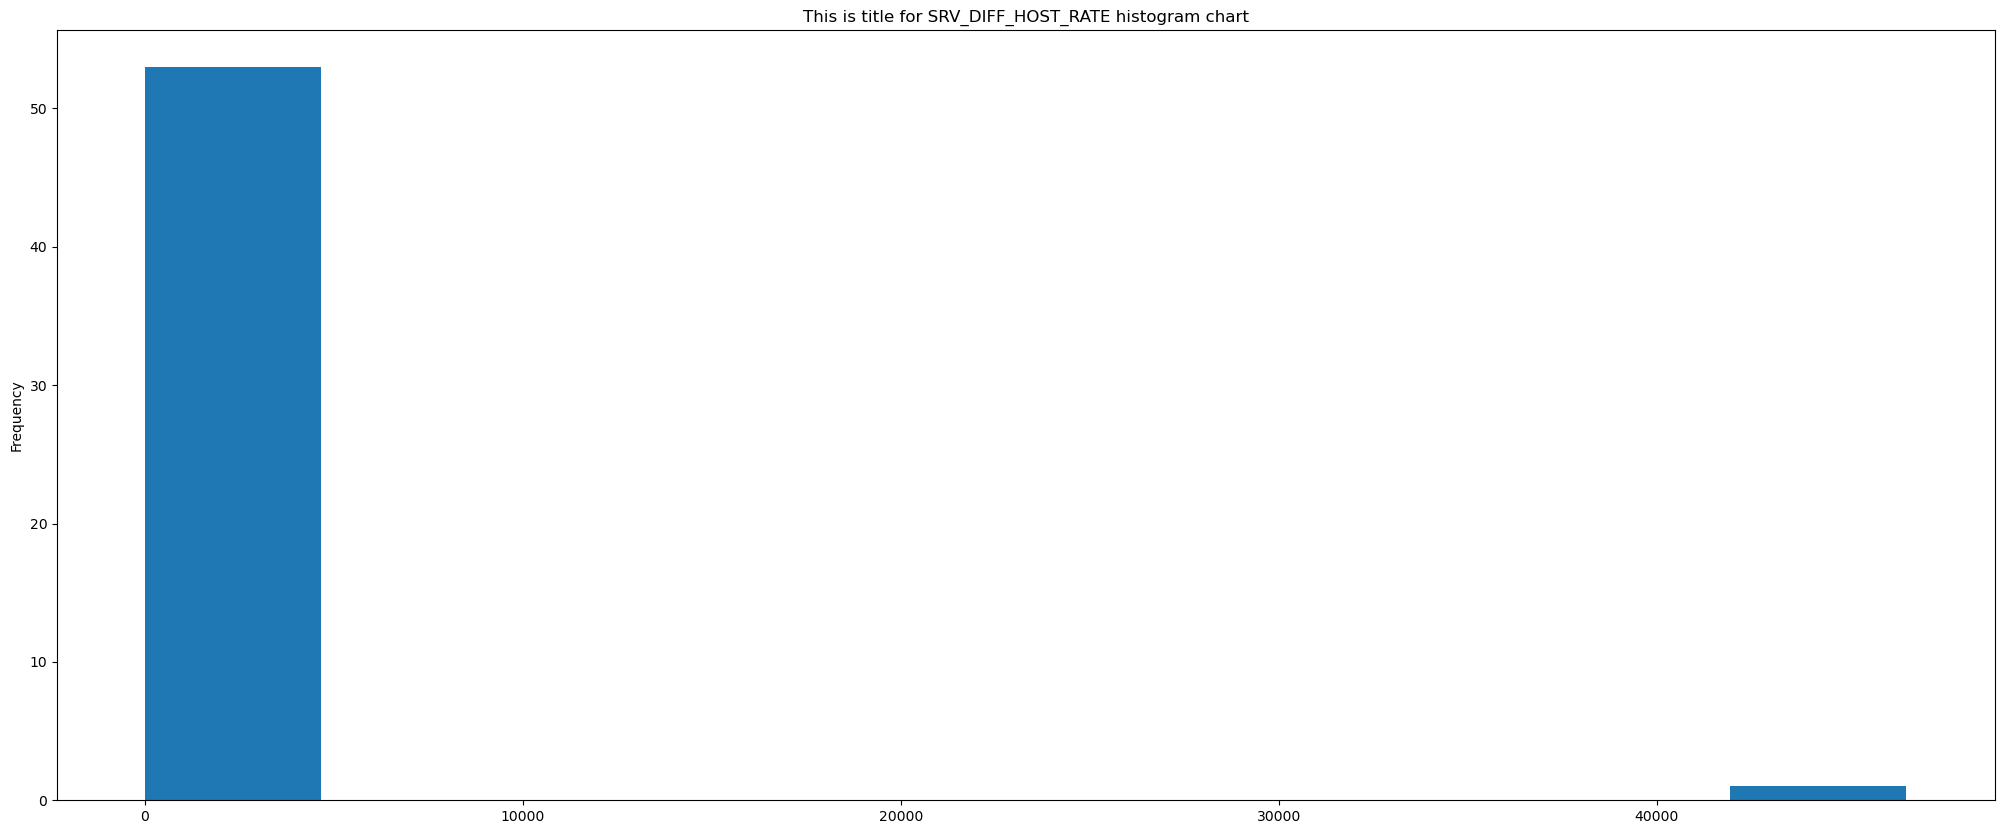

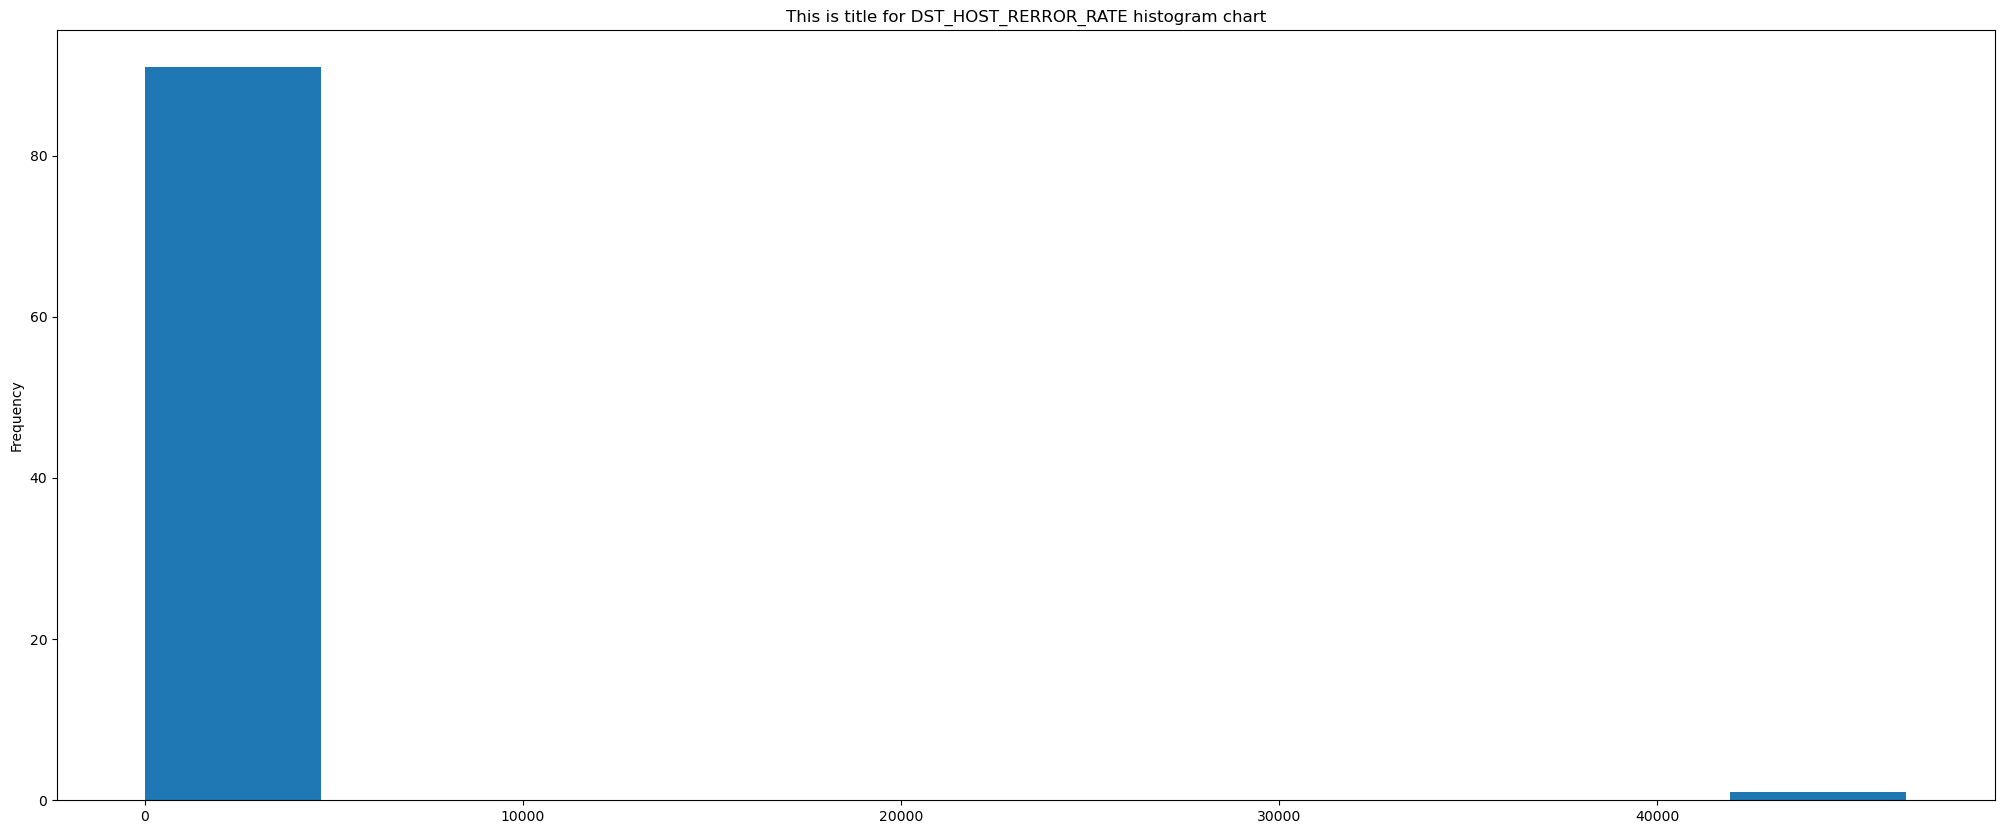

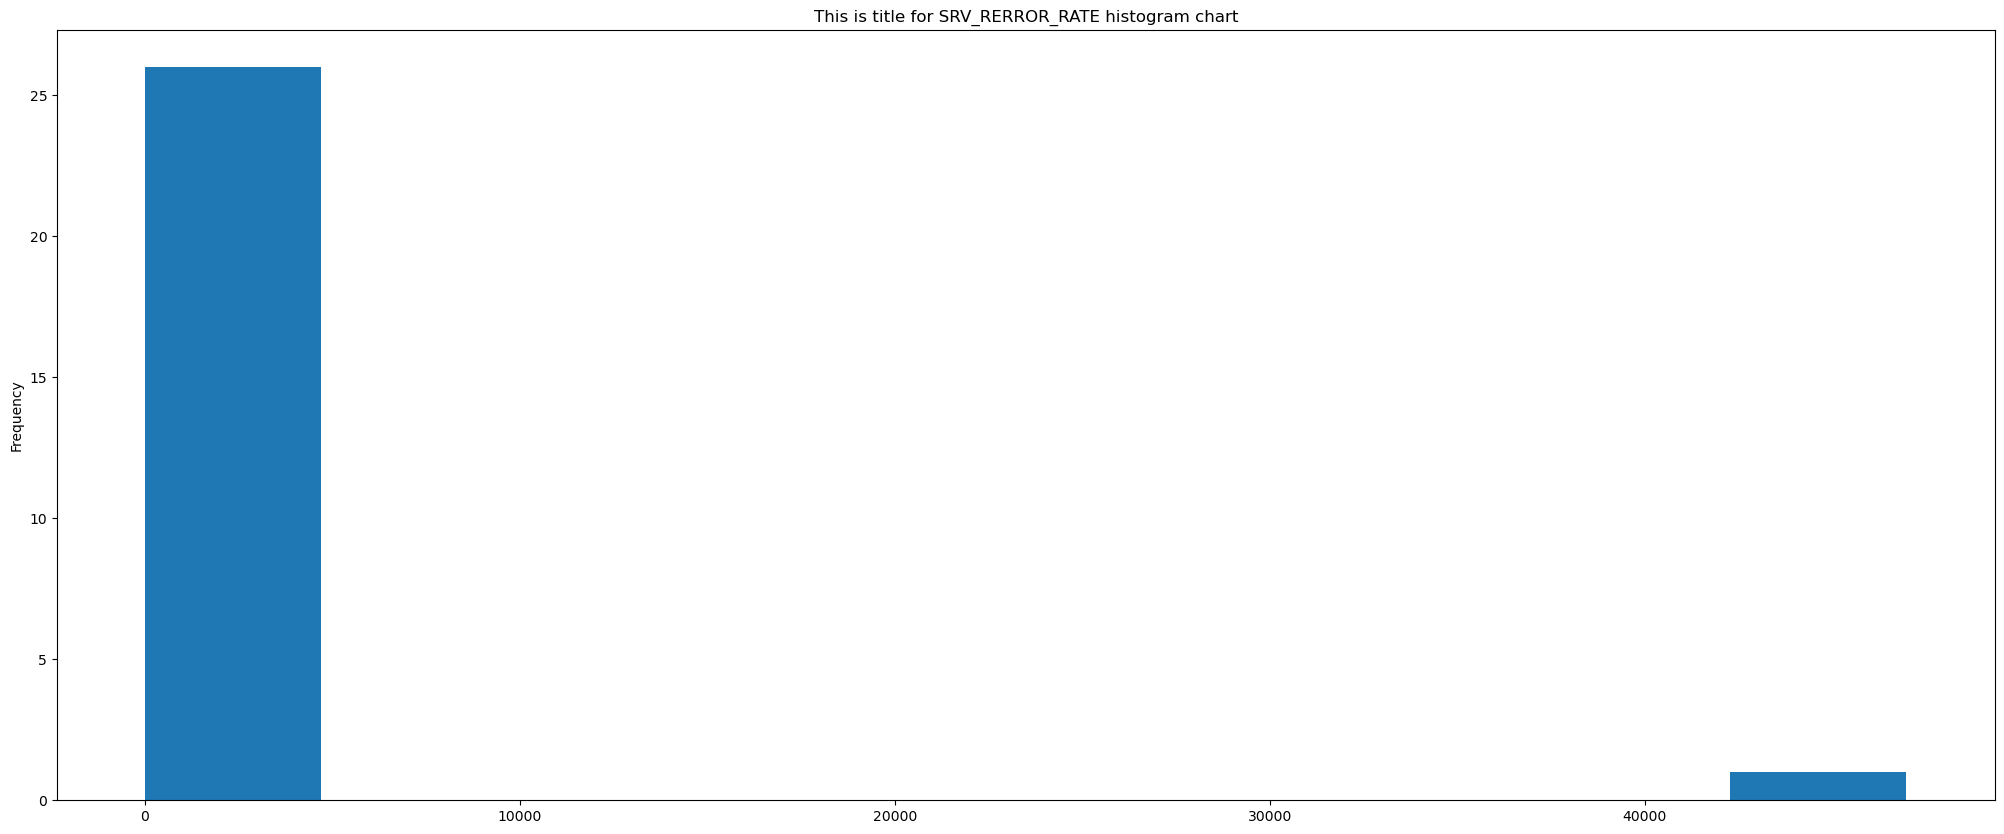

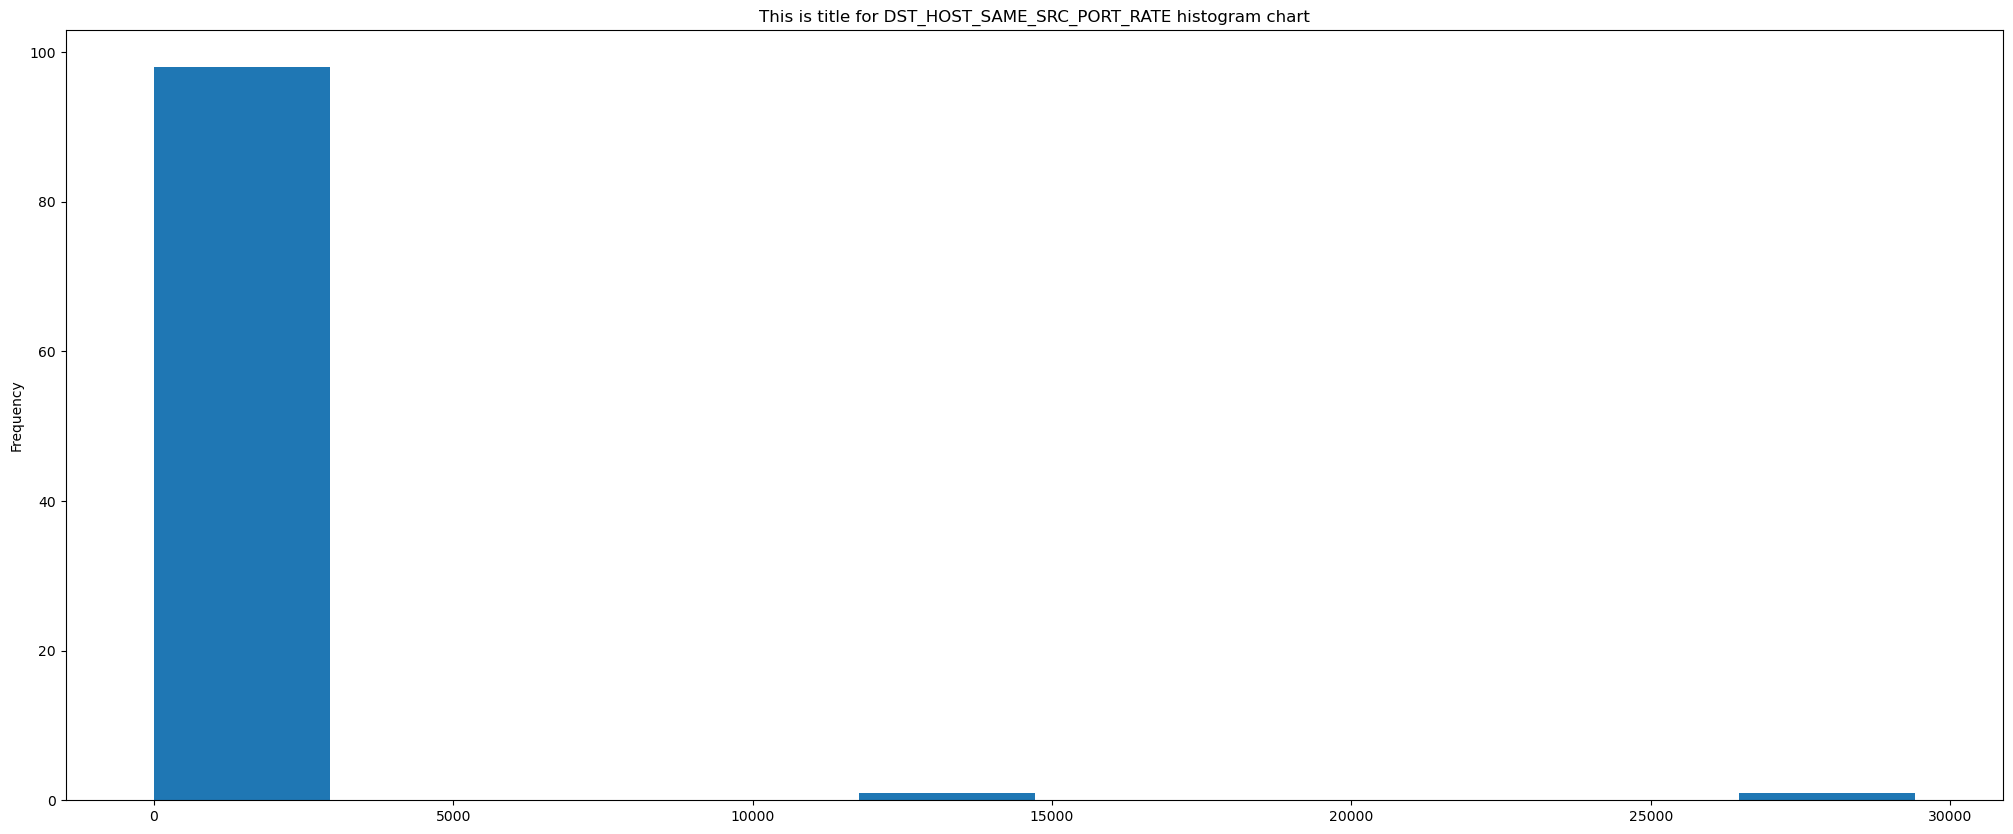

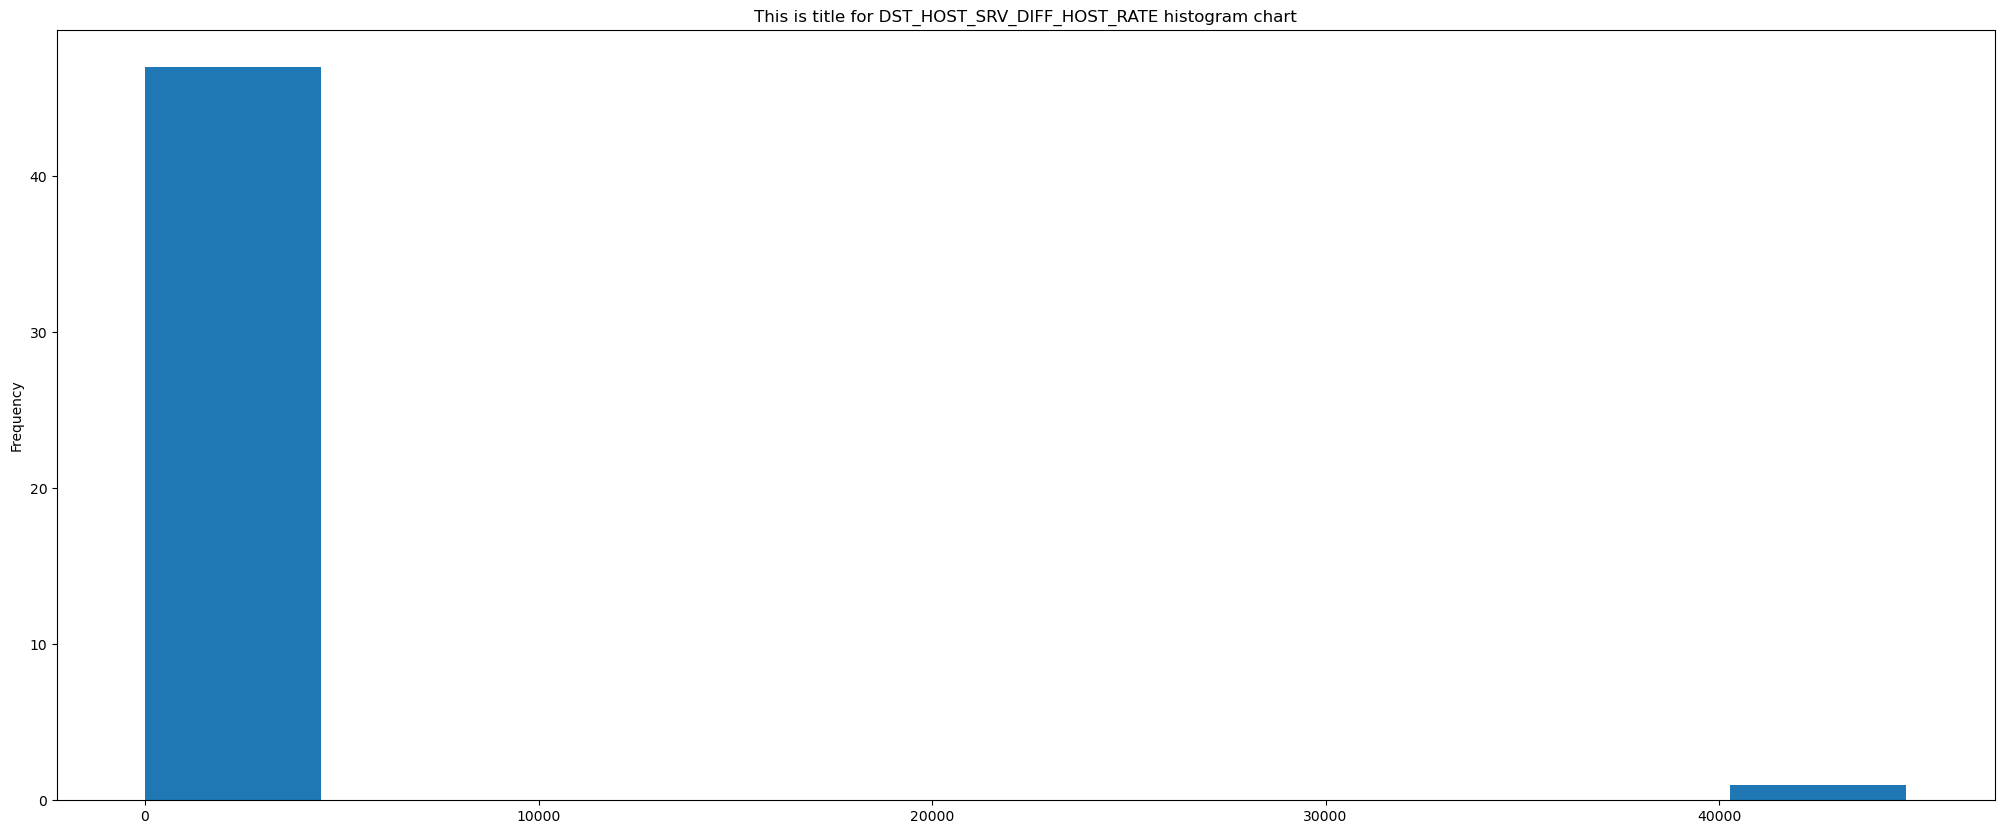

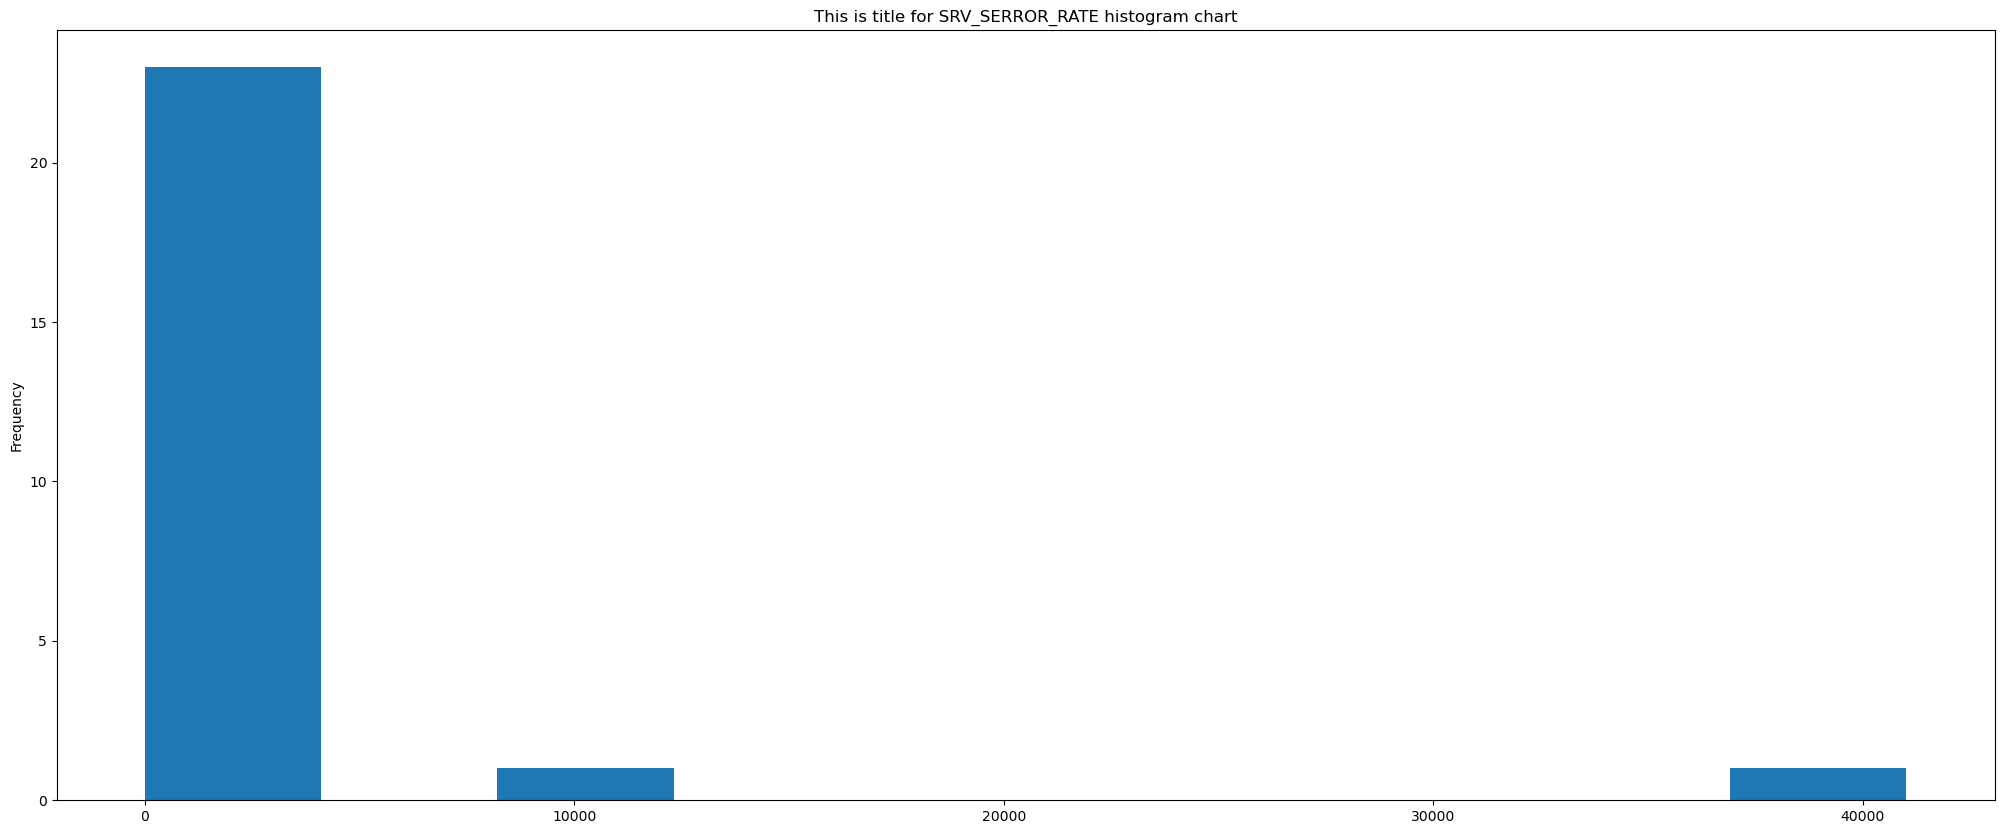

In [50]:
show_histogram_plots_for_all_continuous_plots(eda_kdd_cup_df, eda_kdd_cup_99_continuous_features)

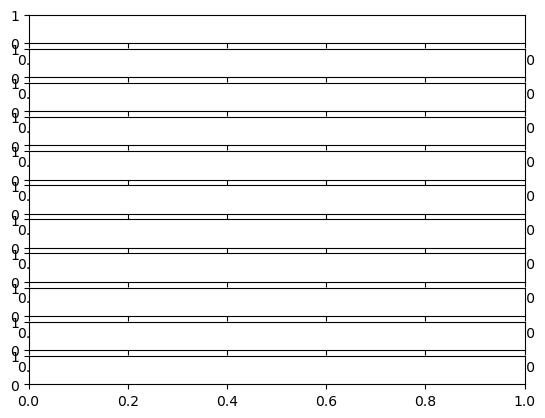

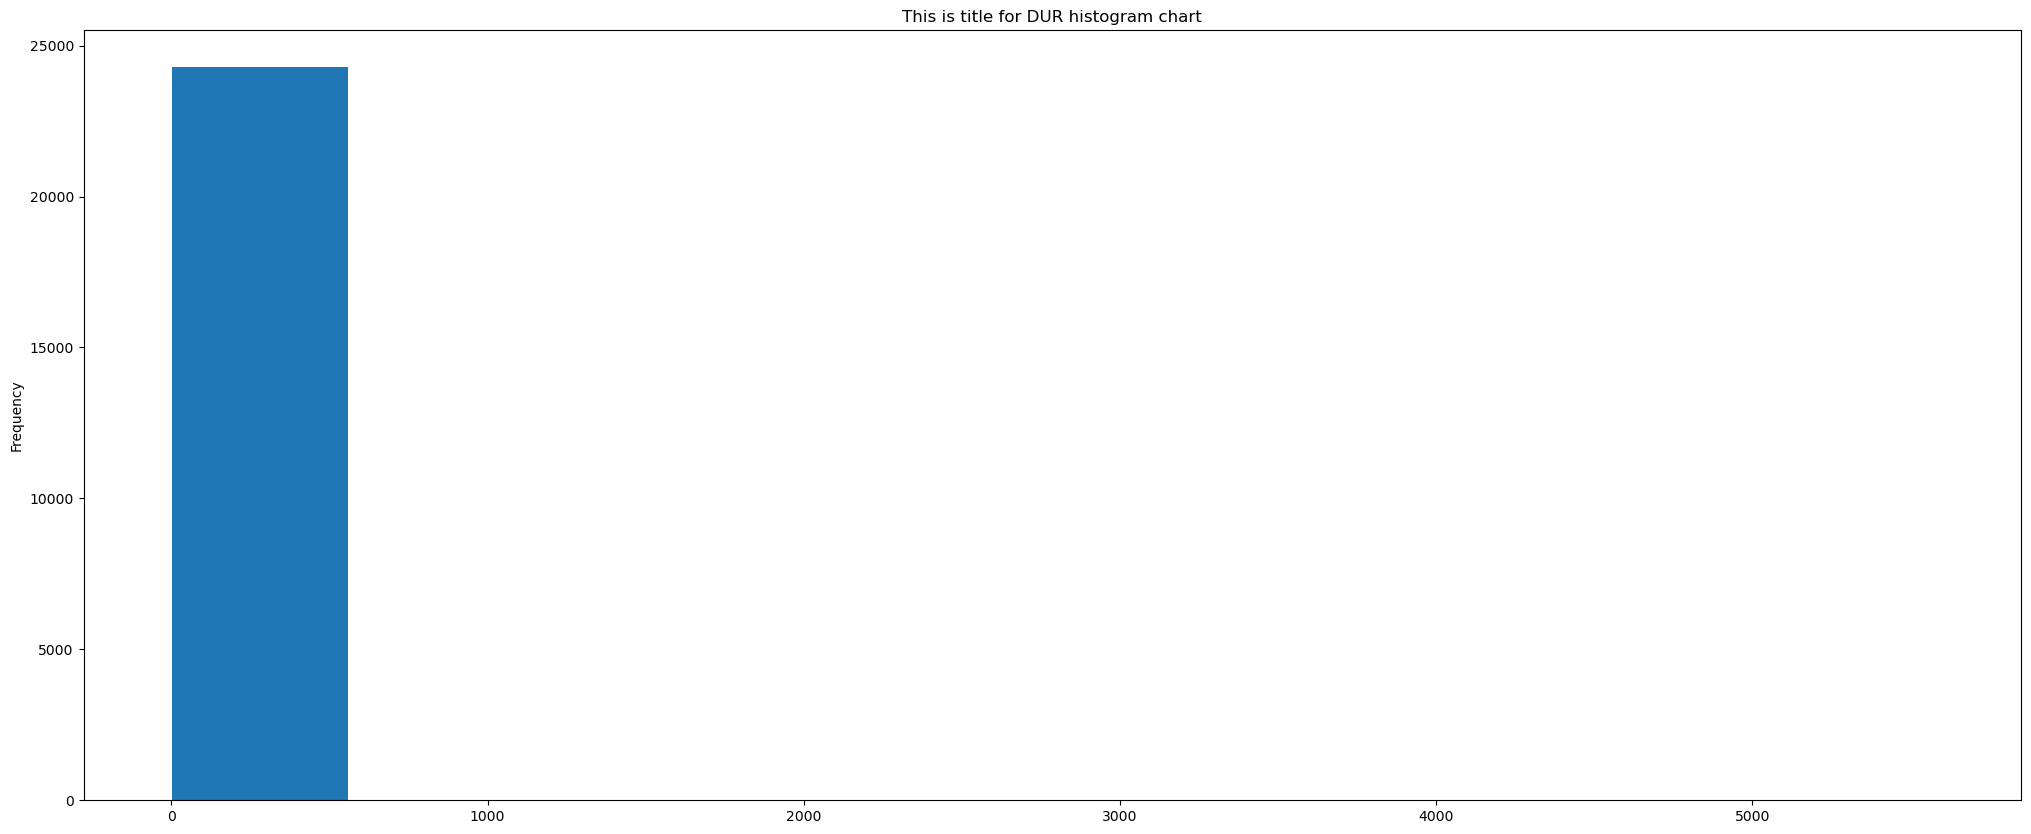

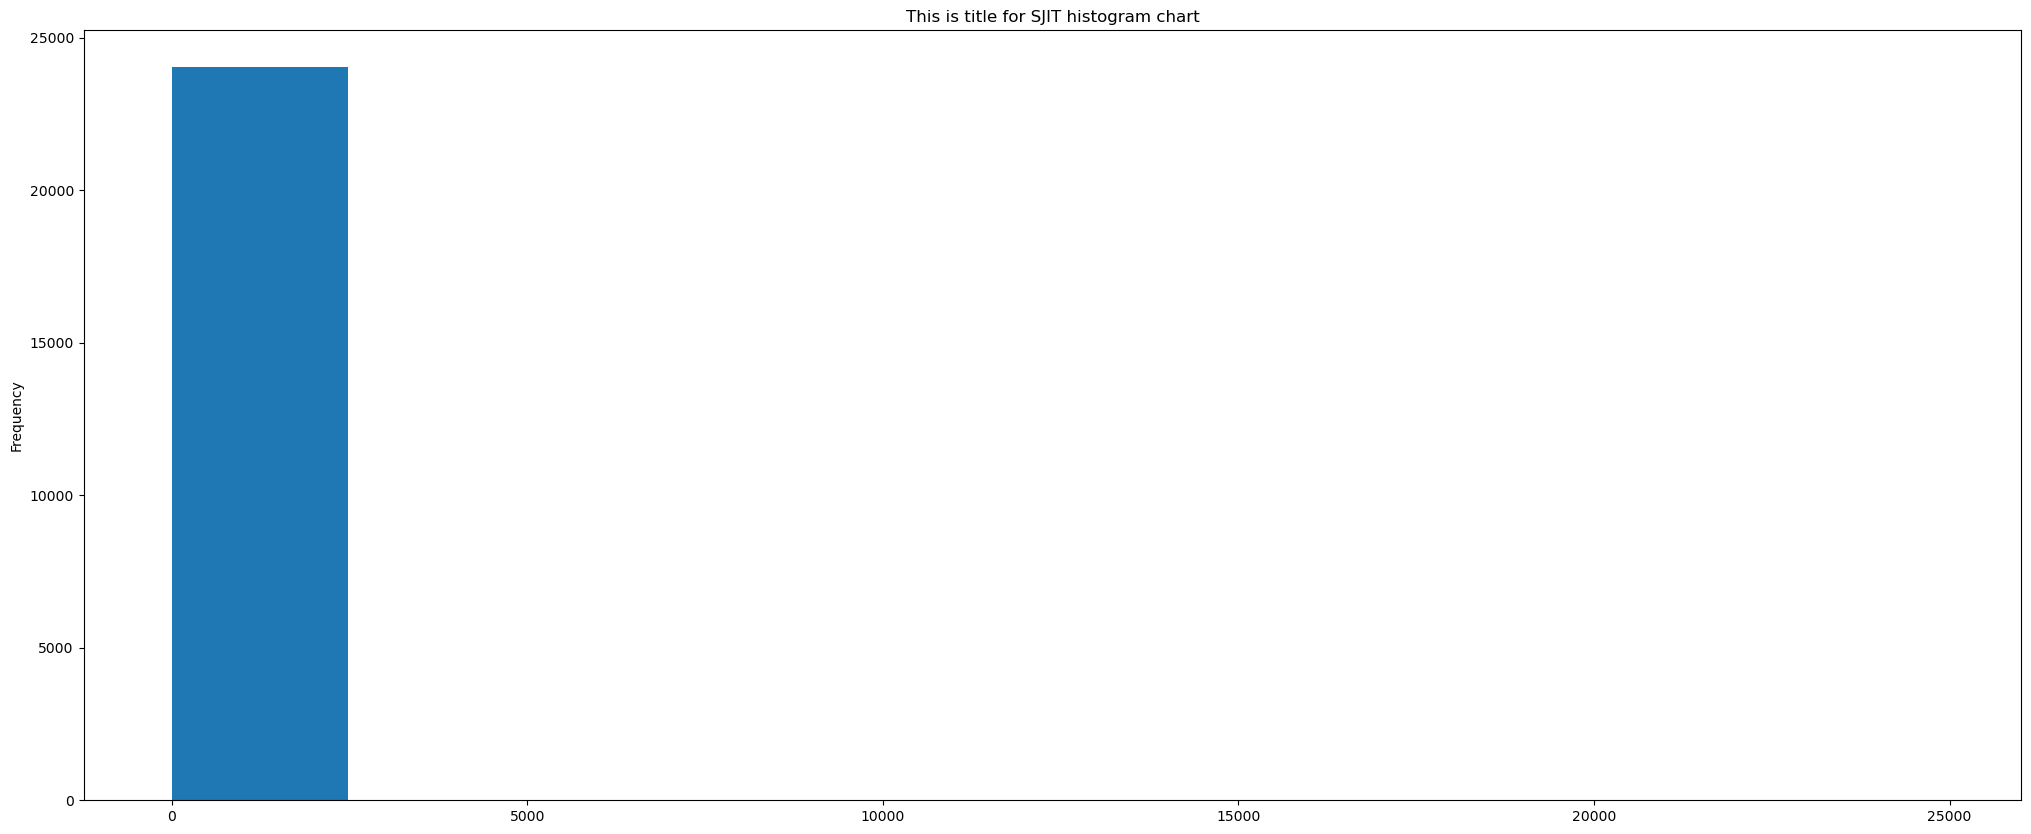

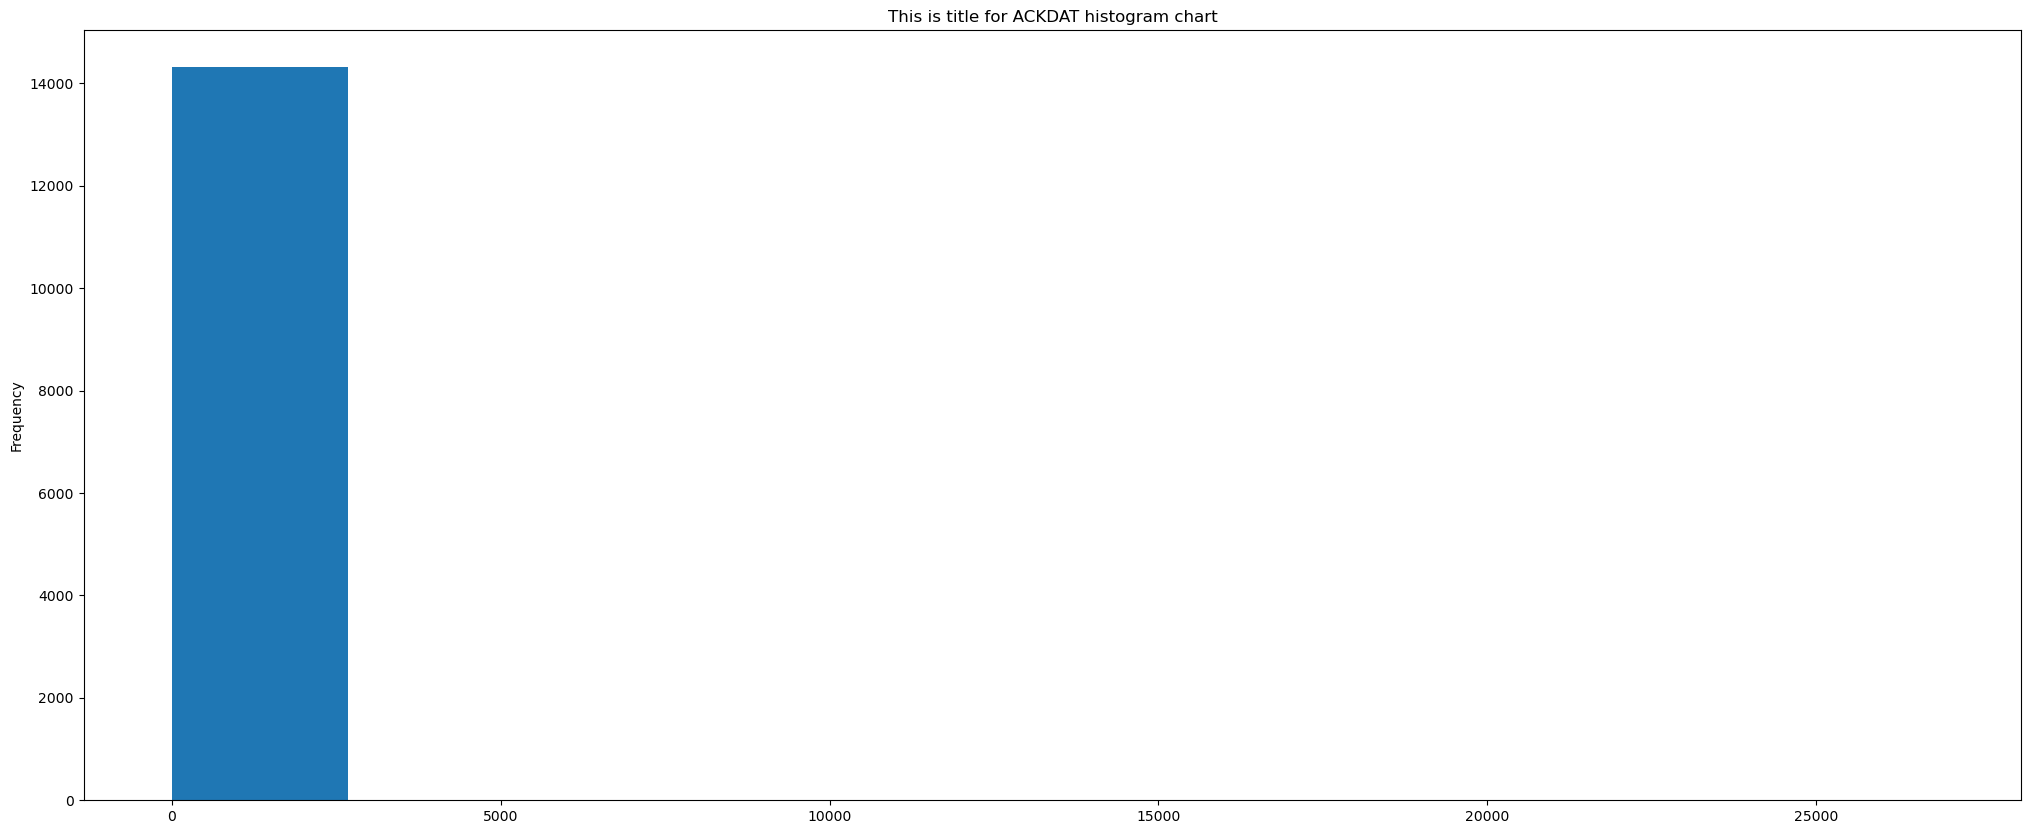

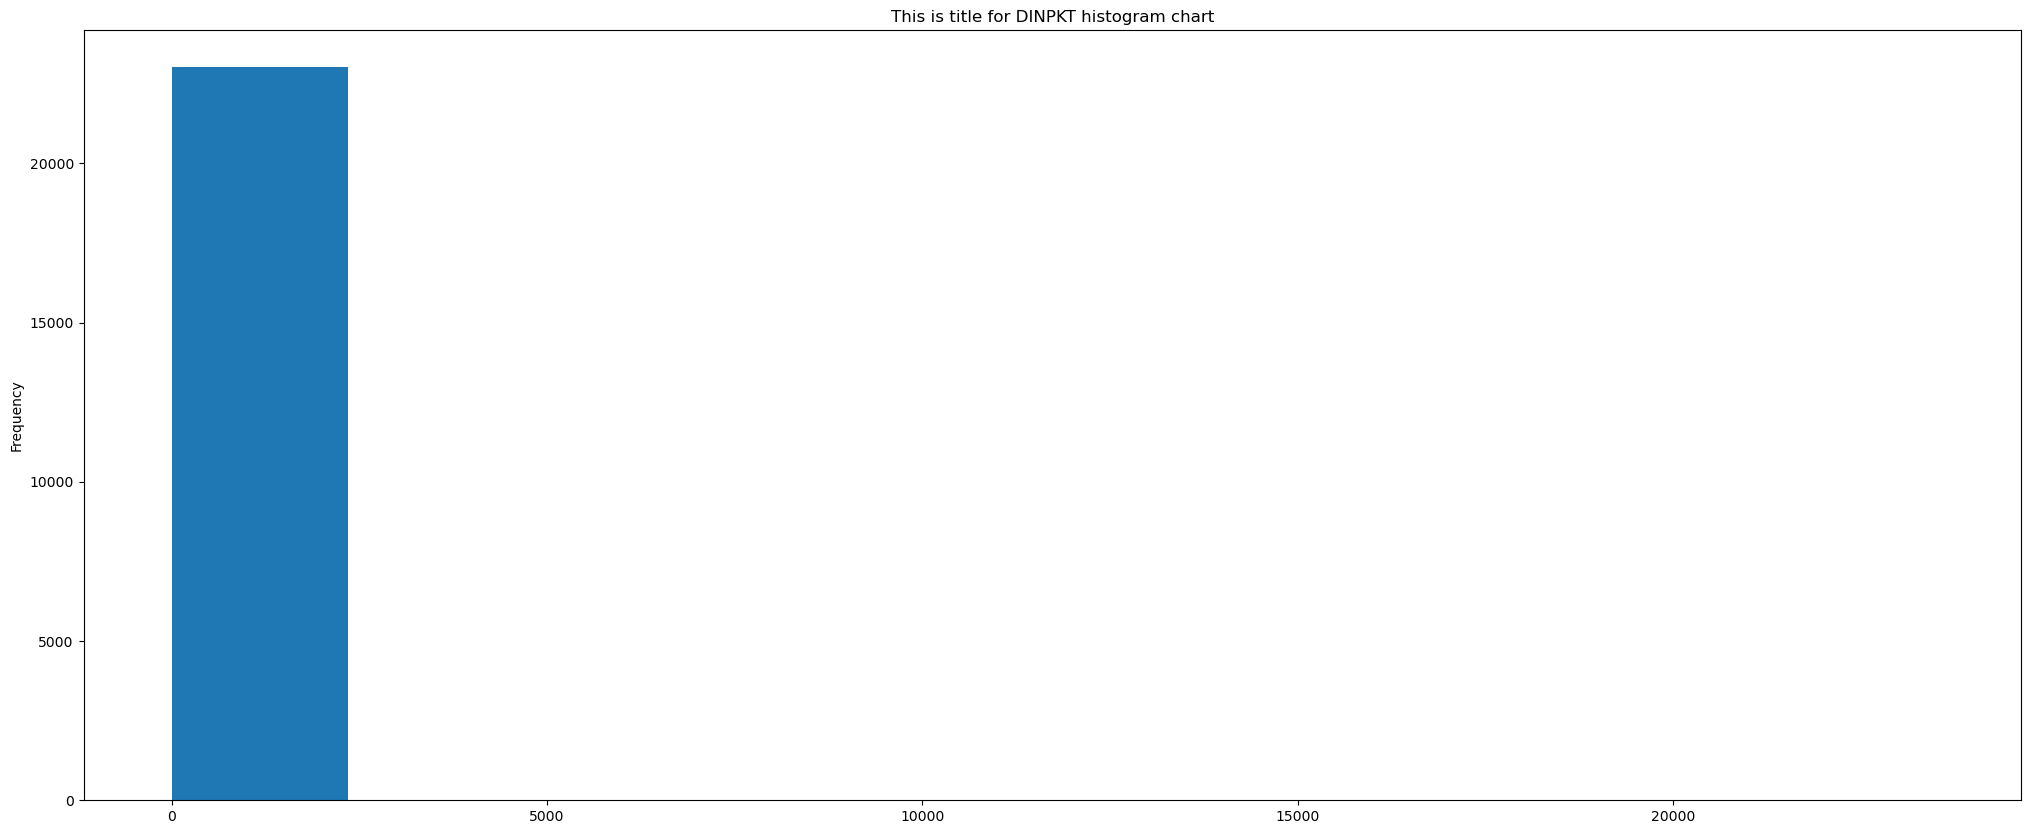

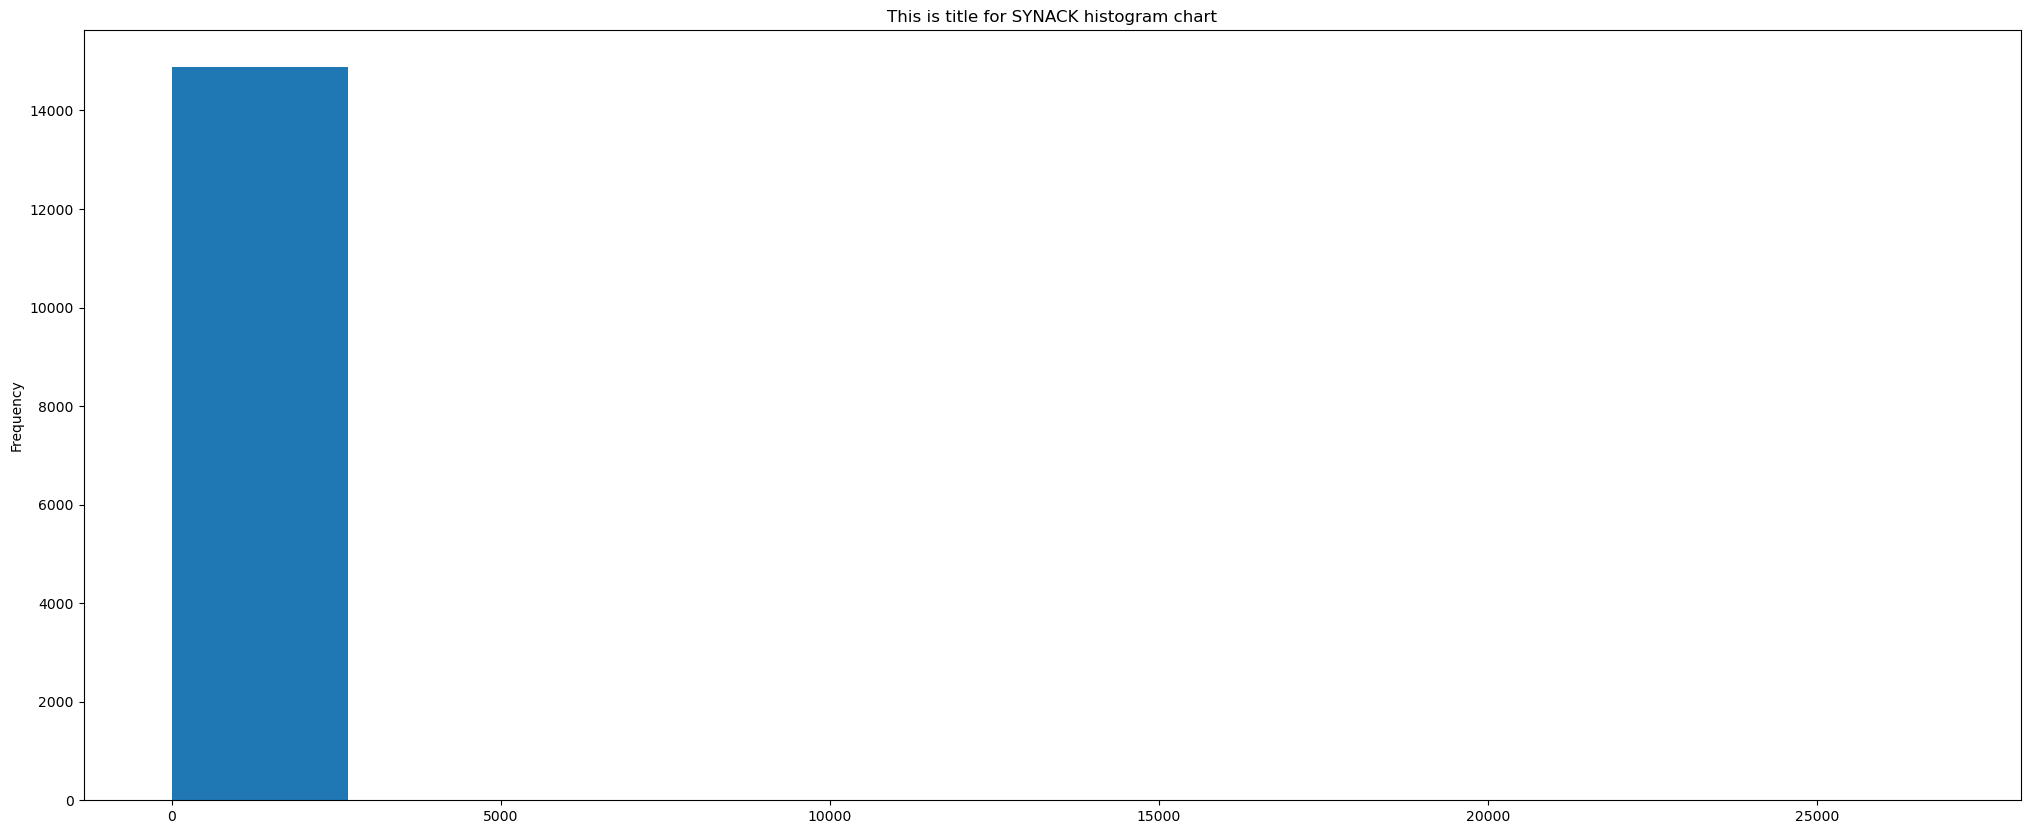

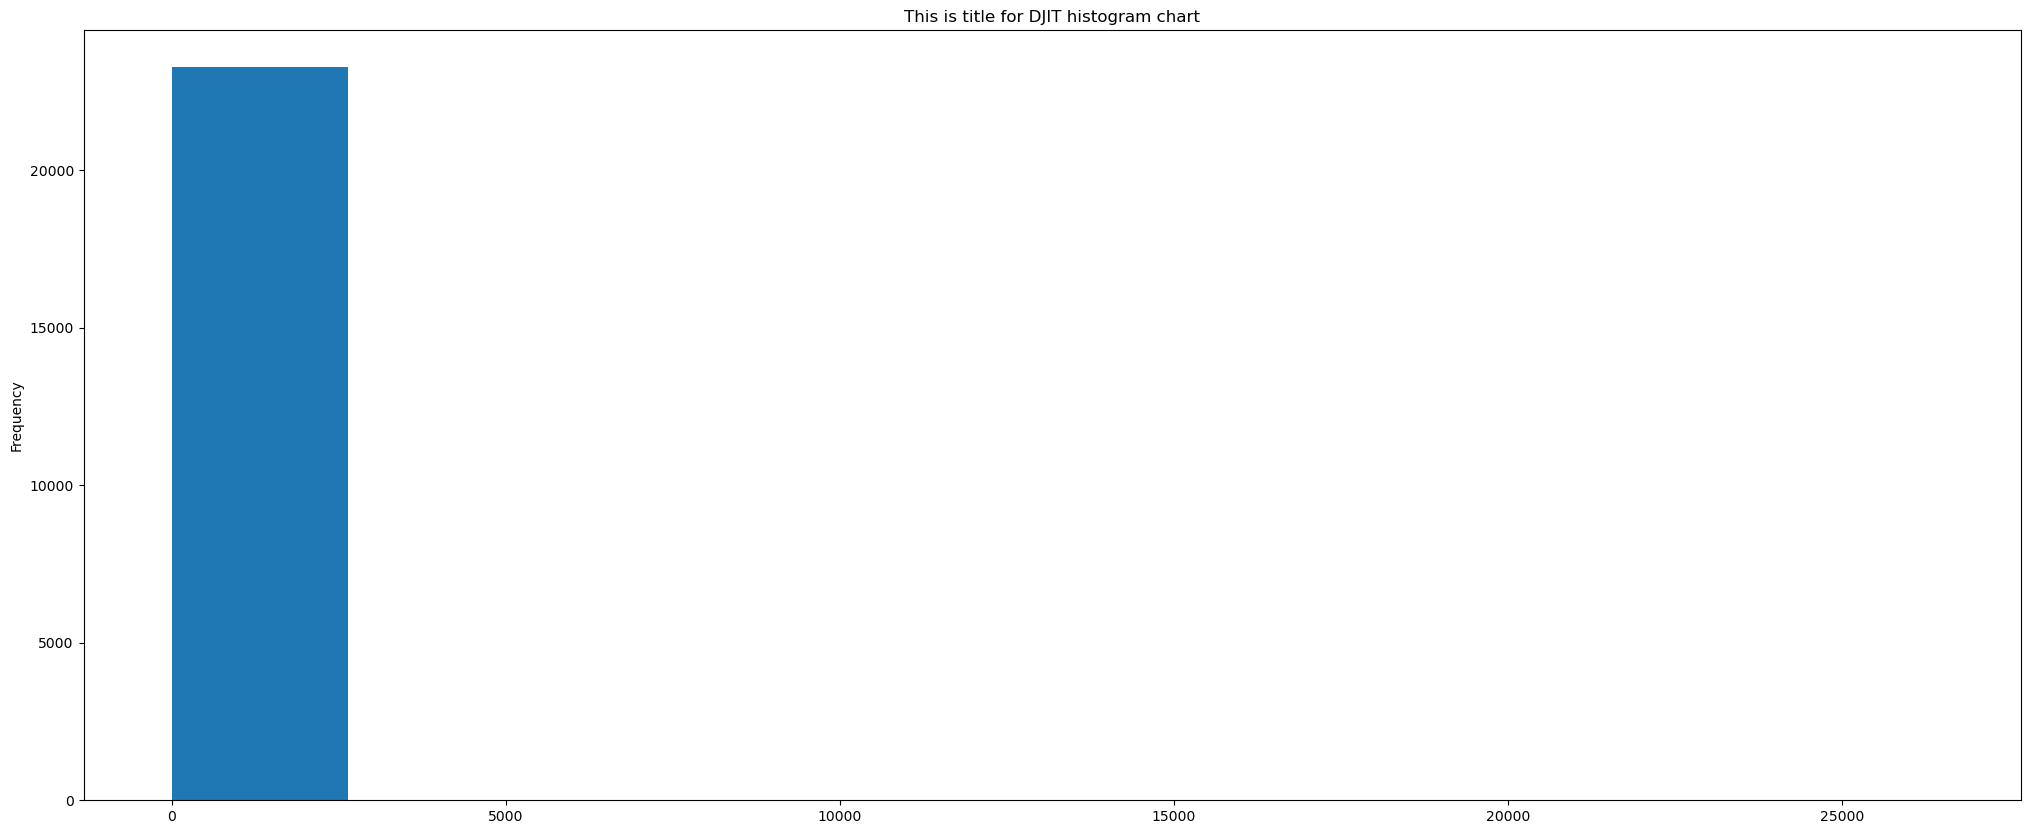

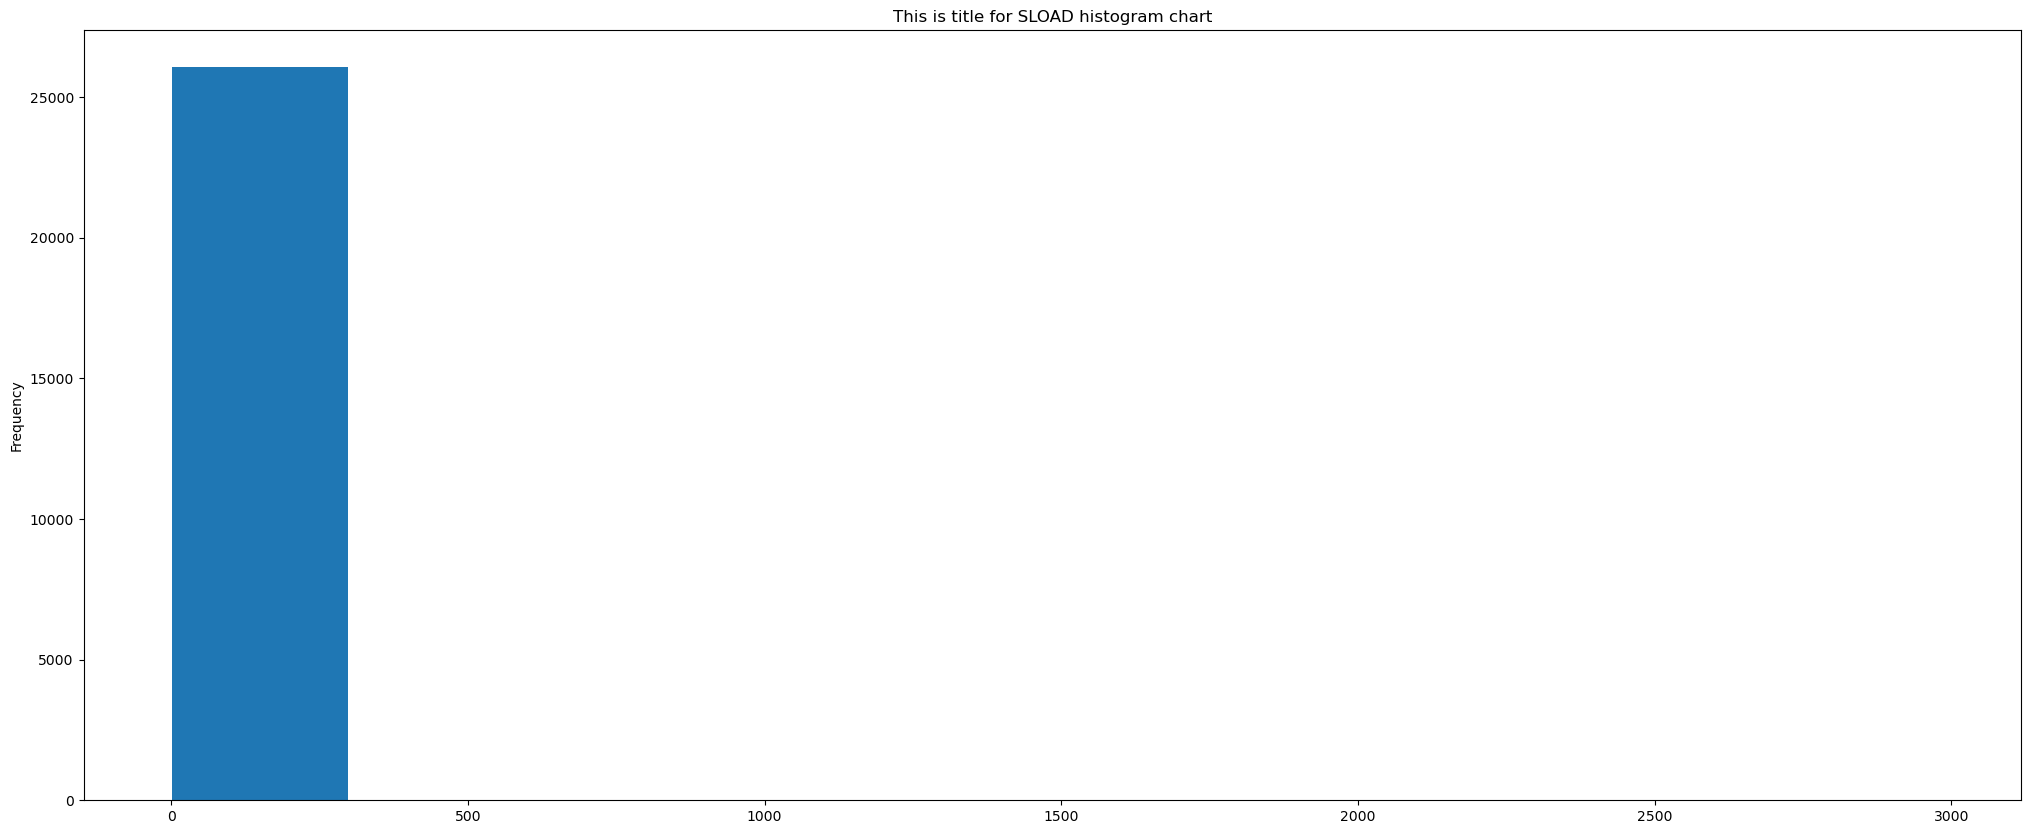

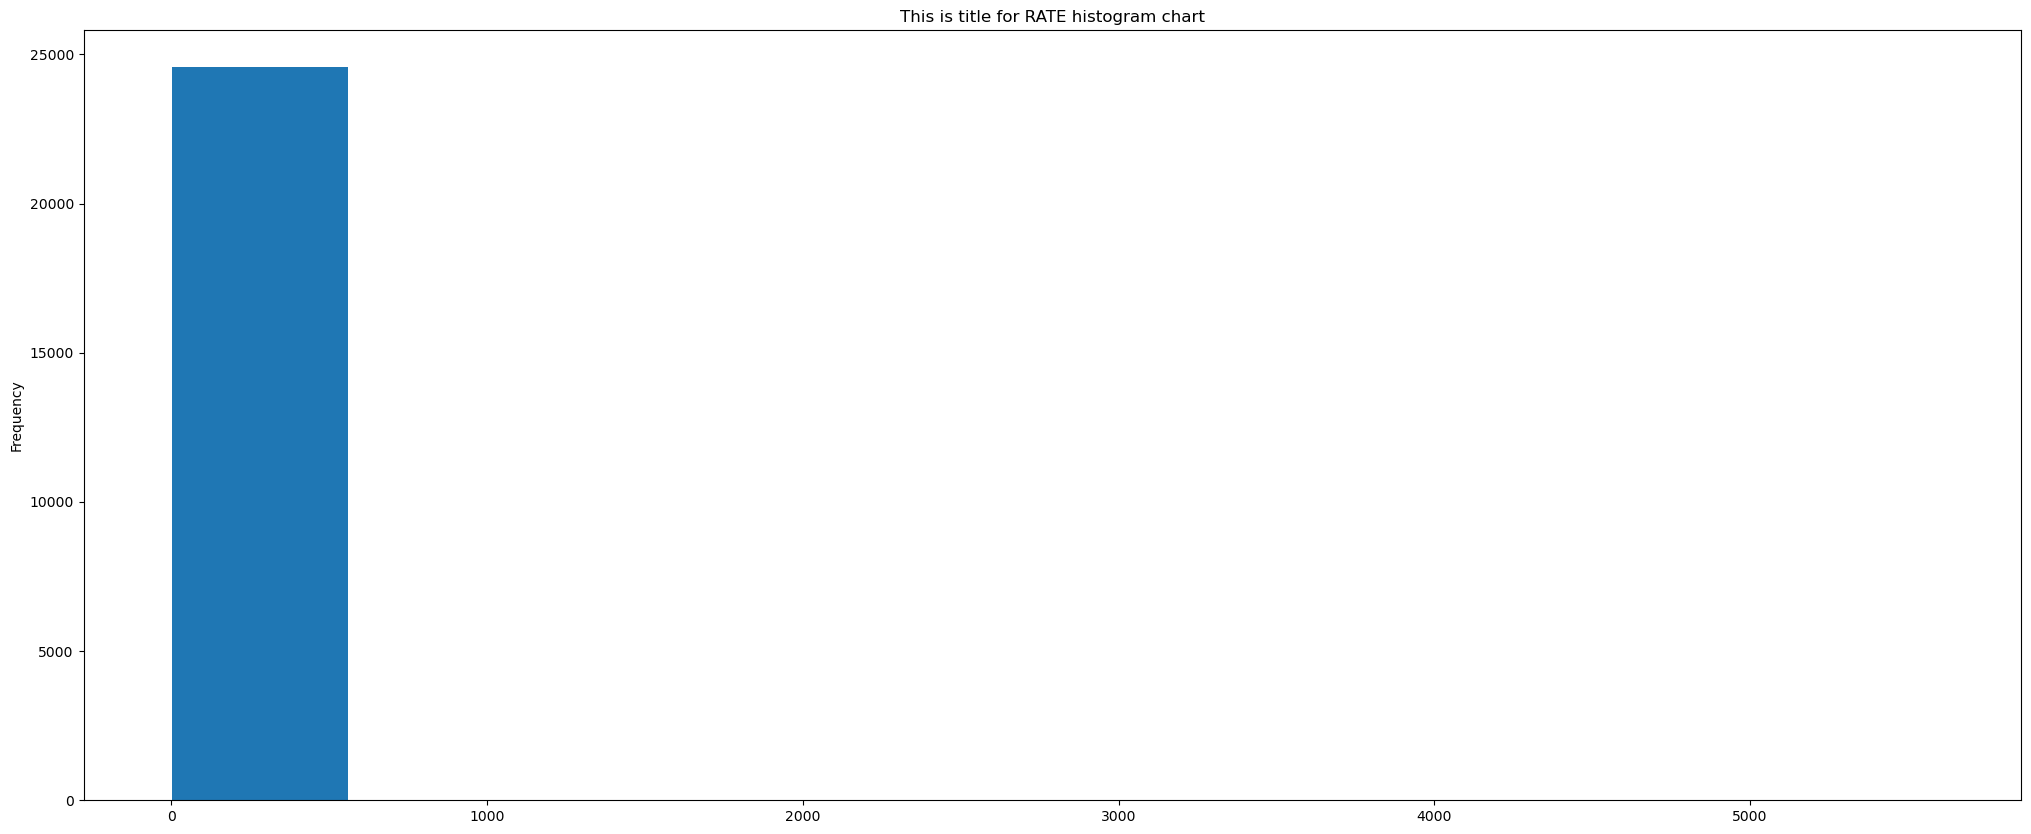

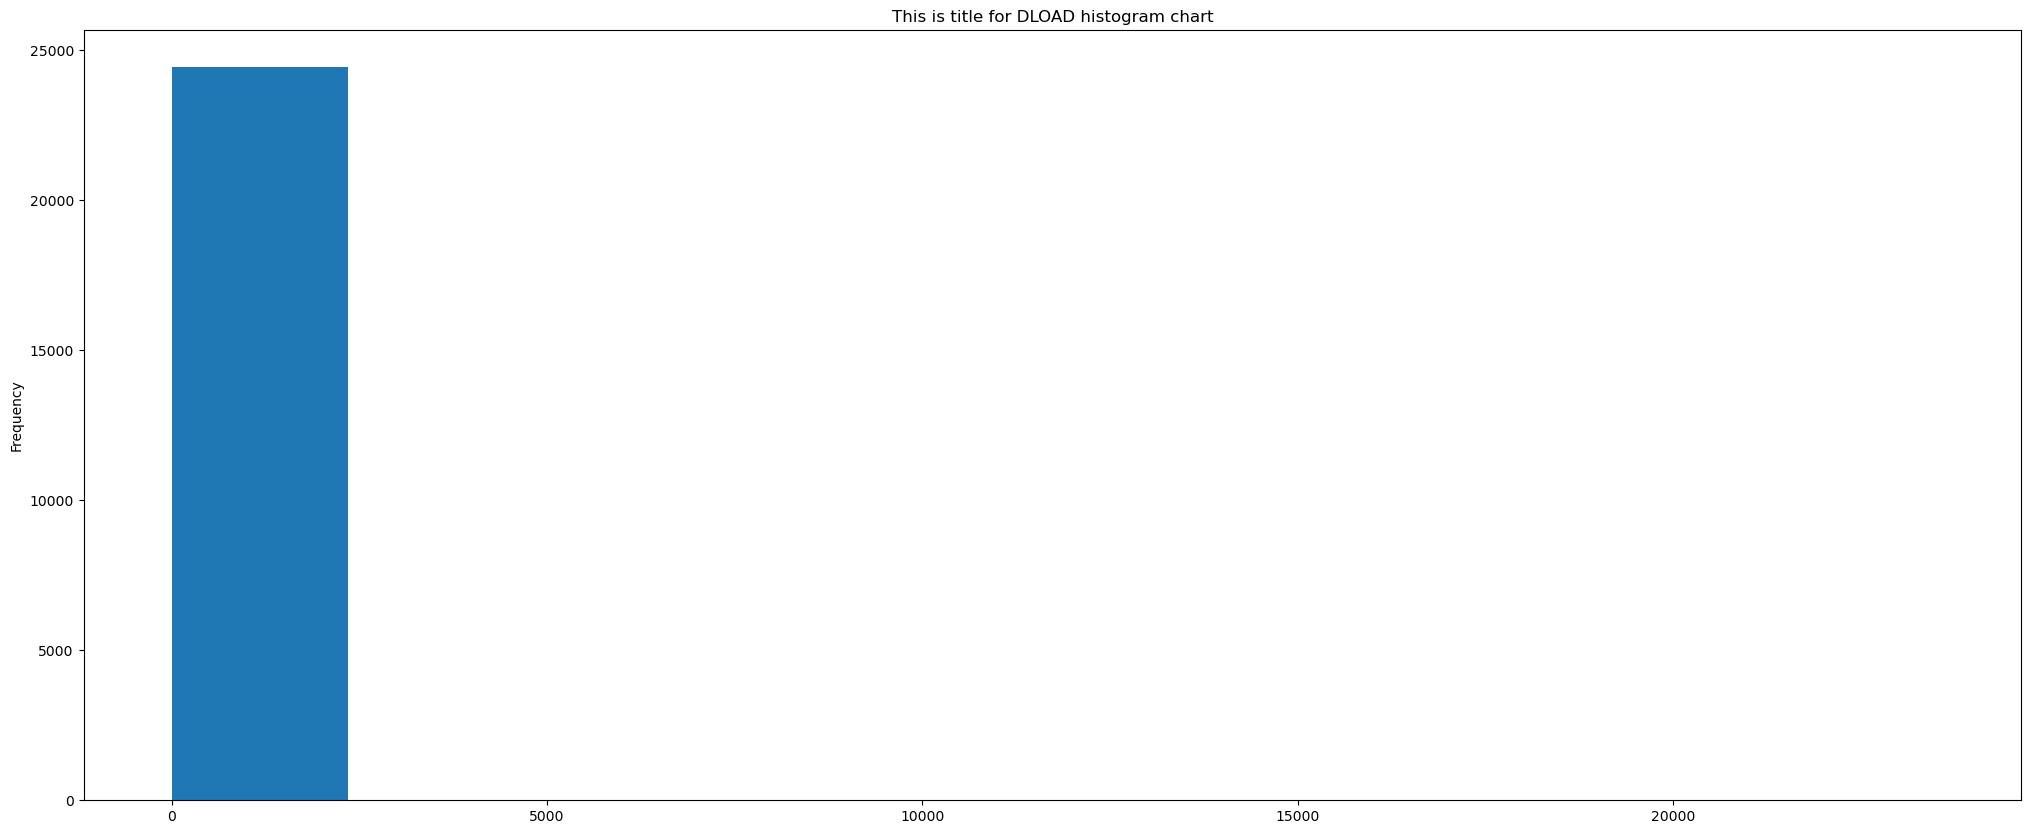

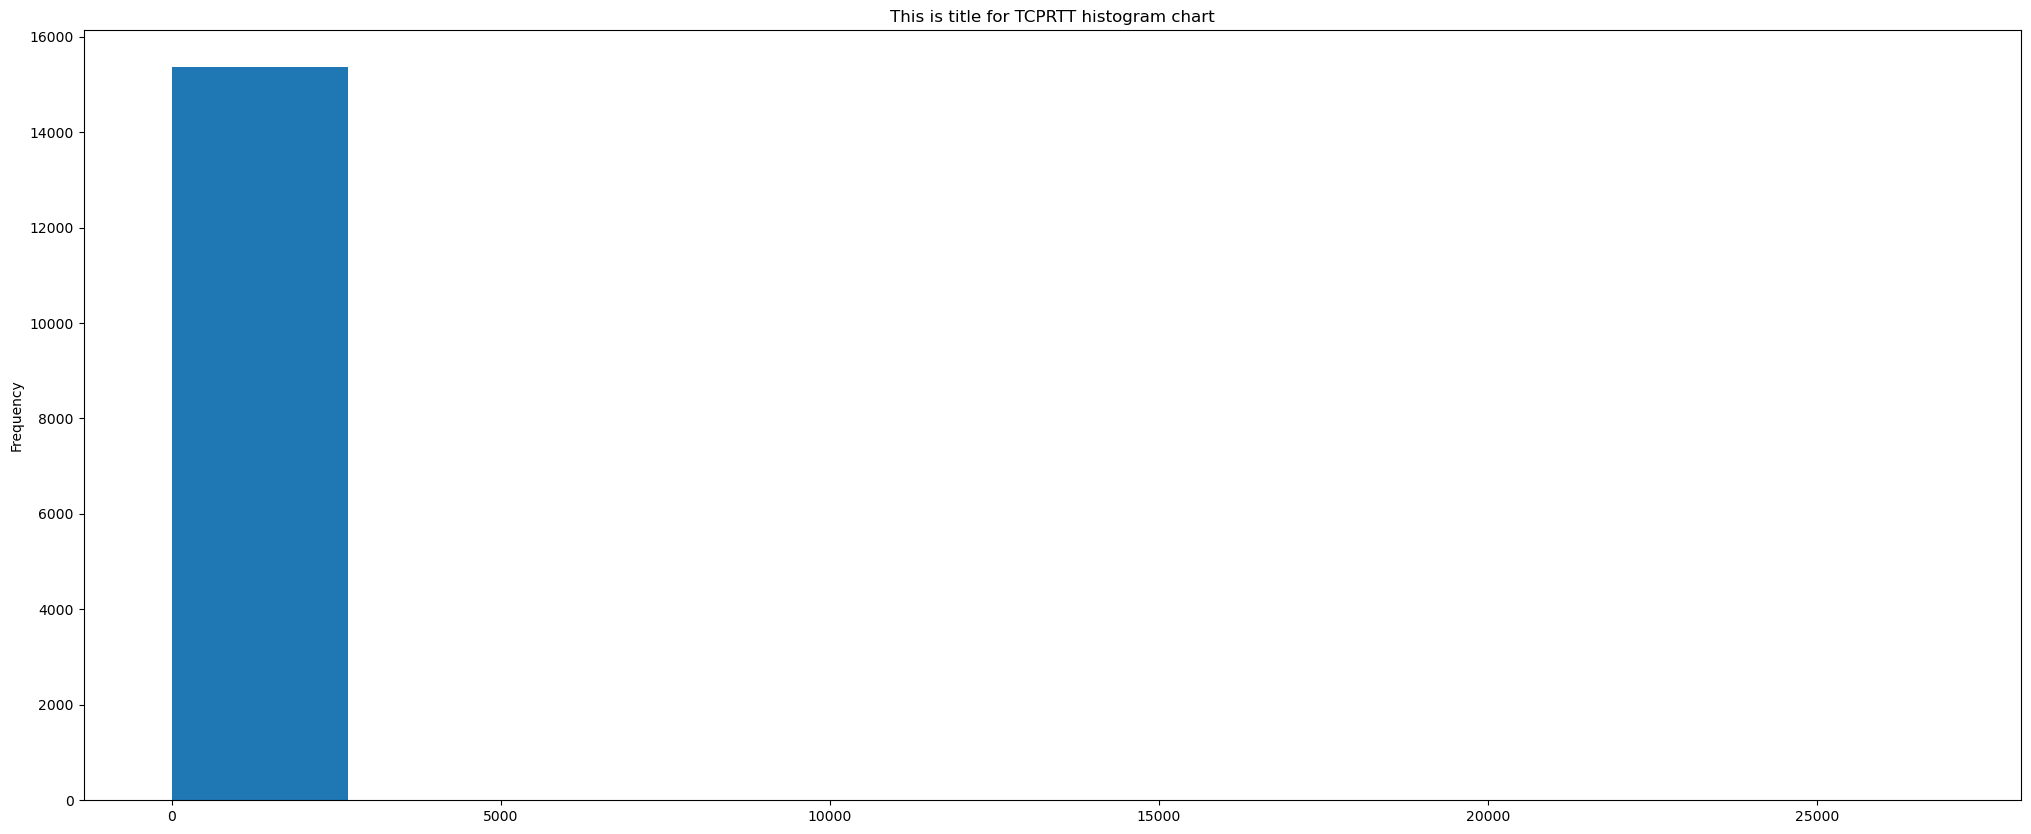

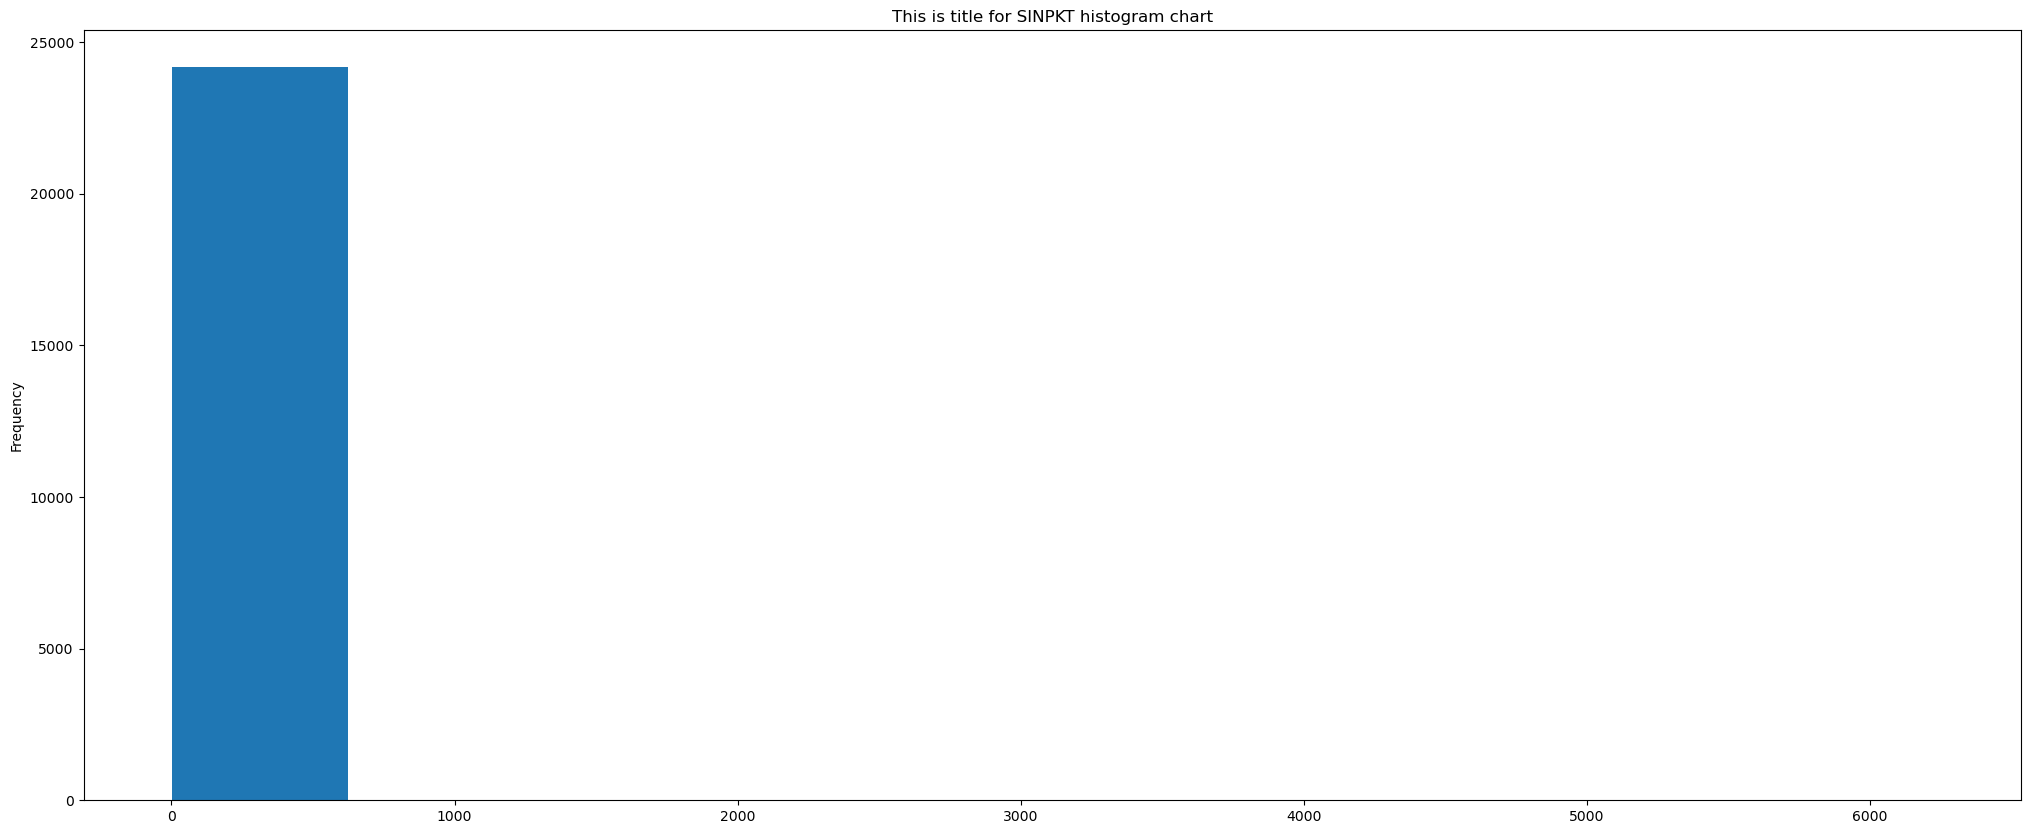

In [51]:
show_histogram_plots_for_all_continuous_plots(eda_unsw_nb15_df, eda_unsw_nb15_continuous_features)

#### Spliting and Standardizing Dataset for Experiment I

In [52]:
target_kdd_cup_df = kdd_cup_df[target_variable]
target_unsw_nb15_df = unsw_nb15_df[target_variable]

In [53]:
features_kdd_cup_df = kdd_cup_df.drop([target_variable], axis=1)
features_unsw_nb15_df = unsw_nb15_df.drop([target_variable], axis=1)

In [54]:
features_kdd_cup_df = process_feature_mapping(features_kdd_cup_df)




FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME

Processing feature mapping for protocol_type feature


Processing feature mapping for service feature


Processing feature mapping for flag feature




In [55]:
features_kdd_cup_df.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
4515306         1              0        0     0        754        328     0   
2245438         0              1        1     0       1032          0     0   
246897          0              0        2     0        241        284     0   
4737497         0              0        3     1          0          0     0   
3949589         0              1        1     0        520          0     0   

         wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
4515306               0       0    0  ...             255                 188   
2245438               0       0    0  ...             255                 255   
246897                0       0    0  ...             255                 255   
4737497               0       0    0  ...             255                  13   
3949589               0       0    0  ...             255                 255   

         dst_host_same_srv_rate  dst_host_diff_srv_rate  \
4515306                    0.74                    0.03   
2245438                    1.00                    0.00   
246897                     1.00                    0.00   
4737497                    0.05                    0.06   
3949589                    1.00                    0.00   

         dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
4515306                          0.0                          0.0   
2245438                          1.0                          0.0   
246897                           0.0                          0.0   
4737497                          0.0                          0.0   
3949589                          1.0                          0.0   

         dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
4515306                   0.0                       0.0                   0.0   
2245438                   0.0                       0.0                   0.0   
246897                    0.0                       0.0                   0.0   
4737497                   0.0                       0.0                   1.0   
3949589                   0.0                       0.0                   0.0   

         dst_host_srv_rerror_rate  
4515306                       0.0  
2245438                       0.0  
246897                        0.0  
4737497                       1.0  
3949589                       0.0  

[5 rows x 41 columns]

In [56]:
features_unsw_nb15_df = process_feature_mapping(features_unsw_nb15_df)




FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME

Processing feature mapping for proto feature


Processing feature mapping for service feature


Processing feature mapping for state feature




In [57]:
features_unsw_nb15_df.head()

id       dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
197400  115069  0.000007      0        0      0      2      0     168       0   
232488  150157  0.000003      0        1      0      2      0     114       0   
64091    64092  0.597824      1        0      1     10      8    1750     354   
124849   42518  0.243193      1        0      1     10      6     510     268   
157559   75228  0.000005      2        0      0      2      0     200       0   

                 rate  ...  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  \
197400  142857.140900  ...           2                 1                 1   
232488  333333.321500  ...          10                10                10   
64091       28.436464  ...           1                 1                 1   
124849      61.679407  ...           2                 2                 1   
157559  200000.005100  ...           2                 2                 2   

        ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  \
197400               1             0           0                 0   
232488              25             0           0                 0   
64091                1             0           0                 0   
124849              10             0           0                 0   
157559               3             0           0                 0   

        ct_src_ltm  ct_srv_dst  is_sm_ips_ports  
197400           4           1                0  
232488          11          25                0  
64091            1           1                0  
124849           2          10                0  
157559           4           3                0  

[5 rows x 43 columns]

In [58]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [59]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

In [60]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [61]:
ros = SMOTE()

kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)

unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)

In [62]:
print(kddcup_y_train.agg(['nunique','count','size']))
print()
print(kddcup_y_train[kddcup_y_train == 0].count())
print()
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      64058
size       64058
Name: traffic_type, dtype: int64

32029

32029


In [63]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      51362
size       51362
Name: traffic_type, dtype: int64

25681

25681


In [64]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment I

In [65]:
experiment_type = "EXPERIMENT-ONE"



ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

0.06






TESTING TIME

0.01



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.86      0.97      0.92      1716
      Attack       0.99      0.97      0.98      8284

    accuracy                           0.97     10000
   macro avg       0.93      0.97      0.95     10000
weighted avg       0.97      0.97      0.97     10000




CONFUSION MATRIX



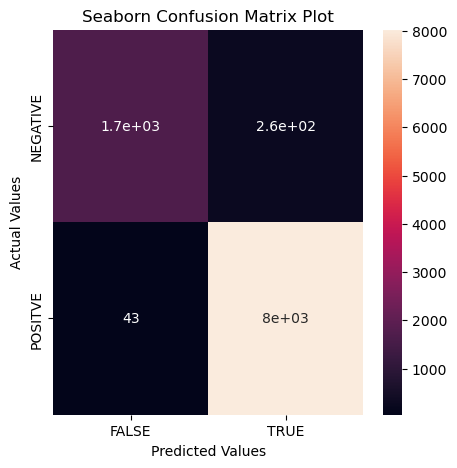




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9296
GEOMETRIC MEAN SCORE:  0.9274










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

0.06






TESTING TIME

0.01



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.81      0.68      0.74      4323
      Attack       0.78      0.88      0.83      5677

    accuracy                           0.79     10000
   macro avg       0.80      0.78      0.79     10000
weighted avg       0.80      0.79      0.79     10000




CONFUSION MATRIX



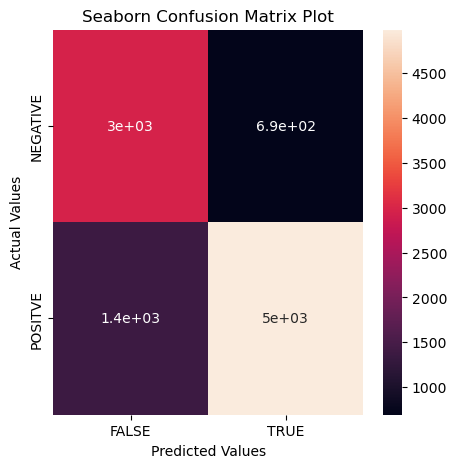




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.7974
GEOMETRIC MEAN SCORE:  0.7973










In [66]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

2.31






TESTING TIME

0.40



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      1944
      Attack       1.00      1.00      1.00      8056

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



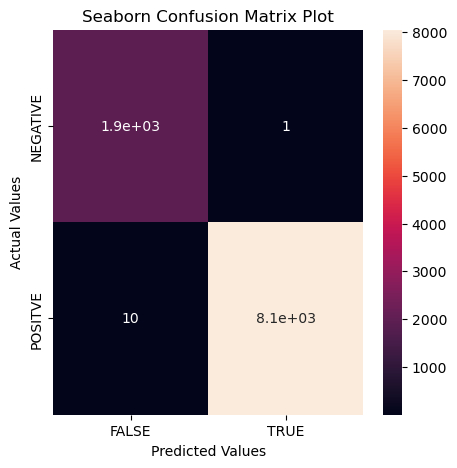




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9991
GEOMETRIC MEAN SCORE:  0.9991










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET





TRAINING TIME

61.66






TESTING TIME

15.87



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.94      0.81      0.87      4240
      Attack       0.87      0.96      0.92      5760

    accuracy                           0.90     10000
   macro avg       0.91      0.89      0.89     10000
weighted avg       0.90      0.90      0.90     10000




CONFUSION MATRIX



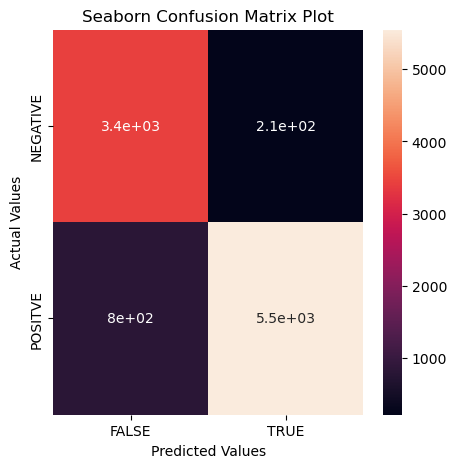




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9081
GEOMETRIC MEAN SCORE:  0.9075










In [67]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

0.22






TESTING TIME

0.00



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99      1991
      Attack       0.99      1.00      1.00      8009

    accuracy                           0.99     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000




CONFUSION MATRIX



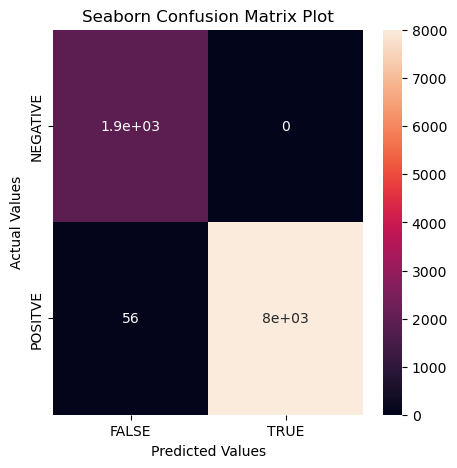




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9965
GEOMETRIC MEAN SCORE:  0.9965










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

0.41






TESTING TIME

0.00



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.95      0.75      0.84      4630
      Attack       0.82      0.96      0.88      5370

    accuracy                           0.86     10000
   macro avg       0.88      0.86      0.86     10000
weighted avg       0.88      0.86      0.86     10000




CONFUSION MATRIX



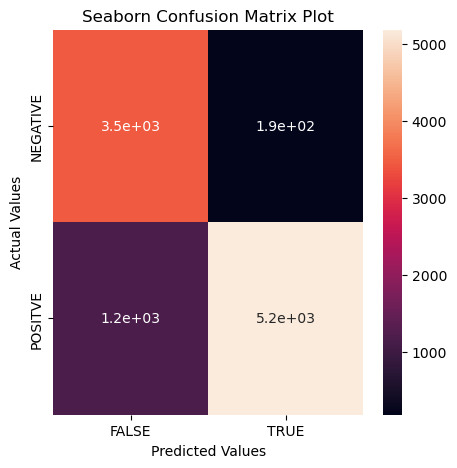




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8823
GEOMETRIC MEAN SCORE:  0.8799










In [68]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

1.02






TESTING TIME

0.02



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1943
      Attack       1.00      1.00      1.00      8057

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



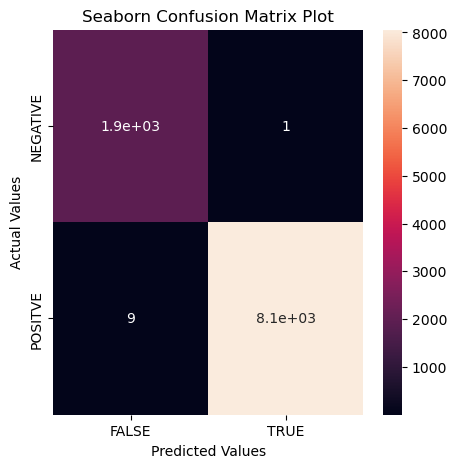




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9992
GEOMETRIC MEAN SCORE:  0.9992










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

2.52






TESTING TIME

0.04



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94      3701
      Attack       0.96      0.97      0.97      6299

    accuracy                           0.96     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000




CONFUSION MATRIX



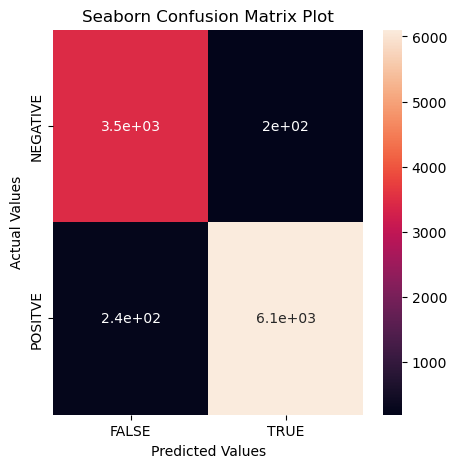




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9540
GEOMETRIC MEAN SCORE:  0.9540










In [69]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                1722      
                                                                 
 dense_1 (Dense)             (None, 1)                 42        
                                                                 
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,768
Trainable params: 1,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
641/641 [==============================] - 3s 3ms/step - loss: 0.3747 - accuracy: 0.8957
Epoch 2/10
641/641 [==============================] - 2s 3ms/step - loss: 0.1718 - accuracy: 0.9974
Epoch 3/10
641/641 [==============================] - 2s 3ms/step - loss: 0.1076 - accuracy: 0.9975
Epoch 4/10
641/641

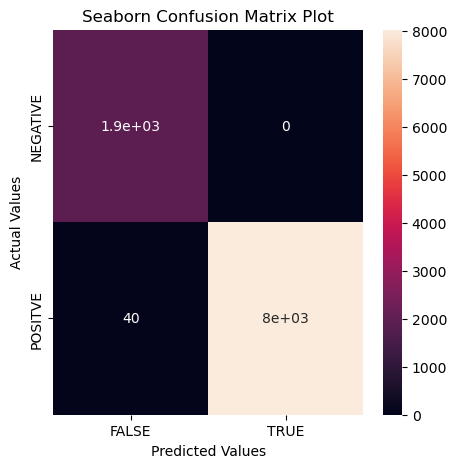




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9975
GEOMETRIC MEAN SCORE:  0.9975








Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 43)                1892      
                                                                 
 dense_4 (Dense)             (None, 1)                 44        
                                                                 
 dense_5 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
514/514 [==============================] - 2s 3ms/step - loss: 0.5853 - accuracy: 0.7733
Epoch 2/10
514/514 [==============================] - 2s 3ms/step - loss: 0.4272 - accuracy: 0.8914
Epoch 3/10
514/514 [======

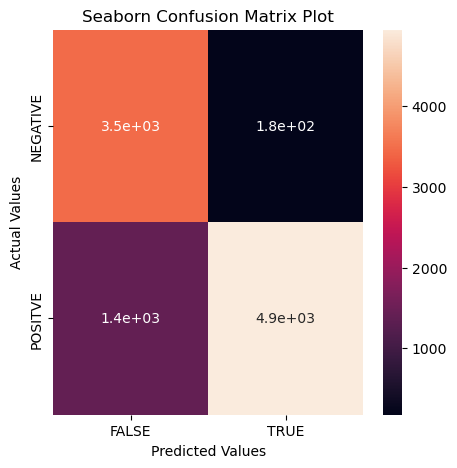




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8653
GEOMETRIC MEAN SCORE:  0.8610










In [70]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment I

In [71]:
KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [72]:
UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [73]:
KDD_Analysis_Summary_df

AUC    G-MEAN
NBC  0.929634  0.927356
SVM  0.999122  0.999122
DTC  0.996528  0.996522
RFC  0.999184  0.999184
ANN  0.997520  0.997517

In [74]:
UNSWNB15_Analysis_Summary_df

AUC    G-MEAN
NBC  0.797382  0.797283
SVM  0.908102  0.907461
DTC  0.882349  0.879866
RFC  0.954001  0.953972
ANN  0.865291  0.861011

### Experiment II Setup

#### Correlation Heatmap for the two datasets

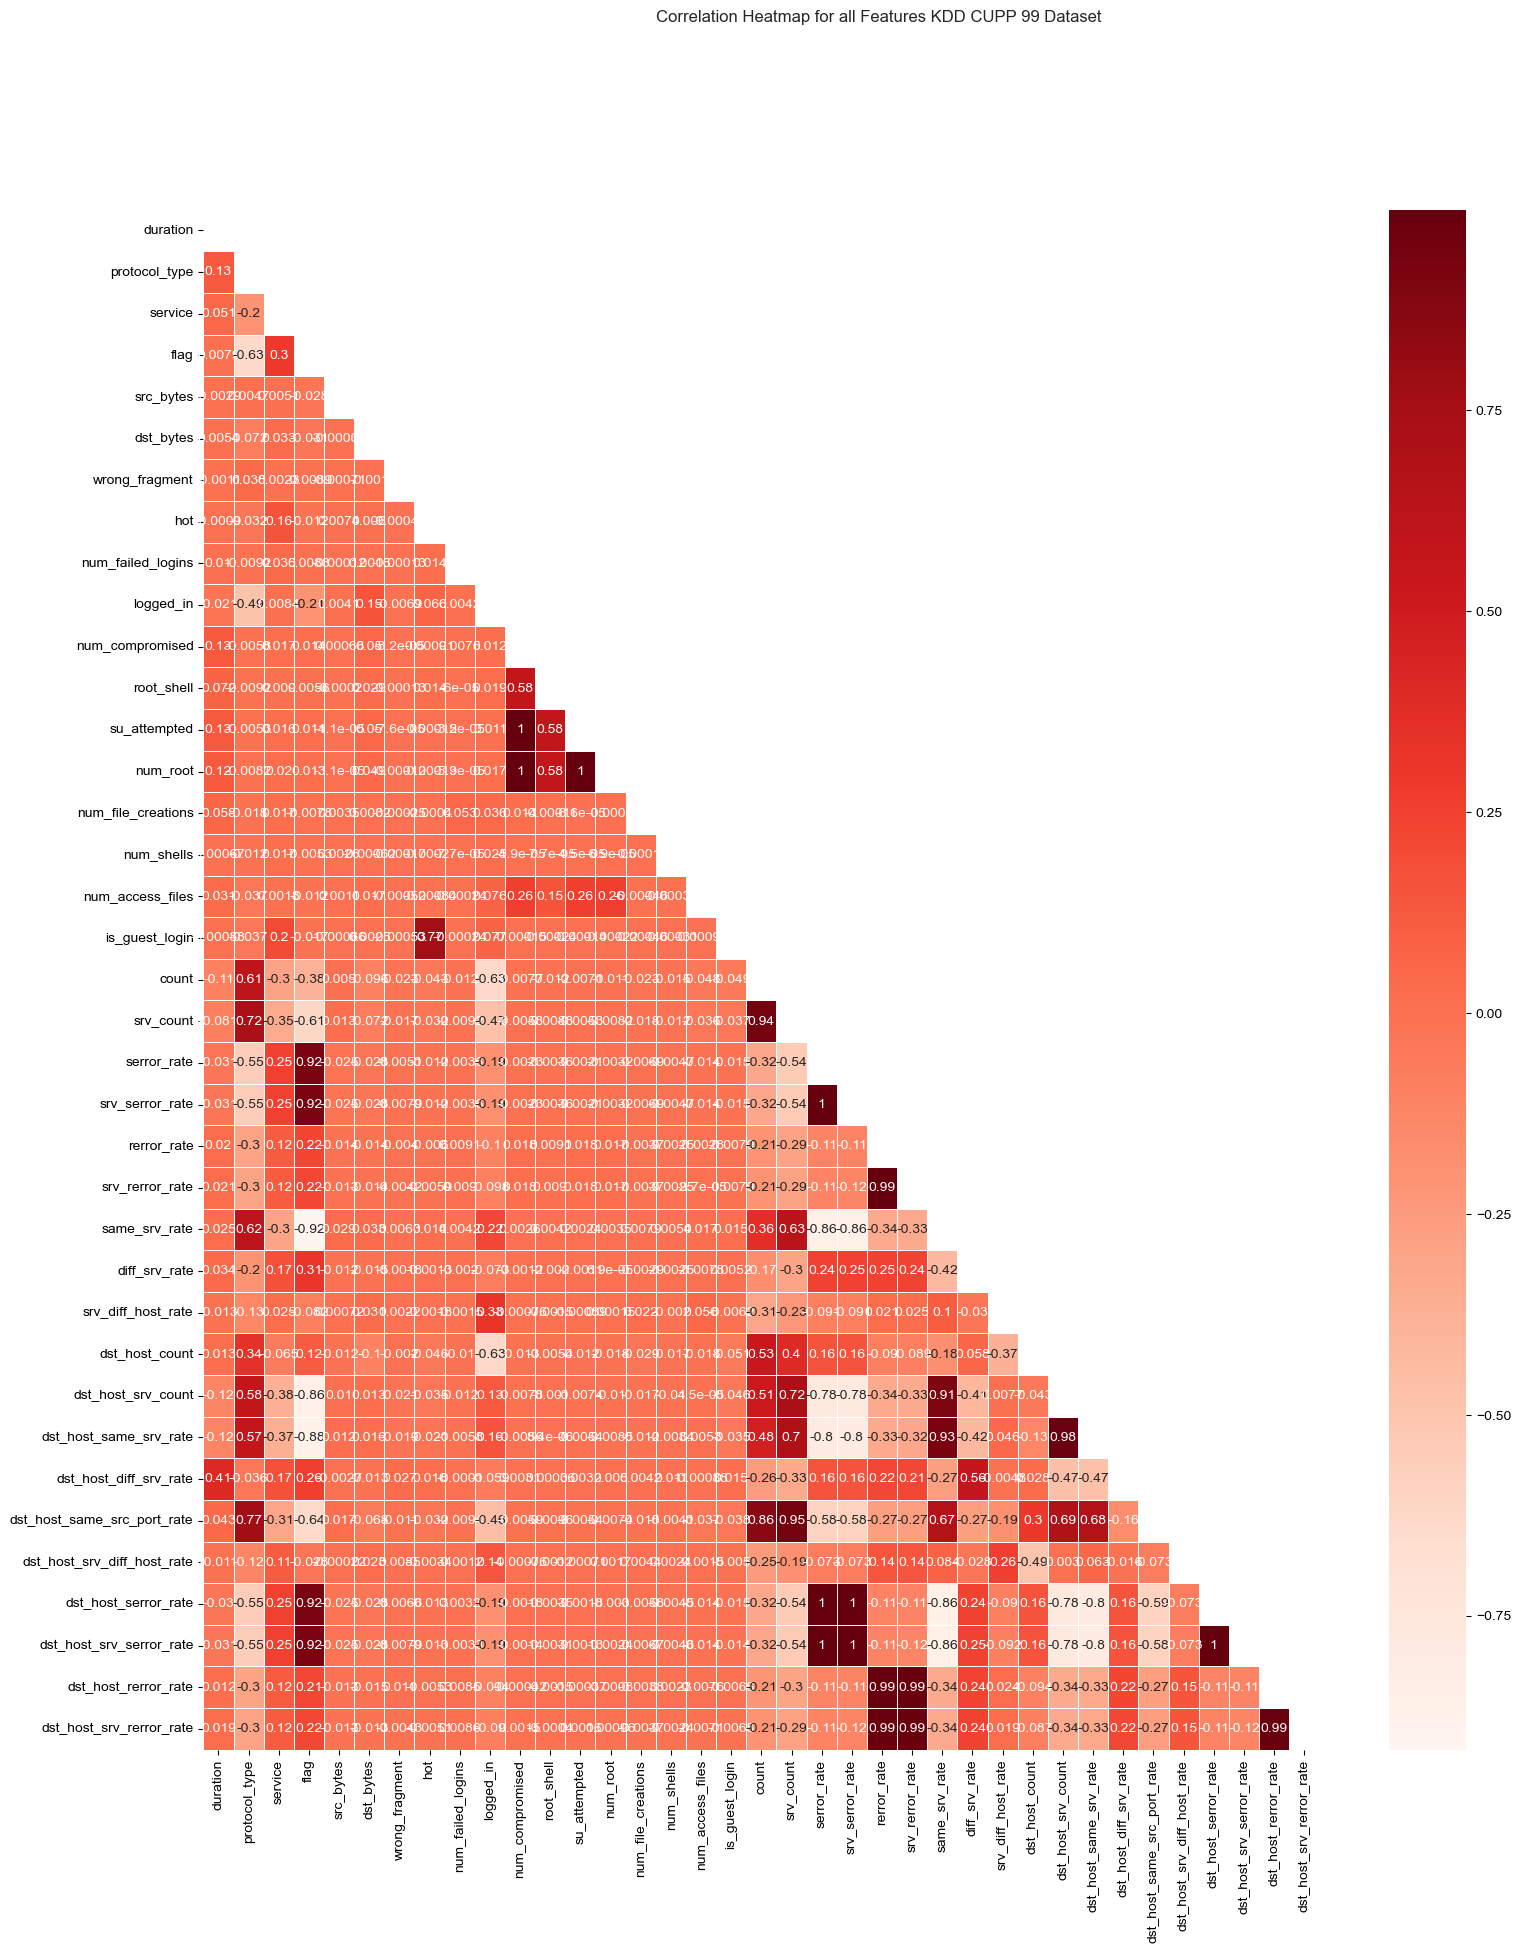

In [75]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

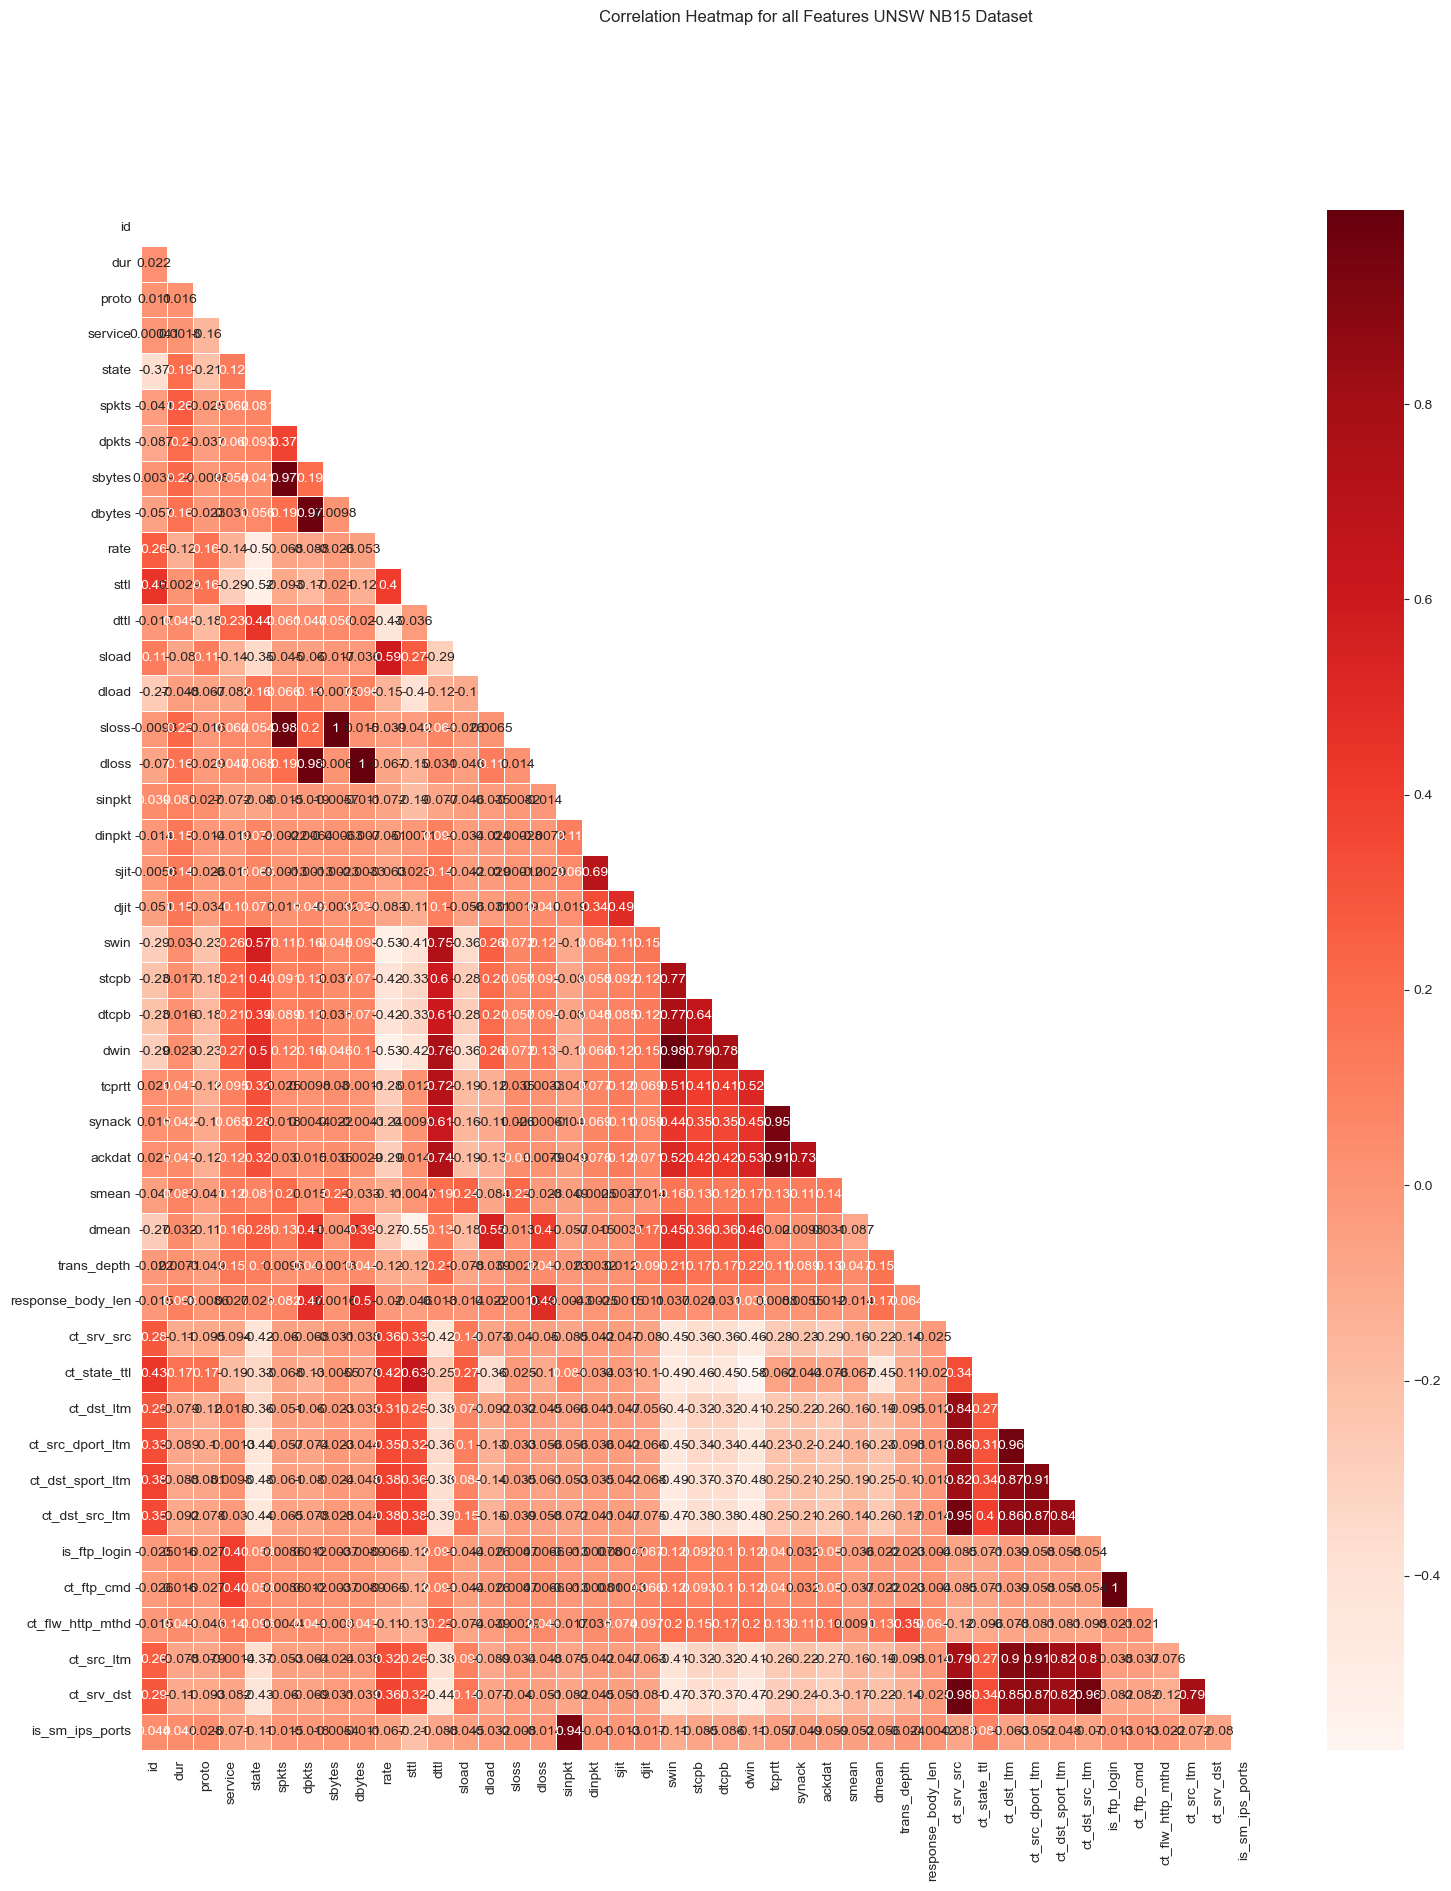

In [76]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [77]:
highly_correlation_kdd_cup_99_features = estimate_correlation_to_select_highly_correlated_features(features_kdd_cup_df, 0.90)




FEATURES WITH HIGH CORRELATION VALUES

su_attempted: 0.9996961644284383


num_root: 0.996002705553923


srv_count: 0.9424514896565259


serror_rate: 0.9202625880030073


srv_serror_rate: 0.9982079202419014


srv_rerror_rate: 0.9948558722252223


dst_host_srv_count: 0.9073713905267083


dst_host_same_srv_rate: 0.9789124071462983


dst_host_same_src_port_rate: 0.9473662940023682


dst_host_serror_rate: 0.9974184546129062


dst_host_srv_serror_rate: 0.9976354479028469


dst_host_rerror_rate: 0.9865023864778744


dst_host_srv_rerror_rate: 0.9850688595593021









In [78]:
highly_correlation_unswnb15_features = estimate_correlation_to_select_highly_correlated_features(features_unsw_nb15_df, 0.90)




FEATURES WITH HIGH CORRELATION VALUES

sbytes: 0.9711744027285035


dbytes: 0.9742420231466893


sloss: 0.9971989075630279


dloss: 0.9972535770505931


dwin: 0.9802551404126535


synack: 0.9468669267778295


ackdat: 0.9098962698079532


ct_src_dport_ltm: 0.9602390573916889


ct_dst_sport_ltm: 0.908637685593877


ct_dst_src_ltm: 0.9538988607334596


ct_ftp_cmd: 0.9986550295290084


ct_src_ltm: 0.9082467544383569


ct_srv_dst: 0.9593415116137682


is_sm_ips_ports: 0.9363498928382116









In [79]:
highly_correlation_kdd_cup_99_features
features_kdd_cup_df.drop(highly_correlation_kdd_cup_99_features, axis=1,  inplace = True)

['dst_host_srv_rerror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'num_root',
 'srv_count',
 'serror_rate',
 'su_attempted',
 'srv_rerror_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'srv_serror_rate',
 'dst_host_serror_rate']

In [80]:
highly_correlation_unswnb15_features
features_unsw_nb15_df.drop(highly_correlation_unswnb15_features, axis=1,  inplace = True)

['ct_ftp_cmd',
 'dbytes',
 'sbytes',
 'ct_dst_sport_ltm',
 'ct_src_ltm',
 'ct_dst_src_ltm',
 'is_sm_ips_ports',
 'sloss',
 'dwin',
 'ackdat',
 'ct_srv_dst',
 'synack',
 'dloss',
 'ct_src_dport_ltm']

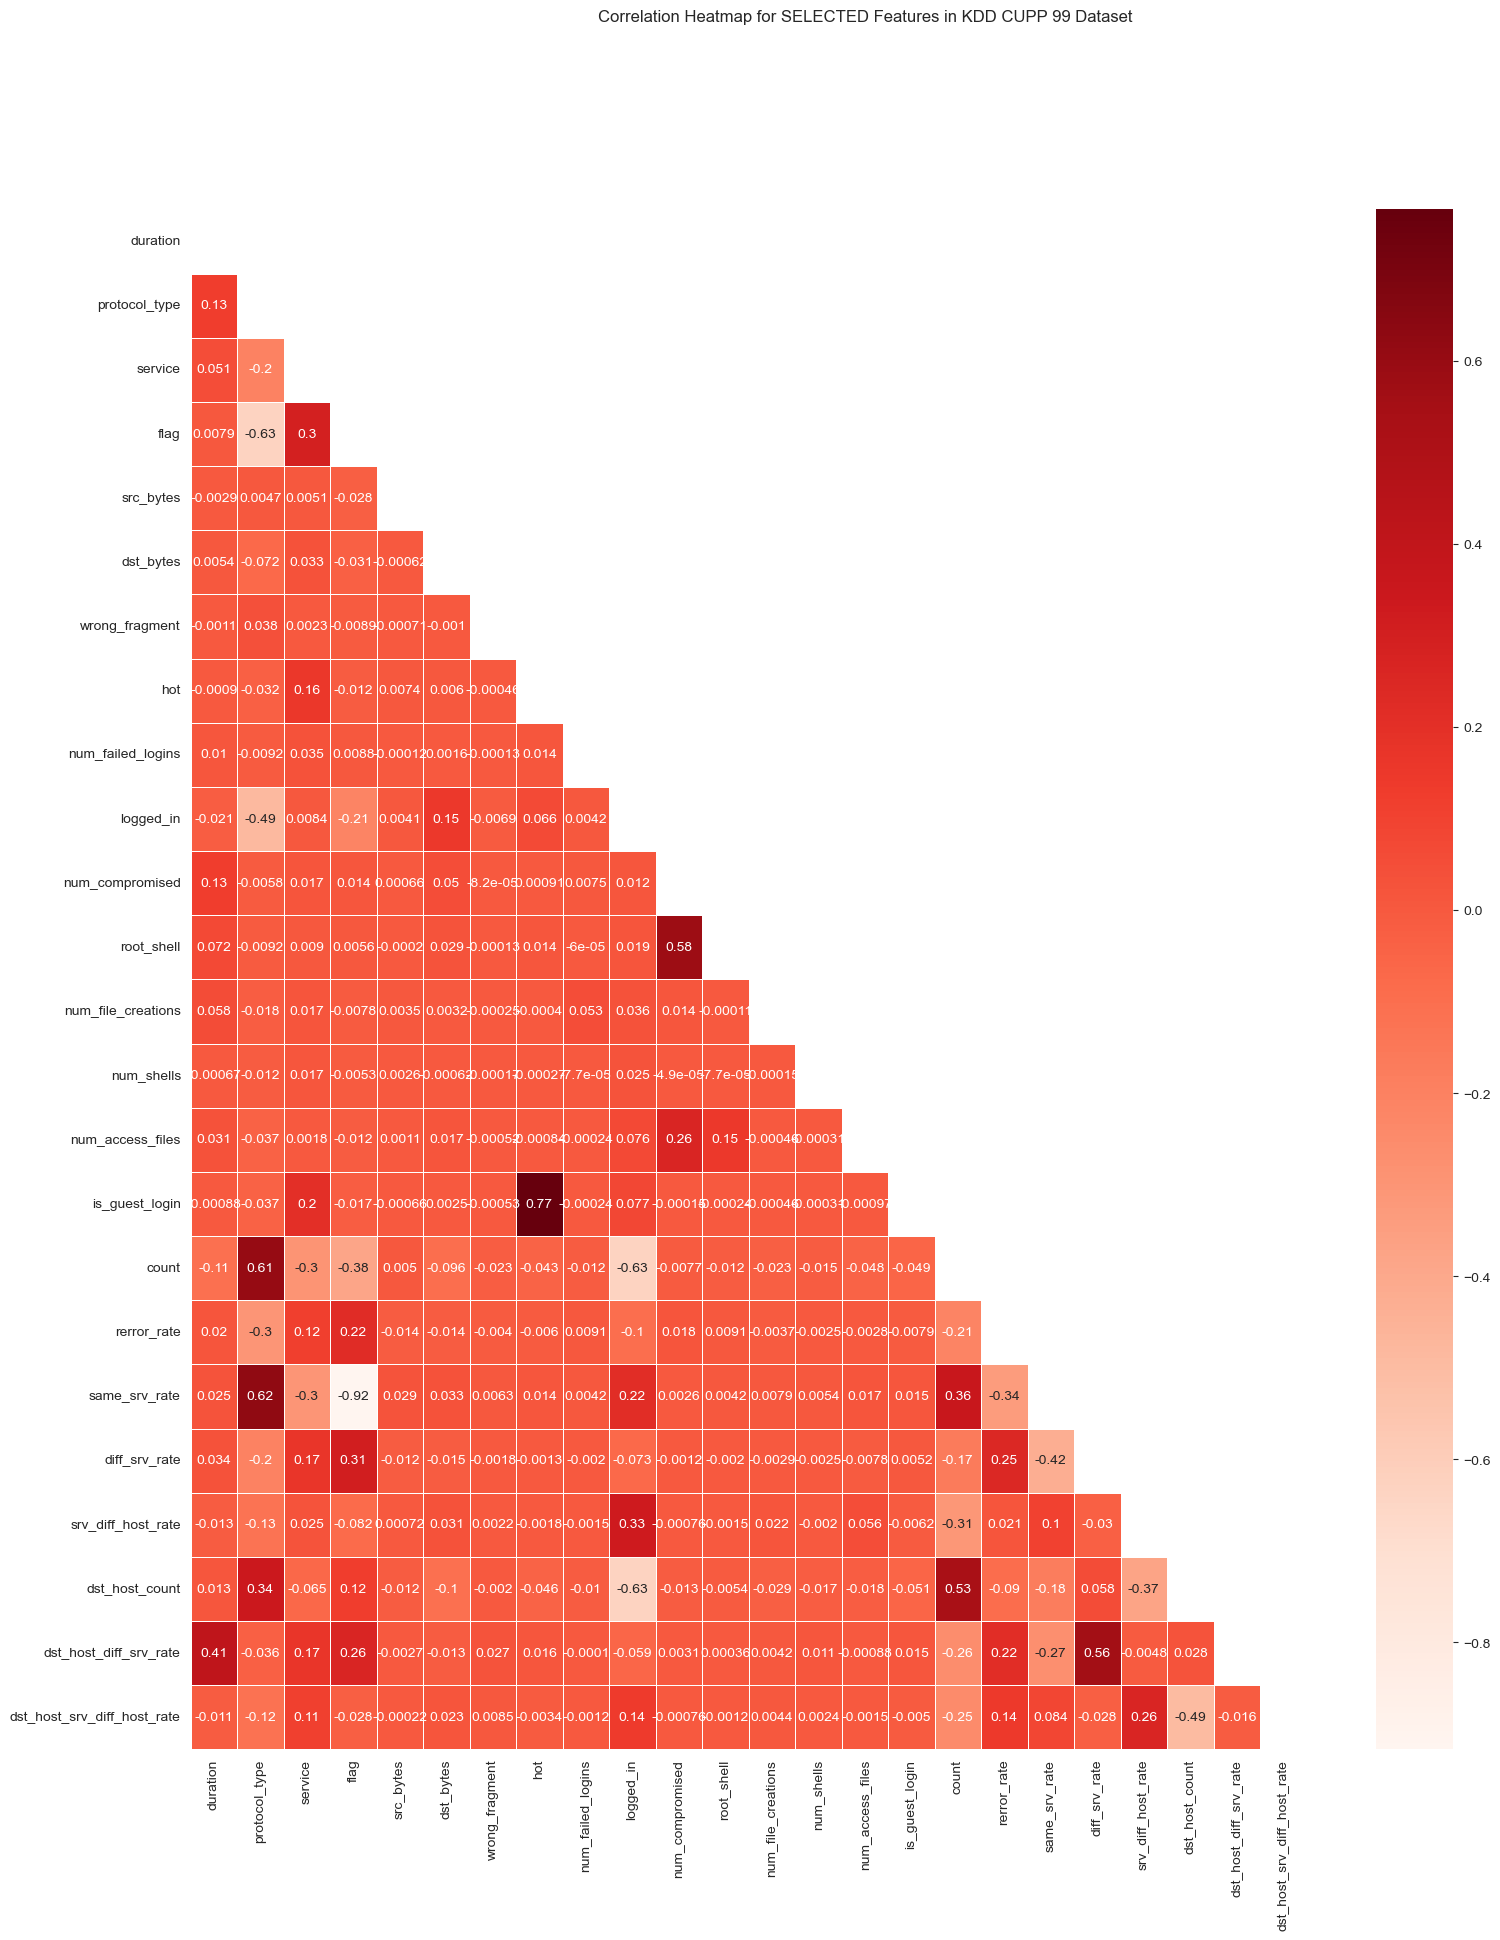

In [81]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

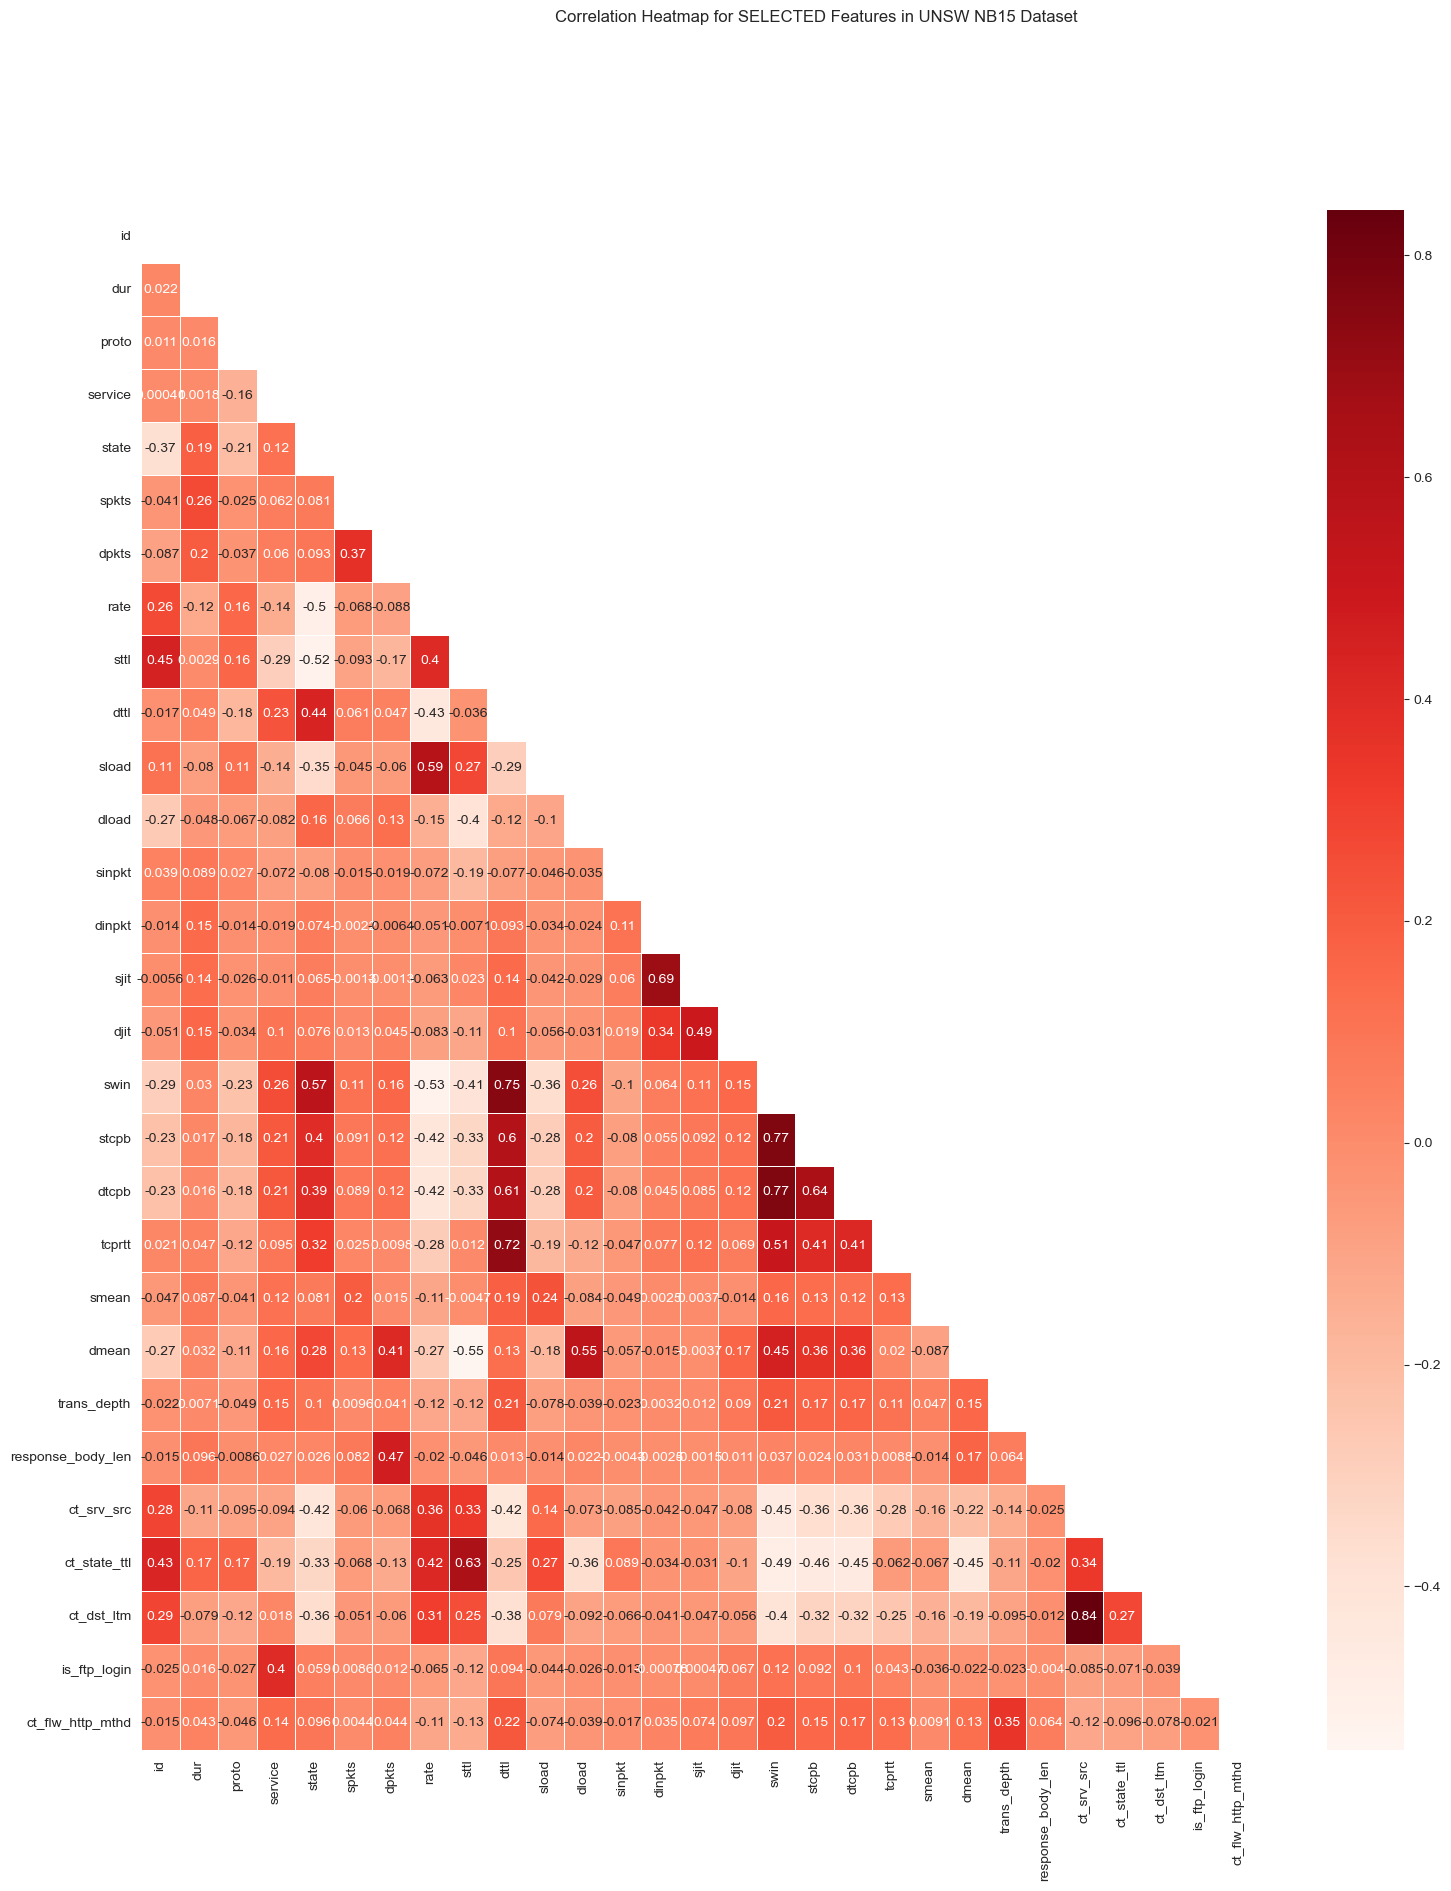

In [82]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [83]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [84]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

In [85]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [86]:
ros = SMOTE()

kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)

unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)

In [87]:
print(kddcup_y_train.agg(['nunique','count','size']))
print()
print(kddcup_y_train[kddcup_y_train == 0].count())
print()
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      64058
size       64058
Name: traffic_type, dtype: int64

32029

32029


In [88]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      51362
size       51362
Name: traffic_type, dtype: int64

25681

25681


In [89]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment II

In [90]:
experiment_type = "EXPERIMENT-TWO"



HYPER PARAMETER TUNING FOR NAIVE BAYES CLASSIFIER TO ANALYZE KDD CUPP 99 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS





ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

6.14






TESTING TIME

0.00



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      1940
      Attack       0.99      0.99      0.99      8060

    accuracy                           0.99     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000




CONFUSION MATRIX



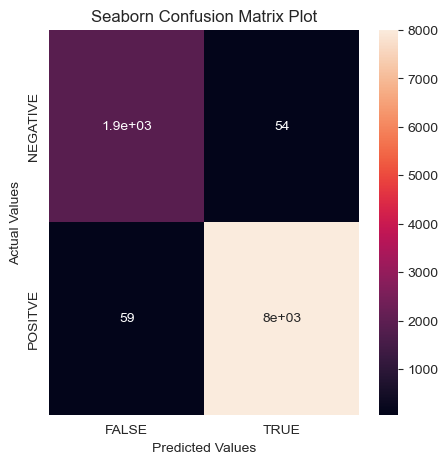




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9824
GEOMETRIC MEAN SCORE:  0.9823










HYPER PARAMETER TUNING FOR NAIVE BAYES CLASSIFIER TO ANALYZE UNSW NB15 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS





ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

1.11






TESTING TIME

0.01



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.81      0.70      0.75      4238
      Attack       0.80      0.88      0.84      5762

    accuracy                           0.80     10000
   macro avg       0.81      0.79      0.79     10000
weighted avg       0.80      0.80      0.80     10000




CONFUSION MATRIX



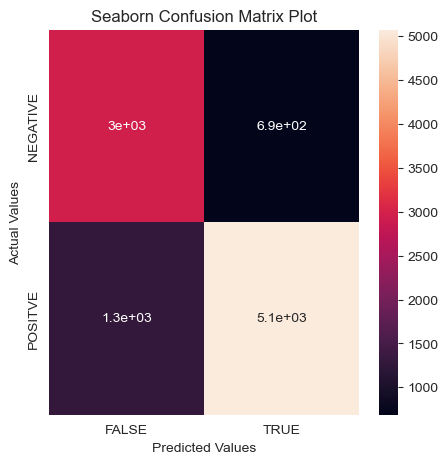




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8054
GEOMETRIC MEAN SCORE:  0.8053










In [91]:
hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)



HYPER PARAMETER TUNING FOR SUPPORT VECTOR MACHINE TO ANALYZE KDD CUPP 99 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS





ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

993.39






TESTING TIME

0.13



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      1956
      Attack       1.00      1.00      1.00      8044

    accuracy                           1.00     10000
   macro avg       1.00      0.99      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



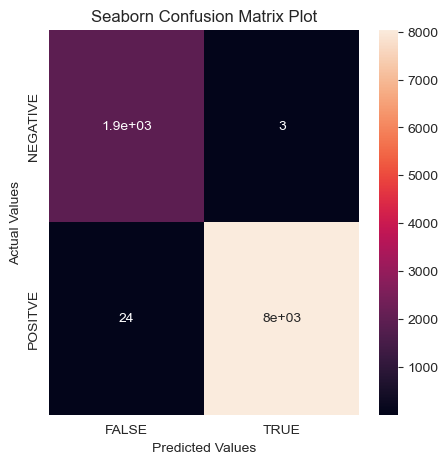




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9977
GEOMETRIC MEAN SCORE:  0.9977










HYPER PARAMETER TUNING FOR SUPPORT VECTOR MACHINE TO ANALYZE UNSW NB15 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS





ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET





TRAINING TIME

3700.72






TESTING TIME

4.63



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.94      0.73      0.82      4671
      Attack       0.80      0.96      0.88      5329

    accuracy                           0.85     10000
   macro avg       0.87      0.85      0.85     10000
weighted avg       0.87      0.85      0.85     10000




CONFUSION MATRIX



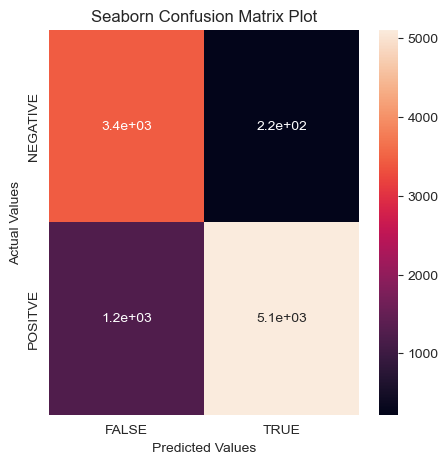




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8724
GEOMETRIC MEAN SCORE:  0.8698










In [92]:
hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)



HYPER PARAMETER TUNING FOR DECISION TREE CLASSIFIER TO ANALYZE KDD CUPP 99 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS





ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

7.20






TESTING TIME

0.00



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99      1972
      Attack       1.00      1.00      1.00      8028

    accuracy                           1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



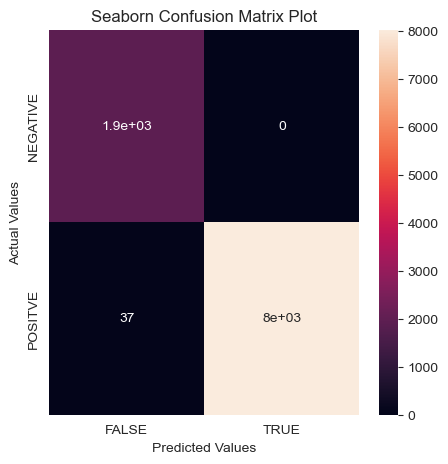




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9977
GEOMETRIC MEAN SCORE:  0.9977










HYPER PARAMETER TUNING FOR DECISION TREE CLASSIFIER TO ANALYZE UNSW NB15 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS





ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

4.80






TESTING TIME

0.00



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.94      0.89      0.91      3835
      Attack       0.93      0.96      0.95      6165

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000




CONFUSION MATRIX



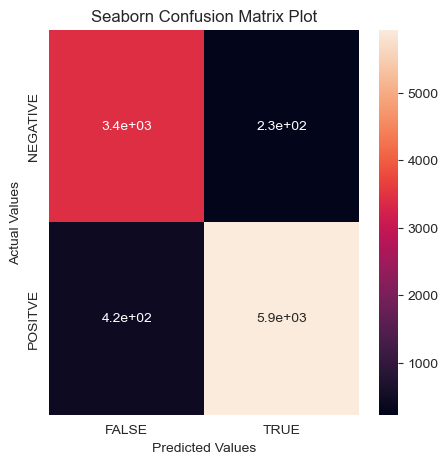




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9350
GEOMETRIC MEAN SCORE:  0.9350










In [93]:
hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)



HYPER PARAMETER TUNING FOR RANDOM FOREST CLASSIFIER TO ANALYZE KDD CUPP 99 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS





ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

26.21






TESTING TIME

0.04



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1939
      Attack       1.00      1.00      1.00      8061

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



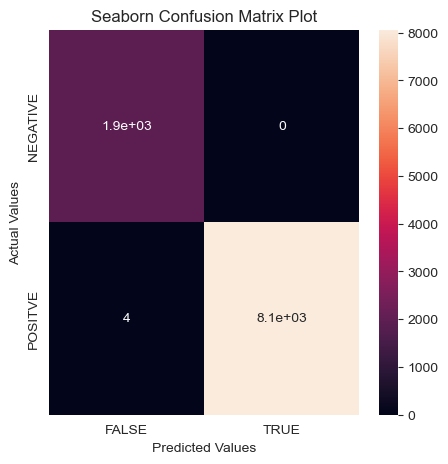




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9998
GEOMETRIC MEAN SCORE:  0.9998










HYPER PARAMETER TUNING FOR RANDOM FOREST CLASSIFIER TO ANALYZE UNSW NB15 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS





ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

72.04






TESTING TIME

0.06



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.94      3706
      Attack       0.96      0.97      0.97      6294

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000




CONFUSION MATRIX



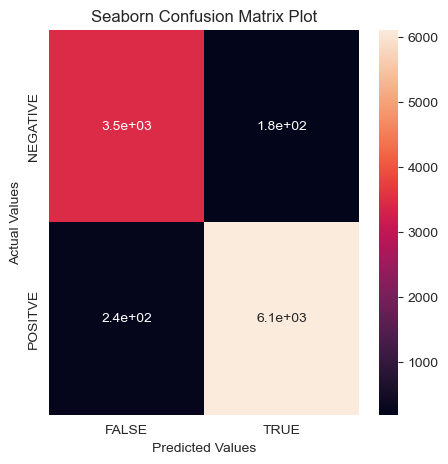




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9564
GEOMETRIC MEAN SCORE:  0.9564










In [94]:
hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)



HYPER PARAMETER TUNING FOR ARTIFICIAL NEURAL NETWORK TO ANALYZE KDD CUPP 99 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 28)                812       
                                                                 
 dense_7 (Dense)             (None, 1)                 29        
                                                                 
 dense_8 (Dense)             (None, 2)                 4         
                                                                 
Total params: 845
Trainable params: 845
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3203/3203 [==============================] - 11s 3ms/step - loss: 0.2724 - accuracy: 0.9746
Epoch 2/10
3203/3203 [==============================]

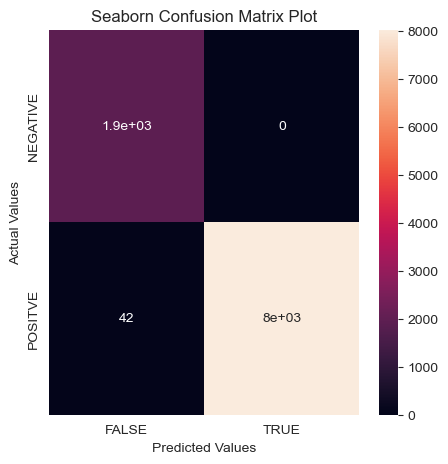




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9974
GEOMETRIC MEAN SCORE:  0.9974










HYPER PARAMETER TUNING FOR ARTIFICIAL NEURAL NETWORK TO ANALYZE UNSW NB15 DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS 0.000 SECONDS



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 29)                870       
                                                                 
 dense_10 (Dense)            (None, 1)                 30        
                                                                 
 dense_11 (Dense)            (None, 2)                 4         
                                                                 
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2569/2569 [==============================] - 8s 3ms/step 

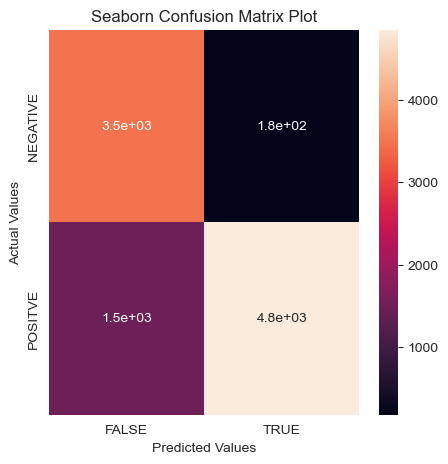




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8569
GEOMETRIC MEAN SCORE:  0.8519










In [95]:
hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment II

In [96]:
KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [97]:
UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [98]:
KDD_Analysis_Summary_df

AUC    G-MEAN
NBC  0.982389  0.982335
SVM  0.997737  0.997737
DTC  0.997706  0.997704
RFC  0.999752  0.999752
ANN  0.997396  0.997393

In [99]:
UNSWNB15_Analysis_Summary_df

AUC    G-MEAN
NBC  0.805370  0.805346
SVM  0.872434  0.869812
DTC  0.935035  0.935035
RFC  0.956411  0.956390
ANN  0.856946  0.851863